In [1]:
#-*-coding:utf-8-*-
from __future__ import print_function, division
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.models import Sequential
import util
import utils
import tensorflow.contrib.gan as tfgan
num_images_to_eval = 500
import torch.nn as nn
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, imgs, transform=None):
        # super().__init__()
        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img = self.imgs[index]
        if self.transform is not None:
            img = self.transform(img)
        else:
            img = torch.from_numpy(img)
        return img


import math
import os
import numpy as np
import ot
import torch
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models

from scipy import linalg

from keras.datasets import mnist
import matplotlib.pyplot as plt

def giveName(iter):  # 7 digit name.
    ans = str(iter)
    return ans.zfill(7)

def make_dataset(dataset, dataroot, imageSize):
    """
    :param dataset: must be in 'cifar10 | lsun | imagenet | folder | lfw | fake'
    :return: pytorch dataset for DataLoader to utilize
    """
    if dataset in ['imagenet', 'folder', 'lfw']:
        print(os.getcwd() + dataroot)  # 函数的作用是用于返回当前工作目录
        # folder dataset
        # dataset = dset.ImageFolder(root=dataroot,
        dataset = dset.ImageFolder(root=os.getcwd() + dataroot,
                                   transform=transforms.Compose([
                                       transforms.Resize(imageSize),
                                       # transforms.CenterCrop(imageSize),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ]))
    elif dataset == 'lsun':
        dataset = dset.LSUN(db_path=dataroot, classes=['bedroom_train'],
                            transform=transforms.Compose([
                                transforms.Resize(imageSize),
                                transforms.CenterCrop(imageSize),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))
    elif dataset == 'cifar10':
        dataset = dset.CIFAR10(root=dataroot, download=True,
                               transform=transforms.Compose([
                                   transforms.Resize(imageSize),
                                   transforms.ToTensor(),
                                   transforms.Normalize(
                                       (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))
    elif dataset == 'celeba':
        dataset = dset.ImageFolder(root=dataroot,
                                   transform=transforms.Compose([
                                       transforms.CenterCrop(138),
                                       transforms.Resize(imageSize),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ]))
    else:
        raise Exception('--dataset must be in cifar10 | lsun | imagenet | folder | lfw | fake')
    assert dataset
    return dataset

MNIST_CLASSIFIER_FROZEN_GRAPH = './classify_mnist_graph_def.pb'
INPUT_TENSOR = 'inputs:0'
OUTPUT_TENSOR = 'logits:0'
# CONV_TENSOR = 'fc3/Relu:0'
CONV_TENSOR = 'fc4/BiasAdd:0'
class ConvNetFeatureSaver(object):
    def __init__(self, model='cnn', workers=4, batchSize=64):
        '''
        model: inception_v3, vgg13, vgg16, vgg19, resnet18, resnet34,
               resnet50, resnet101, or resnet152
        '''
        self.model = model
        self.batch_size = batchSize
        self.workers = workers
        if self.model.find('tfgan') >= 0:
            print('tfgan')

        elif self.model.find('vgg') >= 0:
            self.vgg = getattr(models, model)(pretrained=True).cuda().eval()
            self.trans = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),
                                     (0.229, 0.224, 0.225)),
            ])
        elif self.model.find('resnet') >= 0:
            resnet = getattr(models, model)(pretrained=True)
            resnet.cuda().eval()
            resnet_feature = nn.Sequential(resnet.conv1, resnet.bn1,
                                           resnet.relu,
                                           resnet.maxpool, resnet.layer1,
                                           resnet.layer2, resnet.layer3,
                                           resnet.layer4).cuda().eval()
            self.resnet = resnet
            self.resnet_feature = resnet_feature
            self.trans = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),
                                     (0.229, 0.224, 0.225)),
            ])
        elif self.model == 'inception' or self.model == 'inception_v3':
            inception = models.inception_v3(
                pretrained=True, transform_input=False).cuda().eval()
            inception_feature = nn.Sequential(inception.Conv2d_1a_3x3,
                                              inception.Conv2d_2a_3x3,
                                              inception.Conv2d_2b_3x3,
                                              nn.MaxPool2d(3, 2),
                                              inception.Conv2d_3b_1x1,
                                              inception.Conv2d_4a_3x3,
                                              nn.MaxPool2d(3, 2),
                                              inception.Mixed_5b,
                                              inception.Mixed_5c,
                                              inception.Mixed_5d,
                                              inception.Mixed_6a,
                                              inception.Mixed_6b,
                                              inception.Mixed_6c,
                                              inception.Mixed_6d,
                                              inception.Mixed_7a,
                                              inception.Mixed_7b,
                                              inception.Mixed_7c,
                                              ).cuda().eval()
            self.inception = inception
            self.inception_feature = inception_feature
            self.trans = transforms.Compose([
                transforms.Resize(299),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
        else:
            raise NotImplementedError

    def save(self, imgFolder, dataloader, save2disk=False):
        feature_pixl, feature_conv, feature_smax, feature_logit = [], [], [], []

        for img in dataloader:
            with torch.no_grad():
                input = img.cuda()
                if self.model == 'tfgan':
                    gen_imgs = np.array(img)
                    eval_images = tf.convert_to_tensor(gen_imgs)
                    flogit = util.mnist_logits(eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH, INPUT_TENSOR, OUTPUT_TENSOR)
                    fconv = util.mnist_logits(eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH, INPUT_TENSOR, CONV_TENSOR)
                    flogit,fconv=tf.Session().run([flogit,fconv])

                    flogit=torch.from_numpy(flogit)
                    fconv=torch.from_numpy(fconv)
                elif self.model == 'vgg' or self.model == 'vgg16':
                    print(self.vgg.features(input).shape)
                    fconv = self.vgg.features(input).view(input.size(0), -1)  # 相当于reshape
                    flogit = self.vgg.classifier(fconv)
                    # flogit = self.vgg.logitifier(fconv)
                elif self.model.find('resnet') >= 0:
                    fconv = self.resnet_feature(
                        input).mean(3).mean(2).squeeze()
                    flogit = self.resnet.fc(fconv)
                elif self.model == 'inception' or self.model == 'inception_v3':
                    fconv = self.inception_feature(
                        input).mean(3).mean(2).squeeze()
                    flogit = self.inception.fc(fconv)
                else:
                    raise NotImplementedError
                fsmax = F.softmax(flogit)
                '''
                总共有四个空间：1.feature_pixl 2.feature_conv 3.feature_logit 4.feature_smax
                '''
                feature_pixl.append(img)
                feature_conv.append(fconv.data.cpu())
                feature_logit.append(flogit.data.cpu())
                feature_smax.append(fsmax.data.cpu())

        feature_pixl = torch.cat(feature_pixl, 0).to('cpu')
        feature_conv = torch.cat(feature_conv, 0).to('cpu')
        feature_logit = torch.cat(feature_logit, 0).to('cpu')
        feature_smax = torch.cat(feature_smax, 0).to('cpu')

        return feature_pixl, feature_conv, feature_logit, feature_smax

    # return feature_pixl, feature_conv, feature_logit, feature_smax


def distance(X, Y, sqrt):
    nX = X.size(0)
    nY = Y.size(0)
    X = X.view(nX, -1)
    X2 = (X * X).sum(1).resize_(nX, 1)
    Y = Y.view(nY, -1)
    Y2 = (Y * Y).sum(1).resize_(nY, 1)

    M = torch.zeros(nX, nY)
    M.copy_(X2.expand(nX, nY) + Y2.expand(nY, nX).transpose(0, 1) -
            2 * torch.mm(X, Y.transpose(0, 1)))

    del X, X2, Y, Y2

    if sqrt:
        M = ((M + M.abs()) / 2).sqrt()

    return M


def wasserstein(M, sqrt):
    if sqrt:
        M = M.abs().sqrt()
    emd = ot.emd2([], [], M.numpy())

    return emd


class Score_knn:
    acc = 0
    acc_real = 0
    acc_fake = 0
    precision = 0
    recall = 0
    tp = 0
    fp = 0
    fn = 0
    ft = 0


def knn(Mxx, Mxy, Myy, k, sqrt):
    n0 = Mxx.size(0)
    n1 = Myy.size(0)
    label = torch.cat((torch.ones(n0), torch.zeros(n1)))
    M = torch.cat((torch.cat((Mxx, Mxy), 1), torch.cat(
        (Mxy.transpose(0, 1), Myy), 1)), 0)
    if sqrt:
        M = M.abs().sqrt()
    INFINITY = float('inf')
    val, idx = (M + torch.diag(INFINITY * torch.ones(n0 + n1))
                ).topk(k, 0, False)

    count = torch.zeros(n0 + n1)
    for i in range(0, k):
        count = count + label.index_select(0, idx[i])
    pred = torch.ge(count, (float(k) / 2) * torch.ones(n0 + n1)).float()

    s = Score_knn()
    s.tp = (pred * label).sum()
    s.fp = (pred * (1 - label)).sum()
    s.fn = ((1 - pred) * label).sum()
    s.tn = ((1 - pred) * (1 - label)).sum()
    s.precision = s.tp / (s.tp + s.fp + 1e-10)
    s.recall = s.tp / (s.tp + s.fn + 1e-10)
    s.acc_t = s.tp / (s.tp + s.fn)
    s.acc_f = s.tn / (s.tn + s.fp)
    s.acc = torch.eq(label, pred).float().mean()
    s.k = k

    return s


def mmd(Mxx, Mxy, Myy, sigma):
    scale = Mxx.mean()
    Mxx = torch.exp(-Mxx / (scale * 2 * sigma * sigma))
    Mxy = torch.exp(-Mxy / (scale * 2 * sigma * sigma))
    Myy = torch.exp(-Myy / (scale * 2 * sigma * sigma))
    mmd = math.sqrt(Mxx.mean() + Myy.mean() - 2 * Mxy.mean())

    return mmd


def entropy_score(X, Y, epsilons):
    Mxy = distance(X, Y, False)
    scores = []
    for epsilon in epsilons:
        scores.append(ent(Mxy.t(), epsilon))

    return scores


def ent(M, epsilon):
    n0 = M.size(0)
    n1 = M.size(1)
    neighbors = M.lt(epsilon).float()
    sums = neighbors.sum(0).repeat(n0, 1)
    sums[sums.eq(0)] = 1
    neighbors = neighbors.div(sums)
    probs = neighbors.sum(1) / n1
    rem = 1 - probs.sum()
    if rem < 0:
        rem = 0
    probs = torch.cat((probs, rem * torch.ones(1)), 0)
    e = {}
    e['probs'] = probs
    probs = probs[probs.gt(0)]
    e['ent'] = -probs.mul(probs.log()).sum()

    return e


eps = 1e-20


def inception_score(X):
    kl = X * ((X + eps).log() - (X.mean(0) + eps).log().expand_as(X))
    score = np.exp(kl.sum(1).mean())

    return score


def mode_score(X, Y):
    kl1 = X * ((X + eps).log() - (X.mean(0) + eps).log().expand_as(X))
    kl2 = X.mean(0) * ((X.mean(0) + eps).log() - (Y.mean(0) + eps).log())
    score = np.exp(kl1.sum(1).mean() - kl2.sum())

    return score


def fid(X, Y):
    m = X.mean(0)
    m_w = Y.mean(0)
    X_np = X.numpy()
    Y_np = Y.numpy()

    C = np.cov(X_np.transpose())
    C_w = np.cov(Y_np.transpose())
    C_C_w_sqrt = linalg.sqrtm(C.dot(C_w), True).real

    score = m.dot(m) + m_w.dot(m_w) - 2 * m_w.dot(m) + \
            np.trace(C + C_w - 2 * C_C_w_sqrt)
    return np.sqrt(score)


class Score:
    emd = 0
    mmd = 0
    knn = None


def compute_score(real, fake, k=1, sigma=1, sqrt=True):
    Mxx = distance(real, real, False)
    Mxy = distance(real, fake, False)
    Myy = distance(fake, fake, False)

    s = Score()
    s.emd = wasserstein(Mxy, sqrt)
    s.mmd = mmd(Mxx, Mxy, Myy, sigma)
    s.knn = knn(Mxx, Mxy, Myy, k, sqrt)

    return s


'''
参数说明：
dataset:真实数据集的path
imageSize:图片的大小
dataroot_real:真实数据所在的path
batchSize
saveFolder_r:真实数据的保存位置
conv_model:卷积模型
'''


def compute_score_raw(real_dataloader, fake_dataloader, batchSize, saveFolder_r, saveFolder_f, conv_model='resnet34',
                      workers=4):
    convnet_feature_saver = ConvNetFeatureSaver(model=conv_model,
                                                batchSize=batchSize, workers=workers)
    print(saveFolder_r)
    print(saveFolder_f)
    feature_r = convnet_feature_saver.save(saveFolder_r, real_dataloader, False)
    feature_f = convnet_feature_saver.save(saveFolder_f, fake_dataloader, False)

    # 4 feature spaces and 7 scores + incep + modescore + fid
    score = np.zeros(2 * 7 + 5)
    for i in range(0, 2):
        print('compute score in space: ' + str(i))
        Mxx = distance(feature_r[i], feature_r[i], False)
        Mxy = distance(feature_r[i], feature_f[i], False)
        Myy = distance(feature_f[i], feature_f[i], False)

        score[i * 7] = wasserstein(Mxy, True)
        score[i * 7 + 1] = mmd(Mxx, Mxy, Myy, 1)
        tmp = knn(Mxx, Mxy, Myy, 1, False)
        score[(i * 7 + 2):(i * 7 + 7)] = \
            tmp.acc, tmp.acc_t, tmp.acc_f, tmp.precision, tmp.recall


    score[14] = inception_score(feature_f[3])
    score[15] = mode_score(feature_r[3], feature_f[3])
    score[16] = fid(feature_r[3], feature_f[3])

    return score
labels_name=['w_pixl','mmd_pixl','acc_pixl','acc_t_pixl','acc_f_pixl','acc_precision_pixl','acc_recall_pixl',
             'w_conv','mmd_conv','acc_conv','acc_t_conv','acc_f_conv','acc_precision_conv','acc_recall_conv',
             'is','mode_score','fid' ,'tf_is','tf_fid']
if not os.path.isdir('saved_models_{}'.format('cgan')):
    os.mkdir('saved_models_{}'.format('cgan'))
f = open('saved_models_{}/log_collapse1.txt'.format('cgan'), mode='w')

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               615440    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
__________

/home/imi432_006/anaconda3/envs/tf/lib/python3.5/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:0 step:1 [D loss: 1.129638, acc.: 28.91%] [G loss: 0.123380]
epoch:0 step:2 [D loss: 1.710235, acc.: 50.00%] [G loss: 0.435766]
epoch:0 step:3 [D loss: 0.855609, acc.: 54.69%] [G loss: 1.682687]
epoch:0 step:4 [D loss: 0.942466, acc.: 41.41%] [G loss: 1.650976]
epoch:0 step:5 [D loss: 0.771287, acc.: 48.44%] [G loss: 2.064589]
epoch:0 step:6 [D loss: 0.447159, acc.: 81.25%] [G loss: 2.130864]
epoch:0 step:7 [D loss: 0.578998, acc.: 68.75%] [G loss: 1.963072]
epoch:0 step:8 [D loss: 0.659561, acc.: 60.16%] [G loss: 2.492816]
epoch:0 step:9 [D loss: 0.662356, acc.: 63.28%] [G loss: 3.376863]
epoch:0 step:10 [D loss: 0.756562, acc.: 63.28%] [G loss: 3.554047]
epoch:0 step:11 [D loss: 1.032567, acc.: 55.47%] [G loss: 3.790560]
epoch:0 step:12 [D loss: 0.904429, acc.: 66.41%] [G loss: 4.289835]
epoch:0 step:13 [D loss: 0.713028, acc.: 78.12%] [G loss: 3.506579]
epoch:0 step:14 [D loss: 0.352748, acc.: 82.81%] [G loss: 3.180142]
epoch:0 step:15 [D loss: 0.226423, acc.: 91.41%] [G loss:

epoch:0 step:124 [D loss: 0.024289, acc.: 100.00%] [G loss: 6.644809]
epoch:0 step:125 [D loss: 0.026624, acc.: 99.22%] [G loss: 6.709792]
epoch:0 step:126 [D loss: 0.017280, acc.: 100.00%] [G loss: 5.674032]
epoch:0 step:127 [D loss: 0.019755, acc.: 100.00%] [G loss: 6.959846]
epoch:0 step:128 [D loss: 0.025779, acc.: 100.00%] [G loss: 6.136035]
epoch:0 step:129 [D loss: 0.039376, acc.: 99.22%] [G loss: 5.117277]
epoch:0 step:130 [D loss: 0.028210, acc.: 100.00%] [G loss: 6.233679]
epoch:0 step:131 [D loss: 0.010922, acc.: 100.00%] [G loss: 5.760288]
epoch:0 step:132 [D loss: 0.031521, acc.: 98.44%] [G loss: 5.805212]
epoch:0 step:133 [D loss: 0.016947, acc.: 100.00%] [G loss: 4.526794]
epoch:0 step:134 [D loss: 0.031769, acc.: 99.22%] [G loss: 5.523455]
epoch:0 step:135 [D loss: 0.006244, acc.: 100.00%] [G loss: 5.480632]
epoch:0 step:136 [D loss: 0.166896, acc.: 92.19%] [G loss: 4.811122]
epoch:0 step:137 [D loss: 0.319530, acc.: 87.50%] [G loss: 6.336960]
epoch:0 step:138 [D loss: 

/home/imi432_006/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:208: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


compute score in space: 0
compute score in space: 1
IS socre: 1.017907
FID: 365.164734
0 = 22.455742426586134
1 = 0.7110105204548304
2 = 1.0
3 = 1.0
4 = 1.0
5 = 1.0
6 = 1.0
7 = 19.18800587291713
8 = 0.32848701488546583
9 = 0.9992499947547913
10 = 0.9990000128746033
11 = 0.9994999766349792
12 = 0.9994997382164001
13 = 0.9990000128746033
14 = 1.0178885459899902
15 = 1.8455471992492676
16 = 0.9873780608177185
17 = 1.0179070234298706
18 = 365.16473388671875
epoch:0 step:201 [D loss: 1.069702, acc.: 92.19%] [G loss: 6.581907]
epoch:0 step:202 [D loss: 1.043438, acc.: 78.91%] [G loss: 9.075303]
epoch:0 step:203 [D loss: 1.169928, acc.: 87.50%] [G loss: 8.487442]
epoch:0 step:204 [D loss: 1.779376, acc.: 82.03%] [G loss: 8.584205]
epoch:0 step:205 [D loss: 1.657000, acc.: 84.38%] [G loss: 9.003745]
epoch:0 step:206 [D loss: 1.112402, acc.: 89.06%] [G loss: 7.633511]
epoch:0 step:207 [D loss: 2.284719, acc.: 46.88%] [G loss: 14.359159]
epoch:0 step:208 [D loss: 2.027219, acc.: 79.69%] [G loss:

epoch:0 step:313 [D loss: 0.790614, acc.: 60.94%] [G loss: 9.926748]
epoch:0 step:314 [D loss: 0.110019, acc.: 96.88%] [G loss: 10.020428]
epoch:0 step:315 [D loss: 0.229318, acc.: 91.41%] [G loss: 8.112192]
epoch:0 step:316 [D loss: 2.551905, acc.: 14.06%] [G loss: 8.784178]
epoch:0 step:317 [D loss: 0.185365, acc.: 93.75%] [G loss: 9.994007]
epoch:0 step:318 [D loss: 0.240830, acc.: 89.06%] [G loss: 4.981936]
epoch:0 step:319 [D loss: 0.044921, acc.: 97.66%] [G loss: 4.890934]
epoch:0 step:320 [D loss: 0.149954, acc.: 92.97%] [G loss: 7.677758]
epoch:0 step:321 [D loss: 0.195537, acc.: 91.41%] [G loss: 4.831864]
epoch:0 step:322 [D loss: 0.080008, acc.: 98.44%] [G loss: 5.279475]
epoch:0 step:323 [D loss: 1.295075, acc.: 55.47%] [G loss: 8.839216]
epoch:0 step:324 [D loss: 1.443411, acc.: 66.41%] [G loss: 5.702829]
epoch:0 step:325 [D loss: 0.543579, acc.: 75.78%] [G loss: 5.841787]
epoch:0 step:326 [D loss: 0.493925, acc.: 79.69%] [G loss: 6.729149]
epoch:0 step:327 [D loss: 0.95125

epoch:0 step:426 [D loss: 0.730912, acc.: 70.31%] [G loss: 5.773540]
epoch:0 step:427 [D loss: 0.951260, acc.: 53.91%] [G loss: 4.832228]
epoch:0 step:428 [D loss: 0.939430, acc.: 53.12%] [G loss: 4.192726]
epoch:0 step:429 [D loss: 0.542634, acc.: 71.88%] [G loss: 3.838668]
epoch:0 step:430 [D loss: 1.133620, acc.: 33.59%] [G loss: 6.136303]
epoch:0 step:431 [D loss: 0.773024, acc.: 62.50%] [G loss: 3.005700]
epoch:0 step:432 [D loss: 0.455542, acc.: 81.25%] [G loss: 4.111808]
epoch:0 step:433 [D loss: 0.473055, acc.: 78.91%] [G loss: 5.502833]
epoch:0 step:434 [D loss: 0.441975, acc.: 81.25%] [G loss: 3.183696]
epoch:0 step:435 [D loss: 0.464360, acc.: 75.00%] [G loss: 6.002557]
epoch:0 step:436 [D loss: 0.298498, acc.: 84.38%] [G loss: 4.375686]
epoch:0 step:437 [D loss: 0.256208, acc.: 91.41%] [G loss: 2.882007]
epoch:0 step:438 [D loss: 0.734123, acc.: 67.97%] [G loss: 4.437057]
epoch:0 step:439 [D loss: 0.514575, acc.: 76.56%] [G loss: 4.323377]
epoch:0 step:440 [D loss: 0.346770

epoch:0 step:545 [D loss: 0.689763, acc.: 61.72%] [G loss: 1.951112]
epoch:0 step:546 [D loss: 0.776831, acc.: 57.81%] [G loss: 2.367714]
epoch:0 step:547 [D loss: 0.829981, acc.: 60.16%] [G loss: 2.528746]
epoch:0 step:548 [D loss: 0.757285, acc.: 57.81%] [G loss: 2.246192]
epoch:0 step:549 [D loss: 0.735896, acc.: 63.28%] [G loss: 2.267394]
epoch:0 step:550 [D loss: 0.666081, acc.: 60.94%] [G loss: 1.924024]
epoch:0 step:551 [D loss: 0.558821, acc.: 73.44%] [G loss: 1.896255]
epoch:0 step:552 [D loss: 0.506917, acc.: 78.91%] [G loss: 1.996876]
epoch:0 step:553 [D loss: 0.870454, acc.: 47.66%] [G loss: 2.288805]
epoch:0 step:554 [D loss: 0.583559, acc.: 66.41%] [G loss: 2.552302]
epoch:0 step:555 [D loss: 0.709138, acc.: 66.41%] [G loss: 1.875997]
epoch:0 step:556 [D loss: 0.723743, acc.: 60.16%] [G loss: 1.831210]
epoch:0 step:557 [D loss: 0.690846, acc.: 59.38%] [G loss: 2.159200]
epoch:0 step:558 [D loss: 0.409848, acc.: 82.81%] [G loss: 2.767237]
epoch:0 step:559 [D loss: 0.795437

epoch:0 step:659 [D loss: 0.559181, acc.: 72.66%] [G loss: 1.553319]
epoch:0 step:660 [D loss: 0.561143, acc.: 70.31%] [G loss: 1.761058]
epoch:0 step:661 [D loss: 0.511012, acc.: 72.66%] [G loss: 2.278794]
epoch:0 step:662 [D loss: 0.507841, acc.: 71.88%] [G loss: 1.831519]
epoch:0 step:663 [D loss: 0.629653, acc.: 66.41%] [G loss: 1.779342]
epoch:0 step:664 [D loss: 0.583206, acc.: 64.06%] [G loss: 2.375297]
epoch:0 step:665 [D loss: 0.458922, acc.: 81.25%] [G loss: 1.707766]
epoch:0 step:666 [D loss: 0.590683, acc.: 70.31%] [G loss: 1.934681]
epoch:0 step:667 [D loss: 0.489816, acc.: 78.12%] [G loss: 2.194290]
epoch:0 step:668 [D loss: 0.510484, acc.: 78.12%] [G loss: 2.336377]
epoch:0 step:669 [D loss: 0.594959, acc.: 69.53%] [G loss: 1.505666]
epoch:0 step:670 [D loss: 0.719936, acc.: 61.72%] [G loss: 1.898903]
epoch:0 step:671 [D loss: 0.668884, acc.: 65.62%] [G loss: 1.772688]
epoch:0 step:672 [D loss: 0.691200, acc.: 60.16%] [G loss: 1.444931]
epoch:0 step:673 [D loss: 0.476096

epoch:0 step:781 [D loss: 0.572129, acc.: 71.88%] [G loss: 1.682211]
epoch:0 step:782 [D loss: 0.529558, acc.: 72.66%] [G loss: 1.360774]
epoch:0 step:783 [D loss: 0.655347, acc.: 65.62%] [G loss: 1.320780]
epoch:0 step:784 [D loss: 0.588407, acc.: 67.97%] [G loss: 1.870462]
epoch:0 step:785 [D loss: 0.581497, acc.: 67.97%] [G loss: 1.552790]
epoch:0 step:786 [D loss: 0.538154, acc.: 71.09%] [G loss: 1.456470]
epoch:0 step:787 [D loss: 0.633403, acc.: 62.50%] [G loss: 1.518244]
epoch:0 step:788 [D loss: 0.815692, acc.: 46.88%] [G loss: 1.292177]
epoch:0 step:789 [D loss: 0.573800, acc.: 64.06%] [G loss: 1.427406]
epoch:0 step:790 [D loss: 0.700845, acc.: 58.59%] [G loss: 1.732181]
epoch:0 step:791 [D loss: 0.680849, acc.: 68.75%] [G loss: 1.344738]
epoch:0 step:792 [D loss: 0.636813, acc.: 70.31%] [G loss: 1.469739]
epoch:0 step:793 [D loss: 0.614752, acc.: 69.53%] [G loss: 1.302151]
epoch:0 step:794 [D loss: 0.776505, acc.: 55.47%] [G loss: 1.417182]
epoch:0 step:795 [D loss: 0.602164

epoch:0 step:894 [D loss: 0.615790, acc.: 70.31%] [G loss: 1.334464]
epoch:0 step:895 [D loss: 0.681261, acc.: 57.81%] [G loss: 1.321748]
epoch:0 step:896 [D loss: 0.689299, acc.: 57.81%] [G loss: 1.332755]
epoch:0 step:897 [D loss: 0.726434, acc.: 59.38%] [G loss: 1.203905]
epoch:0 step:898 [D loss: 0.635424, acc.: 64.84%] [G loss: 1.303808]
epoch:0 step:899 [D loss: 0.606111, acc.: 67.19%] [G loss: 1.341645]
epoch:0 step:900 [D loss: 0.654975, acc.: 61.72%] [G loss: 1.464385]
epoch:0 step:901 [D loss: 0.652786, acc.: 62.50%] [G loss: 1.393714]
epoch:0 step:902 [D loss: 0.728844, acc.: 58.59%] [G loss: 1.224196]
epoch:0 step:903 [D loss: 0.700887, acc.: 60.16%] [G loss: 1.227894]
epoch:0 step:904 [D loss: 0.714241, acc.: 53.91%] [G loss: 1.152697]
epoch:0 step:905 [D loss: 0.639656, acc.: 64.06%] [G loss: 1.199885]
epoch:0 step:906 [D loss: 0.762222, acc.: 50.78%] [G loss: 1.213176]
epoch:0 step:907 [D loss: 0.703489, acc.: 52.34%] [G loss: 1.058831]
epoch:0 step:908 [D loss: 0.707492

epoch:1 step:1007 [D loss: 0.656757, acc.: 64.06%] [G loss: 1.041417]
epoch:1 step:1008 [D loss: 0.783274, acc.: 48.44%] [G loss: 1.044196]
epoch:1 step:1009 [D loss: 0.682521, acc.: 55.47%] [G loss: 1.071858]
epoch:1 step:1010 [D loss: 0.679888, acc.: 57.03%] [G loss: 1.080798]
epoch:1 step:1011 [D loss: 0.642276, acc.: 62.50%] [G loss: 0.999249]
epoch:1 step:1012 [D loss: 0.769323, acc.: 51.56%] [G loss: 1.032521]
epoch:1 step:1013 [D loss: 0.607434, acc.: 64.84%] [G loss: 1.255720]
epoch:1 step:1014 [D loss: 0.620981, acc.: 64.06%] [G loss: 1.092996]
epoch:1 step:1015 [D loss: 0.648626, acc.: 64.84%] [G loss: 1.160146]
epoch:1 step:1016 [D loss: 0.728295, acc.: 57.03%] [G loss: 1.033232]
epoch:1 step:1017 [D loss: 0.645784, acc.: 67.97%] [G loss: 1.075881]
epoch:1 step:1018 [D loss: 0.701075, acc.: 53.12%] [G loss: 1.161873]
epoch:1 step:1019 [D loss: 0.655523, acc.: 60.94%] [G loss: 1.149727]
epoch:1 step:1020 [D loss: 0.601852, acc.: 66.41%] [G loss: 1.164136]
epoch:1 step:1021 [D

epoch:1 step:1127 [D loss: 0.679220, acc.: 59.38%] [G loss: 1.085855]
epoch:1 step:1128 [D loss: 0.572528, acc.: 72.66%] [G loss: 1.005766]
epoch:1 step:1129 [D loss: 0.645804, acc.: 61.72%] [G loss: 1.034782]
epoch:1 step:1130 [D loss: 0.803433, acc.: 52.34%] [G loss: 1.171704]
epoch:1 step:1131 [D loss: 0.724565, acc.: 49.22%] [G loss: 1.278405]
epoch:1 step:1132 [D loss: 0.632042, acc.: 58.59%] [G loss: 1.140400]
epoch:1 step:1133 [D loss: 0.691771, acc.: 57.03%] [G loss: 1.293872]
epoch:1 step:1134 [D loss: 0.605243, acc.: 69.53%] [G loss: 1.194458]
epoch:1 step:1135 [D loss: 0.627243, acc.: 65.62%] [G loss: 1.184285]
epoch:1 step:1136 [D loss: 0.699872, acc.: 55.47%] [G loss: 1.218127]
epoch:1 step:1137 [D loss: 0.772175, acc.: 48.44%] [G loss: 1.070691]
epoch:1 step:1138 [D loss: 0.709078, acc.: 48.44%] [G loss: 1.087566]
epoch:1 step:1139 [D loss: 0.646862, acc.: 62.50%] [G loss: 1.048008]
epoch:1 step:1140 [D loss: 0.683432, acc.: 60.16%] [G loss: 1.002319]
epoch:1 step:1141 [D

epoch:1 step:1239 [D loss: 0.672302, acc.: 59.38%] [G loss: 1.135246]
epoch:1 step:1240 [D loss: 0.677236, acc.: 56.25%] [G loss: 1.154704]
epoch:1 step:1241 [D loss: 0.687494, acc.: 60.94%] [G loss: 1.117409]
epoch:1 step:1242 [D loss: 0.569842, acc.: 64.84%] [G loss: 1.215049]
epoch:1 step:1243 [D loss: 0.649941, acc.: 57.03%] [G loss: 1.012706]
epoch:1 step:1244 [D loss: 0.576820, acc.: 71.09%] [G loss: 0.978667]
epoch:1 step:1245 [D loss: 0.766454, acc.: 46.88%] [G loss: 0.974994]
epoch:1 step:1246 [D loss: 0.646985, acc.: 57.03%] [G loss: 1.051443]
epoch:1 step:1247 [D loss: 0.588617, acc.: 72.66%] [G loss: 1.083096]
epoch:1 step:1248 [D loss: 0.684761, acc.: 57.81%] [G loss: 1.027823]
epoch:1 step:1249 [D loss: 0.614221, acc.: 67.97%] [G loss: 1.058633]
epoch:1 step:1250 [D loss: 0.603019, acc.: 72.66%] [G loss: 1.030538]
epoch:1 step:1251 [D loss: 0.605864, acc.: 70.31%] [G loss: 1.114334]
epoch:1 step:1252 [D loss: 0.503755, acc.: 77.34%] [G loss: 1.397642]
epoch:1 step:1253 [D

epoch:1 step:1358 [D loss: 0.607433, acc.: 64.06%] [G loss: 1.139009]
epoch:1 step:1359 [D loss: 0.670776, acc.: 60.16%] [G loss: 1.033519]
epoch:1 step:1360 [D loss: 0.639110, acc.: 64.84%] [G loss: 0.981788]
epoch:1 step:1361 [D loss: 0.787880, acc.: 49.22%] [G loss: 1.048171]
epoch:1 step:1362 [D loss: 0.643176, acc.: 60.94%] [G loss: 1.183391]
epoch:1 step:1363 [D loss: 0.611803, acc.: 66.41%] [G loss: 1.105108]
epoch:1 step:1364 [D loss: 0.531634, acc.: 73.44%] [G loss: 1.126248]
epoch:1 step:1365 [D loss: 0.592845, acc.: 67.19%] [G loss: 1.119288]
epoch:1 step:1366 [D loss: 0.603962, acc.: 64.06%] [G loss: 1.019218]
epoch:1 step:1367 [D loss: 0.583559, acc.: 68.75%] [G loss: 1.171069]
epoch:1 step:1368 [D loss: 0.685762, acc.: 55.47%] [G loss: 1.037961]
epoch:1 step:1369 [D loss: 0.754114, acc.: 45.31%] [G loss: 0.905332]
epoch:1 step:1370 [D loss: 0.702994, acc.: 53.12%] [G loss: 1.058068]
epoch:1 step:1371 [D loss: 0.568253, acc.: 78.91%] [G loss: 1.075376]
epoch:1 step:1372 [D

epoch:1 step:1471 [D loss: 0.602509, acc.: 71.09%] [G loss: 1.030705]
epoch:1 step:1472 [D loss: 0.686151, acc.: 55.47%] [G loss: 0.937414]
epoch:1 step:1473 [D loss: 0.683431, acc.: 59.38%] [G loss: 0.981846]
epoch:1 step:1474 [D loss: 0.680385, acc.: 60.16%] [G loss: 0.976250]
epoch:1 step:1475 [D loss: 0.624552, acc.: 60.94%] [G loss: 0.974377]
epoch:1 step:1476 [D loss: 0.683427, acc.: 54.69%] [G loss: 0.887571]
epoch:1 step:1477 [D loss: 0.713505, acc.: 55.47%] [G loss: 0.939001]
epoch:1 step:1478 [D loss: 0.638036, acc.: 61.72%] [G loss: 0.984605]
epoch:1 step:1479 [D loss: 0.766193, acc.: 45.31%] [G loss: 0.936182]
epoch:1 step:1480 [D loss: 0.699702, acc.: 53.91%] [G loss: 0.920331]
epoch:1 step:1481 [D loss: 0.630088, acc.: 64.84%] [G loss: 1.033054]
epoch:1 step:1482 [D loss: 0.656320, acc.: 60.94%] [G loss: 1.004163]
epoch:1 step:1483 [D loss: 0.672408, acc.: 60.16%] [G loss: 1.116623]
epoch:1 step:1484 [D loss: 0.646430, acc.: 63.28%] [G loss: 0.973084]
epoch:1 step:1485 [D

epoch:1 step:1591 [D loss: 0.714969, acc.: 50.00%] [G loss: 0.989536]
epoch:1 step:1592 [D loss: 0.658145, acc.: 57.03%] [G loss: 1.010041]
epoch:1 step:1593 [D loss: 0.694628, acc.: 57.81%] [G loss: 1.102126]
epoch:1 step:1594 [D loss: 0.657276, acc.: 57.03%] [G loss: 1.113124]
epoch:1 step:1595 [D loss: 0.635286, acc.: 64.06%] [G loss: 1.046452]
epoch:1 step:1596 [D loss: 0.606711, acc.: 68.75%] [G loss: 1.037281]
epoch:1 step:1597 [D loss: 0.606109, acc.: 66.41%] [G loss: 0.958212]
epoch:1 step:1598 [D loss: 0.569427, acc.: 65.62%] [G loss: 0.986804]
epoch:1 step:1599 [D loss: 0.651020, acc.: 60.94%] [G loss: 0.932149]
epoch:1 step:1600 [D loss: 0.713382, acc.: 50.78%] [G loss: 0.994335]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 1.070145
FID: 637.418518
0 = 20.515702554750433
1 = 0.6285647774319689
2 = 0.9945999979972839
3 = 0.9980999827384949
4 = 0.991100013256073
5 = 0.9911618828773499
6 = 0.9980999827384949
7 = 25.36964688711163
8 = 0.61856

epoch:1 step:1704 [D loss: 0.636631, acc.: 66.41%] [G loss: 0.954877]
epoch:1 step:1705 [D loss: 0.677337, acc.: 59.38%] [G loss: 0.908210]
epoch:1 step:1706 [D loss: 0.673871, acc.: 55.47%] [G loss: 0.888343]
epoch:1 step:1707 [D loss: 0.613948, acc.: 67.19%] [G loss: 1.024634]
epoch:1 step:1708 [D loss: 0.613317, acc.: 67.97%] [G loss: 0.905162]
epoch:1 step:1709 [D loss: 0.587919, acc.: 71.88%] [G loss: 0.999507]
epoch:1 step:1710 [D loss: 0.619129, acc.: 64.06%] [G loss: 0.898323]
epoch:1 step:1711 [D loss: 0.675917, acc.: 55.47%] [G loss: 1.046157]
epoch:1 step:1712 [D loss: 0.567098, acc.: 73.44%] [G loss: 1.020218]
epoch:1 step:1713 [D loss: 0.624624, acc.: 64.84%] [G loss: 0.968607]
epoch:1 step:1714 [D loss: 0.616705, acc.: 67.19%] [G loss: 0.891537]
epoch:1 step:1715 [D loss: 0.695122, acc.: 53.12%] [G loss: 0.937337]
epoch:1 step:1716 [D loss: 0.729598, acc.: 53.91%] [G loss: 0.928177]
epoch:1 step:1717 [D loss: 0.580783, acc.: 67.19%] [G loss: 0.983896]
epoch:1 step:1718 [D

epoch:1 step:1815 [D loss: 0.705658, acc.: 53.91%] [G loss: 0.922809]
epoch:1 step:1816 [D loss: 0.681181, acc.: 60.16%] [G loss: 0.918513]
epoch:1 step:1817 [D loss: 0.734901, acc.: 47.66%] [G loss: 0.847744]
epoch:1 step:1818 [D loss: 0.619639, acc.: 66.41%] [G loss: 0.959408]
epoch:1 step:1819 [D loss: 0.644989, acc.: 62.50%] [G loss: 0.932354]
epoch:1 step:1820 [D loss: 0.666266, acc.: 57.81%] [G loss: 0.819184]
epoch:1 step:1821 [D loss: 0.674066, acc.: 56.25%] [G loss: 0.885040]
epoch:1 step:1822 [D loss: 0.677817, acc.: 61.72%] [G loss: 0.787566]
epoch:1 step:1823 [D loss: 0.685598, acc.: 55.47%] [G loss: 0.850015]
epoch:1 step:1824 [D loss: 0.674487, acc.: 56.25%] [G loss: 0.923159]
epoch:1 step:1825 [D loss: 0.697010, acc.: 54.69%] [G loss: 0.937946]
epoch:1 step:1826 [D loss: 0.636454, acc.: 56.25%] [G loss: 1.046303]
epoch:1 step:1827 [D loss: 0.647197, acc.: 63.28%] [G loss: 0.954665]
epoch:1 step:1828 [D loss: 0.840667, acc.: 39.06%] [G loss: 0.818272]
epoch:1 step:1829 [D

epoch:2 step:1935 [D loss: 0.665859, acc.: 56.25%] [G loss: 0.814570]
epoch:2 step:1936 [D loss: 0.672367, acc.: 55.47%] [G loss: 0.844190]
epoch:2 step:1937 [D loss: 0.671651, acc.: 56.25%] [G loss: 0.903117]
epoch:2 step:1938 [D loss: 0.646817, acc.: 60.16%] [G loss: 0.893205]
epoch:2 step:1939 [D loss: 0.627116, acc.: 71.09%] [G loss: 0.893278]
epoch:2 step:1940 [D loss: 0.669583, acc.: 59.38%] [G loss: 0.928167]
epoch:2 step:1941 [D loss: 0.645576, acc.: 64.84%] [G loss: 1.018910]
epoch:2 step:1942 [D loss: 0.686015, acc.: 57.81%] [G loss: 0.931521]
epoch:2 step:1943 [D loss: 0.614265, acc.: 68.75%] [G loss: 0.924458]
epoch:2 step:1944 [D loss: 0.683335, acc.: 61.72%] [G loss: 0.956638]
epoch:2 step:1945 [D loss: 0.721704, acc.: 48.44%] [G loss: 0.917630]
epoch:2 step:1946 [D loss: 0.679928, acc.: 56.25%] [G loss: 0.836578]
epoch:2 step:1947 [D loss: 0.686564, acc.: 53.91%] [G loss: 1.088488]
epoch:2 step:1948 [D loss: 0.657690, acc.: 59.38%] [G loss: 0.933486]
epoch:2 step:1949 [D

epoch:2 step:2048 [D loss: 0.681828, acc.: 56.25%] [G loss: 0.765237]
epoch:2 step:2049 [D loss: 0.700558, acc.: 52.34%] [G loss: 0.774949]
epoch:2 step:2050 [D loss: 0.673166, acc.: 60.16%] [G loss: 0.895169]
epoch:2 step:2051 [D loss: 0.669045, acc.: 56.25%] [G loss: 0.912990]
epoch:2 step:2052 [D loss: 0.692187, acc.: 54.69%] [G loss: 0.902236]
epoch:2 step:2053 [D loss: 0.716176, acc.: 44.53%] [G loss: 0.834140]
epoch:2 step:2054 [D loss: 0.680725, acc.: 54.69%] [G loss: 0.843516]
epoch:2 step:2055 [D loss: 0.689771, acc.: 50.00%] [G loss: 0.876156]
epoch:2 step:2056 [D loss: 0.693511, acc.: 52.34%] [G loss: 0.806387]
epoch:2 step:2057 [D loss: 0.669665, acc.: 58.59%] [G loss: 0.817402]
epoch:2 step:2058 [D loss: 0.650853, acc.: 60.16%] [G loss: 0.914401]
epoch:2 step:2059 [D loss: 0.659574, acc.: 63.28%] [G loss: 0.778599]
epoch:2 step:2060 [D loss: 0.717236, acc.: 48.44%] [G loss: 0.784669]
epoch:2 step:2061 [D loss: 0.724031, acc.: 48.44%] [G loss: 0.871862]
epoch:2 step:2062 [D

epoch:2 step:2166 [D loss: 0.659560, acc.: 60.94%] [G loss: 0.793208]
epoch:2 step:2167 [D loss: 0.700134, acc.: 58.59%] [G loss: 0.857192]
epoch:2 step:2168 [D loss: 0.686708, acc.: 52.34%] [G loss: 0.830416]
epoch:2 step:2169 [D loss: 0.695021, acc.: 55.47%] [G loss: 0.800944]
epoch:2 step:2170 [D loss: 0.659481, acc.: 60.94%] [G loss: 0.846471]
epoch:2 step:2171 [D loss: 0.687584, acc.: 51.56%] [G loss: 0.866779]
epoch:2 step:2172 [D loss: 0.702851, acc.: 49.22%] [G loss: 0.817195]
epoch:2 step:2173 [D loss: 0.712895, acc.: 48.44%] [G loss: 0.896722]
epoch:2 step:2174 [D loss: 0.637888, acc.: 64.06%] [G loss: 0.881018]
epoch:2 step:2175 [D loss: 0.681032, acc.: 49.22%] [G loss: 0.934999]
epoch:2 step:2176 [D loss: 0.649669, acc.: 60.16%] [G loss: 0.866411]
epoch:2 step:2177 [D loss: 0.709109, acc.: 48.44%] [G loss: 0.803193]
epoch:2 step:2178 [D loss: 0.679039, acc.: 60.94%] [G loss: 0.921826]
epoch:2 step:2179 [D loss: 0.717092, acc.: 47.66%] [G loss: 0.821437]
epoch:2 step:2180 [D

epoch:2 step:2279 [D loss: 0.587362, acc.: 73.44%] [G loss: 0.876442]
epoch:2 step:2280 [D loss: 0.632065, acc.: 60.16%] [G loss: 0.859300]
epoch:2 step:2281 [D loss: 0.639025, acc.: 63.28%] [G loss: 0.786619]
epoch:2 step:2282 [D loss: 0.624816, acc.: 61.72%] [G loss: 0.859664]
epoch:2 step:2283 [D loss: 0.671773, acc.: 57.03%] [G loss: 0.920316]
epoch:2 step:2284 [D loss: 0.738535, acc.: 48.44%] [G loss: 0.830587]
epoch:2 step:2285 [D loss: 0.777246, acc.: 48.44%] [G loss: 0.789401]
epoch:2 step:2286 [D loss: 0.743251, acc.: 46.09%] [G loss: 0.834721]
epoch:2 step:2287 [D loss: 0.676082, acc.: 56.25%] [G loss: 0.924968]
epoch:2 step:2288 [D loss: 0.665531, acc.: 60.94%] [G loss: 0.910459]
epoch:2 step:2289 [D loss: 0.683345, acc.: 59.38%] [G loss: 0.895823]
epoch:2 step:2290 [D loss: 0.673229, acc.: 60.94%] [G loss: 0.835583]
epoch:2 step:2291 [D loss: 0.671535, acc.: 55.47%] [G loss: 0.945609]
epoch:2 step:2292 [D loss: 0.676232, acc.: 54.69%] [G loss: 0.828979]
epoch:2 step:2293 [D

epoch:2 step:2400 [D loss: 0.718181, acc.: 50.00%] [G loss: 0.916562]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 1.072455
FID: 624.176025
0 = 19.894556825447047
1 = 0.5992788590543002
2 = 0.9937499761581421
3 = 0.9958999752998352
4 = 0.991599977016449
5 = 0.9916359782218933
6 = 0.9958999752998352
7 = 25.154007952344426
8 = 0.6129247516104891
9 = 0.9918000102043152
10 = 0.9927999973297119
11 = 0.9908000230789185
12 = 0.9908183813095093
13 = 0.9927999973297119
14 = 1.0724213123321533
15 = 0.19708409905433655
16 = 1.2495777606964111
17 = 1.0724550485610962
18 = 624.176025390625
epoch:2 step:2401 [D loss: 0.703145, acc.: 50.78%] [G loss: 0.877235]
epoch:2 step:2402 [D loss: 0.701999, acc.: 54.69%] [G loss: 0.970414]
epoch:2 step:2403 [D loss: 0.646287, acc.: 60.16%] [G loss: 0.857186]
epoch:2 step:2404 [D loss: 0.656087, acc.: 56.25%] [G loss: 1.003397]
epoch:2 step:2405 [D loss: 0.737570, acc.: 49.22%] [G loss: 0.899731]
epoch:2 step:2406 [D loss: 0.

epoch:2 step:2511 [D loss: 0.675183, acc.: 57.81%] [G loss: 0.789956]
epoch:2 step:2512 [D loss: 0.686257, acc.: 56.25%] [G loss: 0.788586]
epoch:2 step:2513 [D loss: 0.695302, acc.: 50.00%] [G loss: 0.841836]
epoch:2 step:2514 [D loss: 0.756917, acc.: 42.19%] [G loss: 0.881233]
epoch:2 step:2515 [D loss: 0.708871, acc.: 51.56%] [G loss: 0.885922]
epoch:2 step:2516 [D loss: 0.645258, acc.: 64.06%] [G loss: 0.865868]
epoch:2 step:2517 [D loss: 0.712139, acc.: 50.78%] [G loss: 0.856395]
epoch:2 step:2518 [D loss: 0.671948, acc.: 57.81%] [G loss: 0.803382]
epoch:2 step:2519 [D loss: 0.692542, acc.: 57.03%] [G loss: 0.730428]
epoch:2 step:2520 [D loss: 0.676377, acc.: 56.25%] [G loss: 0.814870]
epoch:2 step:2521 [D loss: 0.629612, acc.: 71.88%] [G loss: 0.852911]
epoch:2 step:2522 [D loss: 0.670448, acc.: 61.72%] [G loss: 0.859823]
epoch:2 step:2523 [D loss: 0.646695, acc.: 65.62%] [G loss: 0.868560]
epoch:2 step:2524 [D loss: 0.629547, acc.: 67.97%] [G loss: 0.896424]
epoch:2 step:2525 [D

epoch:2 step:2623 [D loss: 0.729659, acc.: 38.28%] [G loss: 0.895257]
epoch:2 step:2624 [D loss: 0.680012, acc.: 52.34%] [G loss: 0.877604]
epoch:2 step:2625 [D loss: 0.660337, acc.: 57.03%] [G loss: 0.972009]
epoch:2 step:2626 [D loss: 0.694762, acc.: 47.66%] [G loss: 0.852719]
epoch:2 step:2627 [D loss: 0.655037, acc.: 62.50%] [G loss: 1.122858]
epoch:2 step:2628 [D loss: 0.656289, acc.: 61.72%] [G loss: 0.863662]
epoch:2 step:2629 [D loss: 0.680099, acc.: 57.03%] [G loss: 0.887080]
epoch:2 step:2630 [D loss: 0.672426, acc.: 57.03%] [G loss: 0.825626]
epoch:2 step:2631 [D loss: 0.691885, acc.: 46.09%] [G loss: 0.810096]
epoch:2 step:2632 [D loss: 0.704658, acc.: 53.12%] [G loss: 0.744698]
epoch:2 step:2633 [D loss: 0.718418, acc.: 50.78%] [G loss: 0.803880]
epoch:2 step:2634 [D loss: 0.733168, acc.: 46.09%] [G loss: 0.823147]
epoch:2 step:2635 [D loss: 0.691043, acc.: 47.66%] [G loss: 0.819502]
epoch:2 step:2636 [D loss: 0.735352, acc.: 51.56%] [G loss: 0.746054]
epoch:2 step:2637 [D

epoch:2 step:2743 [D loss: 0.719450, acc.: 50.78%] [G loss: 0.768154]
epoch:2 step:2744 [D loss: 0.686638, acc.: 50.78%] [G loss: 0.738834]
epoch:2 step:2745 [D loss: 0.709201, acc.: 47.66%] [G loss: 0.815588]
epoch:2 step:2746 [D loss: 0.673784, acc.: 56.25%] [G loss: 0.771894]
epoch:2 step:2747 [D loss: 0.657554, acc.: 55.47%] [G loss: 0.832547]
epoch:2 step:2748 [D loss: 0.681374, acc.: 53.91%] [G loss: 0.818818]
epoch:2 step:2749 [D loss: 0.685393, acc.: 54.69%] [G loss: 0.869800]
epoch:2 step:2750 [D loss: 0.667024, acc.: 67.19%] [G loss: 0.742828]
epoch:2 step:2751 [D loss: 0.708983, acc.: 50.78%] [G loss: 0.777199]
epoch:2 step:2752 [D loss: 0.713533, acc.: 51.56%] [G loss: 0.805369]
epoch:2 step:2753 [D loss: 0.695466, acc.: 53.91%] [G loss: 0.802686]
epoch:2 step:2754 [D loss: 0.717317, acc.: 47.66%] [G loss: 0.833818]
epoch:2 step:2755 [D loss: 0.670182, acc.: 57.81%] [G loss: 0.817837]
epoch:2 step:2756 [D loss: 0.683180, acc.: 55.47%] [G loss: 0.786223]
epoch:2 step:2757 [D

epoch:3 step:2855 [D loss: 0.694688, acc.: 48.44%] [G loss: 0.822708]
epoch:3 step:2856 [D loss: 0.685629, acc.: 60.94%] [G loss: 0.828912]
epoch:3 step:2857 [D loss: 0.687487, acc.: 50.78%] [G loss: 0.919305]
epoch:3 step:2858 [D loss: 0.698814, acc.: 53.12%] [G loss: 0.809383]
epoch:3 step:2859 [D loss: 0.691249, acc.: 50.00%] [G loss: 0.833070]
epoch:3 step:2860 [D loss: 0.683086, acc.: 60.94%] [G loss: 0.807630]
epoch:3 step:2861 [D loss: 0.679690, acc.: 59.38%] [G loss: 0.739696]
epoch:3 step:2862 [D loss: 0.710788, acc.: 51.56%] [G loss: 0.706237]
epoch:3 step:2863 [D loss: 0.675103, acc.: 61.72%] [G loss: 0.743358]
epoch:3 step:2864 [D loss: 0.676399, acc.: 53.91%] [G loss: 0.758430]
epoch:3 step:2865 [D loss: 0.684538, acc.: 58.59%] [G loss: 0.769019]
epoch:3 step:2866 [D loss: 0.685760, acc.: 55.47%] [G loss: 0.805017]
epoch:3 step:2867 [D loss: 0.659387, acc.: 61.72%] [G loss: 0.776695]
epoch:3 step:2868 [D loss: 0.660085, acc.: 64.06%] [G loss: 0.784023]
epoch:3 step:2869 [D

epoch:3 step:2976 [D loss: 0.688233, acc.: 55.47%] [G loss: 0.766163]
epoch:3 step:2977 [D loss: 0.666227, acc.: 57.03%] [G loss: 0.831834]
epoch:3 step:2978 [D loss: 0.660374, acc.: 60.94%] [G loss: 0.818008]
epoch:3 step:2979 [D loss: 0.649596, acc.: 63.28%] [G loss: 0.774763]
epoch:3 step:2980 [D loss: 0.670890, acc.: 56.25%] [G loss: 0.783067]
epoch:3 step:2981 [D loss: 0.683438, acc.: 54.69%] [G loss: 0.814146]
epoch:3 step:2982 [D loss: 0.684173, acc.: 58.59%] [G loss: 0.769952]
epoch:3 step:2983 [D loss: 0.677714, acc.: 60.16%] [G loss: 0.822493]
epoch:3 step:2984 [D loss: 0.703273, acc.: 53.91%] [G loss: 0.733558]
epoch:3 step:2985 [D loss: 0.691862, acc.: 49.22%] [G loss: 0.780325]
epoch:3 step:2986 [D loss: 0.689867, acc.: 58.59%] [G loss: 0.804742]
epoch:3 step:2987 [D loss: 0.654445, acc.: 63.28%] [G loss: 0.752725]
epoch:3 step:2988 [D loss: 0.692354, acc.: 51.56%] [G loss: 0.760236]
epoch:3 step:2989 [D loss: 0.713705, acc.: 45.31%] [G loss: 0.907687]
epoch:3 step:2990 [D

epoch:3 step:3087 [D loss: 0.693448, acc.: 53.12%] [G loss: 0.749945]
epoch:3 step:3088 [D loss: 0.705247, acc.: 54.69%] [G loss: 0.796968]
epoch:3 step:3089 [D loss: 0.701981, acc.: 46.88%] [G loss: 0.769597]
epoch:3 step:3090 [D loss: 0.709080, acc.: 53.12%] [G loss: 0.772892]
epoch:3 step:3091 [D loss: 0.679129, acc.: 49.22%] [G loss: 0.792772]
epoch:3 step:3092 [D loss: 0.695792, acc.: 53.12%] [G loss: 0.804818]
epoch:3 step:3093 [D loss: 0.699560, acc.: 46.09%] [G loss: 0.816087]
epoch:3 step:3094 [D loss: 0.650804, acc.: 59.38%] [G loss: 0.858036]
epoch:3 step:3095 [D loss: 0.682843, acc.: 55.47%] [G loss: 0.743570]
epoch:3 step:3096 [D loss: 0.644000, acc.: 64.84%] [G loss: 0.761356]
epoch:3 step:3097 [D loss: 0.638915, acc.: 60.16%] [G loss: 0.844723]
epoch:3 step:3098 [D loss: 0.715554, acc.: 44.53%] [G loss: 0.715262]
epoch:3 step:3099 [D loss: 0.664707, acc.: 59.38%] [G loss: 0.797887]
epoch:3 step:3100 [D loss: 0.699232, acc.: 56.25%] [G loss: 0.810443]
epoch:3 step:3101 [D

epoch:3 step:3203 [D loss: 0.712627, acc.: 46.88%] [G loss: 0.714322]
epoch:3 step:3204 [D loss: 0.704779, acc.: 52.34%] [G loss: 0.739841]
epoch:3 step:3205 [D loss: 0.704834, acc.: 49.22%] [G loss: 0.779688]
epoch:3 step:3206 [D loss: 0.718277, acc.: 47.66%] [G loss: 0.758236]
epoch:3 step:3207 [D loss: 0.675038, acc.: 57.81%] [G loss: 0.786807]
epoch:3 step:3208 [D loss: 0.653070, acc.: 63.28%] [G loss: 0.783676]
epoch:3 step:3209 [D loss: 0.647591, acc.: 64.84%] [G loss: 0.784295]
epoch:3 step:3210 [D loss: 0.633718, acc.: 64.06%] [G loss: 0.795444]
epoch:3 step:3211 [D loss: 0.661314, acc.: 59.38%] [G loss: 0.805623]
epoch:3 step:3212 [D loss: 0.691526, acc.: 59.38%] [G loss: 0.771389]
epoch:3 step:3213 [D loss: 0.635384, acc.: 60.94%] [G loss: 0.818088]
epoch:3 step:3214 [D loss: 0.676433, acc.: 56.25%] [G loss: 0.841150]
epoch:3 step:3215 [D loss: 0.670317, acc.: 57.03%] [G loss: 0.747989]
epoch:3 step:3216 [D loss: 0.675463, acc.: 62.50%] [G loss: 0.718423]
epoch:3 step:3217 [D

epoch:3 step:3323 [D loss: 0.649463, acc.: 57.81%] [G loss: 0.728243]
epoch:3 step:3324 [D loss: 0.669723, acc.: 56.25%] [G loss: 0.821959]
epoch:3 step:3325 [D loss: 0.674398, acc.: 63.28%] [G loss: 0.751743]
epoch:3 step:3326 [D loss: 0.630083, acc.: 68.75%] [G loss: 0.724712]
epoch:3 step:3327 [D loss: 0.665704, acc.: 56.25%] [G loss: 0.802818]
epoch:3 step:3328 [D loss: 0.707726, acc.: 54.69%] [G loss: 0.703620]
epoch:3 step:3329 [D loss: 0.734016, acc.: 47.66%] [G loss: 0.666498]
epoch:3 step:3330 [D loss: 0.708321, acc.: 55.47%] [G loss: 0.716137]
epoch:3 step:3331 [D loss: 0.741682, acc.: 55.47%] [G loss: 0.728771]
epoch:3 step:3332 [D loss: 0.706027, acc.: 48.44%] [G loss: 0.773676]
epoch:3 step:3333 [D loss: 0.702663, acc.: 50.00%] [G loss: 0.897302]
epoch:3 step:3334 [D loss: 0.683652, acc.: 52.34%] [G loss: 0.992695]
epoch:3 step:3335 [D loss: 0.707648, acc.: 50.00%] [G loss: 0.812814]
epoch:3 step:3336 [D loss: 0.691222, acc.: 50.78%] [G loss: 0.788524]
epoch:3 step:3337 [D

epoch:3 step:3435 [D loss: 0.626584, acc.: 67.19%] [G loss: 0.832285]
epoch:3 step:3436 [D loss: 0.718223, acc.: 48.44%] [G loss: 0.790594]
epoch:3 step:3437 [D loss: 0.695177, acc.: 54.69%] [G loss: 0.805893]
epoch:3 step:3438 [D loss: 0.696156, acc.: 50.78%] [G loss: 0.762886]
epoch:3 step:3439 [D loss: 0.685622, acc.: 48.44%] [G loss: 0.793918]
epoch:3 step:3440 [D loss: 0.718743, acc.: 43.75%] [G loss: 0.758056]
epoch:3 step:3441 [D loss: 0.721367, acc.: 44.53%] [G loss: 0.736836]
epoch:3 step:3442 [D loss: 0.701940, acc.: 52.34%] [G loss: 0.763625]
epoch:3 step:3443 [D loss: 0.665796, acc.: 60.94%] [G loss: 0.716779]
epoch:3 step:3444 [D loss: 0.667276, acc.: 53.12%] [G loss: 0.769402]
epoch:3 step:3445 [D loss: 0.689405, acc.: 56.25%] [G loss: 0.787066]
epoch:3 step:3446 [D loss: 0.675270, acc.: 50.78%] [G loss: 0.837152]
epoch:3 step:3447 [D loss: 0.688764, acc.: 53.91%] [G loss: 0.802712]
epoch:3 step:3448 [D loss: 0.673446, acc.: 57.81%] [G loss: 0.793906]
epoch:3 step:3449 [D

epoch:3 step:3555 [D loss: 0.660173, acc.: 57.81%] [G loss: 0.792920]
epoch:3 step:3556 [D loss: 0.713042, acc.: 45.31%] [G loss: 0.783238]
epoch:3 step:3557 [D loss: 0.712250, acc.: 42.97%] [G loss: 0.758722]
epoch:3 step:3558 [D loss: 0.714613, acc.: 55.47%] [G loss: 0.744740]
epoch:3 step:3559 [D loss: 0.713844, acc.: 51.56%] [G loss: 0.722139]
epoch:3 step:3560 [D loss: 0.721190, acc.: 48.44%] [G loss: 0.752771]
epoch:3 step:3561 [D loss: 0.652454, acc.: 62.50%] [G loss: 0.803898]
epoch:3 step:3562 [D loss: 0.685399, acc.: 57.03%] [G loss: 0.726850]
epoch:3 step:3563 [D loss: 0.675258, acc.: 61.72%] [G loss: 0.814013]
epoch:3 step:3564 [D loss: 0.694284, acc.: 53.12%] [G loss: 0.828163]
epoch:3 step:3565 [D loss: 0.721152, acc.: 49.22%] [G loss: 0.746229]
epoch:3 step:3566 [D loss: 0.689709, acc.: 53.91%] [G loss: 0.785233]
epoch:3 step:3567 [D loss: 0.663705, acc.: 57.81%] [G loss: 0.797833]
epoch:3 step:3568 [D loss: 0.738634, acc.: 40.62%] [G loss: 0.736690]
epoch:3 step:3569 [D

epoch:3 step:3668 [D loss: 0.697854, acc.: 52.34%] [G loss: 0.722611]
epoch:3 step:3669 [D loss: 0.768803, acc.: 40.62%] [G loss: 0.801180]
epoch:3 step:3670 [D loss: 0.728143, acc.: 39.84%] [G loss: 0.780018]
epoch:3 step:3671 [D loss: 0.695610, acc.: 47.66%] [G loss: 0.773666]
epoch:3 step:3672 [D loss: 0.707120, acc.: 49.22%] [G loss: 0.822830]
epoch:3 step:3673 [D loss: 0.719482, acc.: 48.44%] [G loss: 0.818095]
epoch:3 step:3674 [D loss: 0.675393, acc.: 58.59%] [G loss: 0.774793]
epoch:3 step:3675 [D loss: 0.683986, acc.: 54.69%] [G loss: 0.850487]
epoch:3 step:3676 [D loss: 0.671360, acc.: 64.06%] [G loss: 0.809651]
epoch:3 step:3677 [D loss: 0.688085, acc.: 57.81%] [G loss: 0.767723]
epoch:3 step:3678 [D loss: 0.690323, acc.: 51.56%] [G loss: 0.818714]
epoch:3 step:3679 [D loss: 0.694445, acc.: 50.78%] [G loss: 0.802908]
epoch:3 step:3680 [D loss: 0.676526, acc.: 57.03%] [G loss: 0.811534]
epoch:3 step:3681 [D loss: 0.691231, acc.: 55.47%] [G loss: 0.778726]
epoch:3 step:3682 [D

epoch:4 step:3789 [D loss: 0.710852, acc.: 46.09%] [G loss: 0.733380]
epoch:4 step:3790 [D loss: 0.711612, acc.: 50.00%] [G loss: 0.709438]
epoch:4 step:3791 [D loss: 0.694201, acc.: 50.00%] [G loss: 0.719686]
epoch:4 step:3792 [D loss: 0.680348, acc.: 52.34%] [G loss: 0.778462]
epoch:4 step:3793 [D loss: 0.730618, acc.: 48.44%] [G loss: 0.814176]
epoch:4 step:3794 [D loss: 0.676917, acc.: 60.16%] [G loss: 0.810560]
epoch:4 step:3795 [D loss: 0.706683, acc.: 46.09%] [G loss: 0.842092]
epoch:4 step:3796 [D loss: 0.690767, acc.: 55.47%] [G loss: 0.838899]
epoch:4 step:3797 [D loss: 0.651734, acc.: 60.94%] [G loss: 0.851088]
epoch:4 step:3798 [D loss: 0.677965, acc.: 56.25%] [G loss: 0.846663]
epoch:4 step:3799 [D loss: 0.687530, acc.: 60.94%] [G loss: 0.845143]
epoch:4 step:3800 [D loss: 0.686196, acc.: 56.25%] [G loss: 0.779758]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 1.071850
FID: 790.318604
0 = 20.28951196026805
1 = 0.618467428245595
2 = 0.993

epoch:4 step:3901 [D loss: 0.785533, acc.: 42.19%] [G loss: 0.842474]
epoch:4 step:3902 [D loss: 0.732156, acc.: 43.75%] [G loss: 0.844454]
epoch:4 step:3903 [D loss: 0.693431, acc.: 50.78%] [G loss: 0.863917]
epoch:4 step:3904 [D loss: 0.720777, acc.: 50.00%] [G loss: 0.816214]
epoch:4 step:3905 [D loss: 0.729106, acc.: 42.19%] [G loss: 0.798135]
epoch:4 step:3906 [D loss: 0.760047, acc.: 34.38%] [G loss: 0.870982]
epoch:4 step:3907 [D loss: 0.723625, acc.: 39.06%] [G loss: 0.727328]
epoch:4 step:3908 [D loss: 0.705607, acc.: 46.88%] [G loss: 0.773342]
epoch:4 step:3909 [D loss: 0.697304, acc.: 50.78%] [G loss: 0.749484]
epoch:4 step:3910 [D loss: 0.684769, acc.: 50.78%] [G loss: 0.781860]
epoch:4 step:3911 [D loss: 0.692295, acc.: 49.22%] [G loss: 0.769961]
epoch:4 step:3912 [D loss: 0.677431, acc.: 58.59%] [G loss: 0.740506]
epoch:4 step:3913 [D loss: 0.678863, acc.: 57.81%] [G loss: 0.765393]
epoch:4 step:3914 [D loss: 0.678196, acc.: 64.06%] [G loss: 0.771439]
epoch:4 step:3915 [D

epoch:4 step:4011 [D loss: 0.692518, acc.: 61.72%] [G loss: 0.795448]
epoch:4 step:4012 [D loss: 0.696080, acc.: 49.22%] [G loss: 0.727214]
epoch:4 step:4013 [D loss: 0.667102, acc.: 55.47%] [G loss: 0.641094]
epoch:4 step:4014 [D loss: 0.718738, acc.: 47.66%] [G loss: 0.705191]
epoch:4 step:4015 [D loss: 0.676347, acc.: 57.81%] [G loss: 0.667469]
epoch:4 step:4016 [D loss: 0.698645, acc.: 54.69%] [G loss: 0.685885]
epoch:4 step:4017 [D loss: 0.795792, acc.: 28.12%] [G loss: 0.751192]
epoch:4 step:4018 [D loss: 0.706259, acc.: 47.66%] [G loss: 0.828425]
epoch:4 step:4019 [D loss: 0.674671, acc.: 52.34%] [G loss: 0.842568]
epoch:4 step:4020 [D loss: 0.695867, acc.: 46.88%] [G loss: 0.938828]
epoch:4 step:4021 [D loss: 0.720175, acc.: 42.97%] [G loss: 0.855058]
epoch:4 step:4022 [D loss: 0.678492, acc.: 58.59%] [G loss: 0.804267]
epoch:4 step:4023 [D loss: 0.682846, acc.: 57.03%] [G loss: 0.799468]
epoch:4 step:4024 [D loss: 0.683523, acc.: 60.16%] [G loss: 0.799793]
epoch:4 step:4025 [D

epoch:4 step:4131 [D loss: 0.717704, acc.: 46.09%] [G loss: 0.875933]
epoch:4 step:4132 [D loss: 0.688656, acc.: 56.25%] [G loss: 0.836889]
epoch:4 step:4133 [D loss: 0.697188, acc.: 47.66%] [G loss: 0.842314]
epoch:4 step:4134 [D loss: 0.687428, acc.: 52.34%] [G loss: 0.788074]
epoch:4 step:4135 [D loss: 0.681138, acc.: 60.16%] [G loss: 0.831421]
epoch:4 step:4136 [D loss: 0.669726, acc.: 60.16%] [G loss: 0.794135]
epoch:4 step:4137 [D loss: 0.730413, acc.: 41.41%] [G loss: 0.792132]
epoch:4 step:4138 [D loss: 0.702379, acc.: 46.88%] [G loss: 0.794693]
epoch:4 step:4139 [D loss: 0.654292, acc.: 61.72%] [G loss: 0.780744]
epoch:4 step:4140 [D loss: 0.698438, acc.: 53.91%] [G loss: 0.741162]
epoch:4 step:4141 [D loss: 0.719471, acc.: 55.47%] [G loss: 0.787480]
epoch:4 step:4142 [D loss: 0.678278, acc.: 57.81%] [G loss: 0.734293]
epoch:4 step:4143 [D loss: 0.658879, acc.: 58.59%] [G loss: 0.790648]
epoch:4 step:4144 [D loss: 0.690167, acc.: 52.34%] [G loss: 0.778292]
epoch:4 step:4145 [D

epoch:4 step:4243 [D loss: 0.640757, acc.: 67.19%] [G loss: 0.808017]
epoch:4 step:4244 [D loss: 0.656048, acc.: 69.53%] [G loss: 0.790658]
epoch:4 step:4245 [D loss: 0.709837, acc.: 56.25%] [G loss: 0.800703]
epoch:4 step:4246 [D loss: 0.626734, acc.: 70.31%] [G loss: 0.813506]
epoch:4 step:4247 [D loss: 0.587232, acc.: 72.66%] [G loss: 0.865867]
epoch:4 step:4248 [D loss: 0.735241, acc.: 42.19%] [G loss: 0.849957]
epoch:4 step:4249 [D loss: 0.723223, acc.: 55.47%] [G loss: 0.838308]
epoch:4 step:4250 [D loss: 0.676650, acc.: 58.59%] [G loss: 0.816210]
epoch:4 step:4251 [D loss: 0.751797, acc.: 40.62%] [G loss: 0.818394]
epoch:4 step:4252 [D loss: 0.652068, acc.: 56.25%] [G loss: 0.869566]
epoch:4 step:4253 [D loss: 0.678566, acc.: 52.34%] [G loss: 0.821452]
epoch:4 step:4254 [D loss: 0.649529, acc.: 64.06%] [G loss: 0.991309]
epoch:4 step:4255 [D loss: 0.685282, acc.: 53.91%] [G loss: 0.806867]
epoch:4 step:4256 [D loss: 0.650362, acc.: 60.16%] [G loss: 0.889963]
epoch:4 step:4257 [D

epoch:4 step:4363 [D loss: 0.670555, acc.: 57.81%] [G loss: 0.778259]
epoch:4 step:4364 [D loss: 0.671308, acc.: 57.81%] [G loss: 0.752589]
epoch:4 step:4365 [D loss: 0.652490, acc.: 64.84%] [G loss: 0.787917]
epoch:4 step:4366 [D loss: 0.694216, acc.: 52.34%] [G loss: 0.773412]
epoch:4 step:4367 [D loss: 0.694206, acc.: 54.69%] [G loss: 0.751163]
epoch:4 step:4368 [D loss: 0.700218, acc.: 50.78%] [G loss: 0.759498]
epoch:4 step:4369 [D loss: 0.733621, acc.: 46.88%] [G loss: 0.783041]
epoch:4 step:4370 [D loss: 0.666395, acc.: 55.47%] [G loss: 0.795896]
epoch:4 step:4371 [D loss: 0.676978, acc.: 54.69%] [G loss: 0.770676]
epoch:4 step:4372 [D loss: 0.674161, acc.: 57.03%] [G loss: 0.759787]
epoch:4 step:4373 [D loss: 0.717469, acc.: 46.09%] [G loss: 0.745242]
epoch:4 step:4374 [D loss: 0.694132, acc.: 55.47%] [G loss: 0.760665]
epoch:4 step:4375 [D loss: 0.708725, acc.: 50.78%] [G loss: 0.772823]
epoch:4 step:4376 [D loss: 0.692684, acc.: 57.03%] [G loss: 0.758852]
epoch:4 step:4377 [D

epoch:4 step:4475 [D loss: 0.797640, acc.: 49.22%] [G loss: 0.907315]
epoch:4 step:4476 [D loss: 0.887933, acc.: 37.50%] [G loss: 0.716389]
epoch:4 step:4477 [D loss: 0.662812, acc.: 58.59%] [G loss: 0.790555]
epoch:4 step:4478 [D loss: 0.659169, acc.: 64.84%] [G loss: 0.728583]
epoch:4 step:4479 [D loss: 0.657238, acc.: 61.72%] [G loss: 0.825008]
epoch:4 step:4480 [D loss: 0.671498, acc.: 58.59%] [G loss: 0.830192]
epoch:4 step:4481 [D loss: 0.664644, acc.: 60.16%] [G loss: 0.756770]
epoch:4 step:4482 [D loss: 0.678081, acc.: 58.59%] [G loss: 0.762023]
epoch:4 step:4483 [D loss: 0.751305, acc.: 40.62%] [G loss: 0.765307]
epoch:4 step:4484 [D loss: 0.642824, acc.: 63.28%] [G loss: 0.795360]
epoch:4 step:4485 [D loss: 0.684200, acc.: 51.56%] [G loss: 0.779009]
epoch:4 step:4486 [D loss: 0.708754, acc.: 49.22%] [G loss: 0.780755]
epoch:4 step:4487 [D loss: 0.730550, acc.: 39.84%] [G loss: 0.858073]
epoch:4 step:4488 [D loss: 0.744546, acc.: 50.00%] [G loss: 0.797863]
epoch:4 step:4489 [D

epoch:4 step:4594 [D loss: 0.704522, acc.: 49.22%] [G loss: 0.769988]
epoch:4 step:4595 [D loss: 0.730869, acc.: 39.84%] [G loss: 0.625680]
epoch:4 step:4596 [D loss: 0.740772, acc.: 43.75%] [G loss: 0.689461]
epoch:4 step:4597 [D loss: 0.661142, acc.: 65.62%] [G loss: 0.738867]
epoch:4 step:4598 [D loss: 0.713760, acc.: 52.34%] [G loss: 0.691186]
epoch:4 step:4599 [D loss: 0.671883, acc.: 55.47%] [G loss: 0.708129]
epoch:4 step:4600 [D loss: 0.654326, acc.: 60.94%] [G loss: 0.819381]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 1.071831
FID: 609.296631
0 = 19.444740450644463
1 = 0.5770508349617613
2 = 0.9944000244140625
3 = 0.9980999827384949
4 = 0.9907000064849854
5 = 0.990768313407898
6 = 0.9980999827384949
7 = 24.91596823893193
8 = 0.60392752112745
9 = 0.9915000200271606
10 = 0.9923999905586243
11 = 0.9905999898910522
12 = 0.9906169176101685
13 = 0.9923999905586243
14 = 1.0717426538467407
15 = 0.1970570832490921
16 = 1.2495169639587402
17 = 1.07

epoch:5 step:4704 [D loss: 0.736199, acc.: 45.31%] [G loss: 0.916457]
epoch:5 step:4705 [D loss: 0.681017, acc.: 56.25%] [G loss: 1.046919]
epoch:5 step:4706 [D loss: 0.696778, acc.: 51.56%] [G loss: 0.804685]
epoch:5 step:4707 [D loss: 0.687782, acc.: 59.38%] [G loss: 0.825073]
epoch:5 step:4708 [D loss: 0.745257, acc.: 47.66%] [G loss: 0.784484]
epoch:5 step:4709 [D loss: 0.722700, acc.: 44.53%] [G loss: 0.761624]
epoch:5 step:4710 [D loss: 0.670578, acc.: 60.94%] [G loss: 0.754554]
epoch:5 step:4711 [D loss: 0.706106, acc.: 46.09%] [G loss: 0.752388]
epoch:5 step:4712 [D loss: 0.698869, acc.: 50.78%] [G loss: 0.798915]
epoch:5 step:4713 [D loss: 0.642379, acc.: 61.72%] [G loss: 0.799594]
epoch:5 step:4714 [D loss: 0.662209, acc.: 64.84%] [G loss: 0.824305]
epoch:5 step:4715 [D loss: 0.675263, acc.: 55.47%] [G loss: 0.765593]
epoch:5 step:4716 [D loss: 0.643305, acc.: 65.62%] [G loss: 0.794951]
epoch:5 step:4717 [D loss: 0.661838, acc.: 61.72%] [G loss: 0.787915]
epoch:5 step:4718 [D

epoch:5 step:4815 [D loss: 0.664555, acc.: 61.72%] [G loss: 0.777831]
epoch:5 step:4816 [D loss: 0.697508, acc.: 54.69%] [G loss: 0.790524]
epoch:5 step:4817 [D loss: 0.661843, acc.: 61.72%] [G loss: 0.757928]
epoch:5 step:4818 [D loss: 0.654196, acc.: 61.72%] [G loss: 0.813585]
epoch:5 step:4819 [D loss: 0.666049, acc.: 63.28%] [G loss: 0.836127]
epoch:5 step:4820 [D loss: 0.710906, acc.: 57.03%] [G loss: 0.799677]
epoch:5 step:4821 [D loss: 0.674785, acc.: 53.91%] [G loss: 0.837865]
epoch:5 step:4822 [D loss: 0.680204, acc.: 59.38%] [G loss: 0.787536]
epoch:5 step:4823 [D loss: 0.689082, acc.: 55.47%] [G loss: 0.790495]
epoch:5 step:4824 [D loss: 0.609129, acc.: 64.84%] [G loss: 0.765701]
epoch:5 step:4825 [D loss: 0.670412, acc.: 57.03%] [G loss: 0.800193]
epoch:5 step:4826 [D loss: 0.688151, acc.: 53.91%] [G loss: 0.780034]
epoch:5 step:4827 [D loss: 0.686380, acc.: 47.66%] [G loss: 0.796985]
epoch:5 step:4828 [D loss: 0.582855, acc.: 66.41%] [G loss: 0.829745]
epoch:5 step:4829 [D

epoch:5 step:4935 [D loss: 0.648846, acc.: 66.41%] [G loss: 0.908100]
epoch:5 step:4936 [D loss: 0.651563, acc.: 57.81%] [G loss: 0.815019]
epoch:5 step:4937 [D loss: 0.711062, acc.: 48.44%] [G loss: 0.839752]
epoch:5 step:4938 [D loss: 0.716850, acc.: 46.88%] [G loss: 0.811996]
epoch:5 step:4939 [D loss: 0.693568, acc.: 52.34%] [G loss: 0.793019]
epoch:5 step:4940 [D loss: 0.701500, acc.: 42.97%] [G loss: 0.802599]
epoch:5 step:4941 [D loss: 0.694683, acc.: 56.25%] [G loss: 0.739788]
epoch:5 step:4942 [D loss: 0.679673, acc.: 53.12%] [G loss: 0.794435]
epoch:5 step:4943 [D loss: 0.664145, acc.: 60.16%] [G loss: 0.756815]
epoch:5 step:4944 [D loss: 0.694558, acc.: 56.25%] [G loss: 0.759214]
epoch:5 step:4945 [D loss: 0.643260, acc.: 60.16%] [G loss: 0.760031]
epoch:5 step:4946 [D loss: 0.537660, acc.: 78.12%] [G loss: 0.768250]
epoch:5 step:4947 [D loss: 0.666512, acc.: 60.94%] [G loss: 0.829178]
epoch:5 step:4948 [D loss: 0.708254, acc.: 51.56%] [G loss: 0.773298]
epoch:5 step:4949 [D

epoch:5 step:5047 [D loss: 0.702751, acc.: 53.12%] [G loss: 0.881500]
epoch:5 step:5048 [D loss: 0.739730, acc.: 49.22%] [G loss: 0.890031]
epoch:5 step:5049 [D loss: 0.661786, acc.: 59.38%] [G loss: 0.890791]
epoch:5 step:5050 [D loss: 0.673657, acc.: 60.94%] [G loss: 0.900643]
epoch:5 step:5051 [D loss: 0.664814, acc.: 58.59%] [G loss: 0.928895]
epoch:5 step:5052 [D loss: 0.713457, acc.: 48.44%] [G loss: 0.975173]
epoch:5 step:5053 [D loss: 0.651230, acc.: 58.59%] [G loss: 0.803039]
epoch:5 step:5054 [D loss: 0.601929, acc.: 68.75%] [G loss: 0.865309]
epoch:5 step:5055 [D loss: 0.594050, acc.: 64.06%] [G loss: 0.922066]
epoch:5 step:5056 [D loss: 0.570003, acc.: 76.56%] [G loss: 0.818376]
epoch:5 step:5057 [D loss: 0.710715, acc.: 49.22%] [G loss: 0.838927]
epoch:5 step:5058 [D loss: 0.699082, acc.: 48.44%] [G loss: 0.779596]
epoch:5 step:5059 [D loss: 0.663516, acc.: 59.38%] [G loss: 0.826364]
epoch:5 step:5060 [D loss: 0.720021, acc.: 46.09%] [G loss: 1.111842]
epoch:5 step:5061 [D

epoch:5 step:5166 [D loss: 0.663820, acc.: 56.25%] [G loss: 0.808273]
epoch:5 step:5167 [D loss: 0.691914, acc.: 51.56%] [G loss: 0.736049]
epoch:5 step:5168 [D loss: 0.836483, acc.: 50.78%] [G loss: 0.819044]
epoch:5 step:5169 [D loss: 0.617146, acc.: 72.66%] [G loss: 0.802091]
epoch:5 step:5170 [D loss: 0.653721, acc.: 59.38%] [G loss: 0.843367]
epoch:5 step:5171 [D loss: 0.635603, acc.: 64.06%] [G loss: 0.829796]
epoch:5 step:5172 [D loss: 0.693004, acc.: 53.91%] [G loss: 0.766045]
epoch:5 step:5173 [D loss: 0.690991, acc.: 55.47%] [G loss: 0.774011]
epoch:5 step:5174 [D loss: 0.674668, acc.: 60.94%] [G loss: 0.771681]
epoch:5 step:5175 [D loss: 0.651212, acc.: 60.16%] [G loss: 0.766761]
epoch:5 step:5176 [D loss: 0.687153, acc.: 57.81%] [G loss: 0.801954]
epoch:5 step:5177 [D loss: 0.686444, acc.: 53.12%] [G loss: 0.752026]
epoch:5 step:5178 [D loss: 0.723784, acc.: 35.94%] [G loss: 0.765719]
epoch:5 step:5179 [D loss: 0.675381, acc.: 55.47%] [G loss: 0.809391]
epoch:5 step:5180 [D

epoch:5 step:5279 [D loss: 0.733541, acc.: 46.88%] [G loss: 0.808222]
epoch:5 step:5280 [D loss: 0.690716, acc.: 59.38%] [G loss: 0.826431]
epoch:5 step:5281 [D loss: 0.662617, acc.: 57.81%] [G loss: 0.839249]
epoch:5 step:5282 [D loss: 0.661974, acc.: 59.38%] [G loss: 0.863854]
epoch:5 step:5283 [D loss: 0.616285, acc.: 67.19%] [G loss: 0.763094]
epoch:5 step:5284 [D loss: 0.611745, acc.: 67.19%] [G loss: 0.959421]
epoch:5 step:5285 [D loss: 0.662197, acc.: 63.28%] [G loss: 0.839016]
epoch:5 step:5286 [D loss: 0.707513, acc.: 53.91%] [G loss: 1.001475]
epoch:5 step:5287 [D loss: 0.730323, acc.: 46.09%] [G loss: 0.831797]
epoch:5 step:5288 [D loss: 0.704054, acc.: 53.12%] [G loss: 0.808840]
epoch:5 step:5289 [D loss: 0.712717, acc.: 50.00%] [G loss: 0.850503]
epoch:5 step:5290 [D loss: 0.645353, acc.: 63.28%] [G loss: 0.842428]
epoch:5 step:5291 [D loss: 0.798401, acc.: 35.16%] [G loss: 0.761450]
epoch:5 step:5292 [D loss: 0.704554, acc.: 49.22%] [G loss: 0.883219]
epoch:5 step:5293 [D

epoch:5 step:5398 [D loss: 0.591799, acc.: 75.00%] [G loss: 0.845708]
epoch:5 step:5399 [D loss: 0.559879, acc.: 74.22%] [G loss: 0.840981]
epoch:5 step:5400 [D loss: 0.785396, acc.: 34.38%] [G loss: 0.855211]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 1.072196
FID: 763.526672
0 = 20.140197810125308
1 = 0.6112762526664802
2 = 0.994700014591217
3 = 0.9980999827384949
4 = 0.9912999868392944
5 = 0.991358757019043
6 = 0.9980999827384949
7 = 27.696557089114137
8 = 0.6953713038577892
9 = 0.9916999936103821
10 = 0.992900013923645
11 = 0.9904999732971191
12 = 0.9905227422714233
13 = 0.992900013923645
14 = 1.0721936225891113
15 = 0.19449317455291748
16 = 1.2500518560409546
17 = 1.0721962451934814
18 = 763.5266723632812
epoch:5 step:5401 [D loss: 0.713397, acc.: 50.78%] [G loss: 0.807808]
epoch:5 step:5402 [D loss: 0.766130, acc.: 38.28%] [G loss: 0.927205]
epoch:5 step:5403 [D loss: 0.657410, acc.: 61.72%] [G loss: 0.960352]
epoch:5 step:5404 [D loss: 0.66

epoch:5 step:5509 [D loss: 0.688510, acc.: 55.47%] [G loss: 0.825066]
epoch:5 step:5510 [D loss: 0.667308, acc.: 60.16%] [G loss: 0.737420]
epoch:5 step:5511 [D loss: 0.627846, acc.: 64.06%] [G loss: 0.711819]
epoch:5 step:5512 [D loss: 0.722527, acc.: 48.44%] [G loss: 0.729228]
epoch:5 step:5513 [D loss: 0.735641, acc.: 41.41%] [G loss: 0.737130]
epoch:5 step:5514 [D loss: 0.702608, acc.: 52.34%] [G loss: 0.856423]
epoch:5 step:5515 [D loss: 0.651902, acc.: 61.72%] [G loss: 0.924041]
epoch:5 step:5516 [D loss: 0.678586, acc.: 54.69%] [G loss: 0.833405]
epoch:5 step:5517 [D loss: 0.639881, acc.: 67.97%] [G loss: 0.867069]
epoch:5 step:5518 [D loss: 0.640982, acc.: 64.06%] [G loss: 0.766512]
epoch:5 step:5519 [D loss: 0.711827, acc.: 46.88%] [G loss: 0.909702]
epoch:5 step:5520 [D loss: 0.727373, acc.: 39.84%] [G loss: 0.926122]
epoch:5 step:5521 [D loss: 0.683664, acc.: 49.22%] [G loss: 0.917916]
epoch:5 step:5522 [D loss: 0.661402, acc.: 57.03%] [G loss: 0.800045]
epoch:5 step:5523 [D

epoch:5 step:5619 [D loss: 0.637065, acc.: 67.97%] [G loss: 0.711990]
epoch:5 step:5620 [D loss: 0.551032, acc.: 68.75%] [G loss: 0.856284]
epoch:5 step:5621 [D loss: 0.652237, acc.: 64.84%] [G loss: 0.945489]
epoch:5 step:5622 [D loss: 0.430070, acc.: 83.59%] [G loss: 1.048592]
epoch:6 step:5623 [D loss: 0.758990, acc.: 53.91%] [G loss: 1.142586]
epoch:6 step:5624 [D loss: 0.668076, acc.: 66.41%] [G loss: 1.053975]
epoch:6 step:5625 [D loss: 0.671609, acc.: 63.28%] [G loss: 0.859675]
epoch:6 step:5626 [D loss: 0.835783, acc.: 33.59%] [G loss: 0.803054]
epoch:6 step:5627 [D loss: 0.746706, acc.: 48.44%] [G loss: 0.888078]
epoch:6 step:5628 [D loss: 0.699049, acc.: 50.78%] [G loss: 0.711267]
epoch:6 step:5629 [D loss: 0.664570, acc.: 60.16%] [G loss: 0.851724]
epoch:6 step:5630 [D loss: 0.821590, acc.: 45.31%] [G loss: 0.804001]
epoch:6 step:5631 [D loss: 0.713661, acc.: 52.34%] [G loss: 0.908330]
epoch:6 step:5632 [D loss: 0.687381, acc.: 54.69%] [G loss: 0.937745]
epoch:6 step:5633 [D

epoch:6 step:5738 [D loss: 0.711268, acc.: 46.88%] [G loss: 0.778718]
epoch:6 step:5739 [D loss: 0.682140, acc.: 57.81%] [G loss: 0.868863]
epoch:6 step:5740 [D loss: 0.658596, acc.: 60.94%] [G loss: 0.843777]
epoch:6 step:5741 [D loss: 0.491853, acc.: 78.91%] [G loss: 0.843217]
epoch:6 step:5742 [D loss: 0.687002, acc.: 53.91%] [G loss: 0.934957]
epoch:6 step:5743 [D loss: 0.628387, acc.: 64.84%] [G loss: 0.825691]
epoch:6 step:5744 [D loss: 0.666236, acc.: 58.59%] [G loss: 0.816015]
epoch:6 step:5745 [D loss: 0.653866, acc.: 63.28%] [G loss: 0.847139]
epoch:6 step:5746 [D loss: 0.664372, acc.: 63.28%] [G loss: 0.777385]
epoch:6 step:5747 [D loss: 0.695121, acc.: 53.12%] [G loss: 0.849622]
epoch:6 step:5748 [D loss: 0.696526, acc.: 53.91%] [G loss: 0.705881]
epoch:6 step:5749 [D loss: 0.693283, acc.: 57.03%] [G loss: 0.815861]
epoch:6 step:5750 [D loss: 0.702617, acc.: 52.34%] [G loss: 0.770884]
epoch:6 step:5751 [D loss: 0.623076, acc.: 63.28%] [G loss: 0.805888]
epoch:6 step:5752 [D

epoch:6 step:5851 [D loss: 0.648371, acc.: 58.59%] [G loss: 0.709506]
epoch:6 step:5852 [D loss: 0.380394, acc.: 79.69%] [G loss: 0.832074]
epoch:6 step:5853 [D loss: 0.376768, acc.: 85.94%] [G loss: 0.879141]
epoch:6 step:5854 [D loss: 0.361614, acc.: 84.38%] [G loss: 0.863458]
epoch:6 step:5855 [D loss: 0.778678, acc.: 32.03%] [G loss: 0.711965]
epoch:6 step:5856 [D loss: 0.659188, acc.: 60.94%] [G loss: 0.812618]
epoch:6 step:5857 [D loss: 0.511900, acc.: 75.00%] [G loss: 0.696185]
epoch:6 step:5858 [D loss: 0.645304, acc.: 66.41%] [G loss: 0.868398]
epoch:6 step:5859 [D loss: 0.574581, acc.: 73.44%] [G loss: 0.772874]
epoch:6 step:5860 [D loss: 1.384806, acc.: 46.88%] [G loss: 0.794933]
epoch:6 step:5861 [D loss: 0.731531, acc.: 46.88%] [G loss: 0.932133]
epoch:6 step:5862 [D loss: 0.868601, acc.: 26.56%] [G loss: 0.772173]
epoch:6 step:5863 [D loss: 0.671397, acc.: 57.03%] [G loss: 0.881731]
epoch:6 step:5864 [D loss: 0.742543, acc.: 42.97%] [G loss: 0.793831]
epoch:6 step:5865 [D

epoch:6 step:5971 [D loss: 0.729875, acc.: 42.97%] [G loss: 0.781956]
epoch:6 step:5972 [D loss: 0.708381, acc.: 46.09%] [G loss: 0.778875]
epoch:6 step:5973 [D loss: 0.678780, acc.: 59.38%] [G loss: 0.865764]
epoch:6 step:5974 [D loss: 0.648899, acc.: 61.72%] [G loss: 0.804066]
epoch:6 step:5975 [D loss: 0.734274, acc.: 42.19%] [G loss: 0.821944]
epoch:6 step:5976 [D loss: 0.713189, acc.: 47.66%] [G loss: 0.868953]
epoch:6 step:5977 [D loss: 0.706641, acc.: 46.09%] [G loss: 0.904544]
epoch:6 step:5978 [D loss: 0.704509, acc.: 50.78%] [G loss: 0.946311]
epoch:6 step:5979 [D loss: 0.675791, acc.: 58.59%] [G loss: 0.902774]
epoch:6 step:5980 [D loss: 0.695426, acc.: 55.47%] [G loss: 0.909027]
epoch:6 step:5981 [D loss: 0.669162, acc.: 57.03%] [G loss: 0.901785]
epoch:6 step:5982 [D loss: 0.675946, acc.: 57.03%] [G loss: 0.886282]
epoch:6 step:5983 [D loss: 0.670834, acc.: 55.47%] [G loss: 0.966155]
epoch:6 step:5984 [D loss: 0.750904, acc.: 40.62%] [G loss: 0.822330]
epoch:6 step:5985 [D

epoch:6 step:6083 [D loss: 0.750083, acc.: 39.84%] [G loss: 0.798406]
epoch:6 step:6084 [D loss: 0.757245, acc.: 44.53%] [G loss: 0.787459]
epoch:6 step:6085 [D loss: 0.728246, acc.: 53.91%] [G loss: 1.017875]
epoch:6 step:6086 [D loss: 0.684061, acc.: 56.25%] [G loss: 0.799385]
epoch:6 step:6087 [D loss: 0.691998, acc.: 51.56%] [G loss: 0.813059]
epoch:6 step:6088 [D loss: 0.702982, acc.: 50.00%] [G loss: 0.762106]
epoch:6 step:6089 [D loss: 0.706081, acc.: 52.34%] [G loss: 0.770934]
epoch:6 step:6090 [D loss: 0.691792, acc.: 49.22%] [G loss: 0.807005]
epoch:6 step:6091 [D loss: 0.678990, acc.: 57.03%] [G loss: 0.756776]
epoch:6 step:6092 [D loss: 0.673905, acc.: 57.03%] [G loss: 0.799755]
epoch:6 step:6093 [D loss: 0.704056, acc.: 52.34%] [G loss: 0.773558]
epoch:6 step:6094 [D loss: 0.688789, acc.: 53.91%] [G loss: 0.781089]
epoch:6 step:6095 [D loss: 0.689059, acc.: 52.34%] [G loss: 0.776679]
epoch:6 step:6096 [D loss: 0.650528, acc.: 61.72%] [G loss: 0.899830]
epoch:6 step:6097 [D

tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 1.068436
FID: 536.085510
0 = 19.087162040710385
1 = 0.5585052847001762
2 = 0.9963499903678894
3 = 0.9991000294685364
4 = 0.9936000108718872
5 = 0.9936349987983704
6 = 0.9991000294685364
7 = 23.465062141942933
8 = 0.5469996718940936
9 = 0.9926000237464905
10 = 0.9933000206947327
11 = 0.9919000267982483
12 = 0.9919113516807556
13 = 0.9933000206947327
14 = 1.0684326887130737
15 = 0.22131675481796265
16 = 1.249579668045044
17 = 1.0684360265731812
18 = 536.0855102539062
epoch:6 step:6201 [D loss: 0.797940, acc.: 38.28%] [G loss: 0.471755]
epoch:6 step:6202 [D loss: 0.835383, acc.: 35.16%] [G loss: 0.946311]
epoch:6 step:6203 [D loss: 0.781636, acc.: 40.62%] [G loss: 1.174470]
epoch:6 step:6204 [D loss: 0.708297, acc.: 58.59%] [G loss: 0.760340]
epoch:6 step:6205 [D loss: 0.688508, acc.: 59.38%] [G loss: 1.144975]
epoch:6 step:6206 [D loss: 0.686080, acc.: 56.25%] [G loss: 1.087612]
epoch:6 step:6207 [D loss: 0

epoch:6 step:6311 [D loss: 0.769711, acc.: 45.31%] [G loss: 0.847874]
epoch:6 step:6312 [D loss: 0.674737, acc.: 57.03%] [G loss: 0.829460]
epoch:6 step:6313 [D loss: 0.736792, acc.: 45.31%] [G loss: 0.908856]
epoch:6 step:6314 [D loss: 0.664556, acc.: 60.94%] [G loss: 0.703499]
epoch:6 step:6315 [D loss: 0.664374, acc.: 56.25%] [G loss: 0.913401]
epoch:6 step:6316 [D loss: 0.608705, acc.: 64.84%] [G loss: 0.981563]
epoch:6 step:6317 [D loss: 0.639807, acc.: 67.97%] [G loss: 0.915612]
epoch:6 step:6318 [D loss: 0.638256, acc.: 64.06%] [G loss: 0.839848]
epoch:6 step:6319 [D loss: 0.663584, acc.: 68.75%] [G loss: 0.621148]
epoch:6 step:6320 [D loss: 0.715488, acc.: 51.56%] [G loss: 0.876716]
epoch:6 step:6321 [D loss: 0.734062, acc.: 47.66%] [G loss: 0.849344]
epoch:6 step:6322 [D loss: 0.473080, acc.: 82.81%] [G loss: 0.573580]
epoch:6 step:6323 [D loss: 0.558707, acc.: 73.44%] [G loss: 0.498653]
epoch:6 step:6324 [D loss: 0.689375, acc.: 60.16%] [G loss: 0.564330]
epoch:6 step:6325 [D

epoch:6 step:6423 [D loss: 0.685174, acc.: 52.34%] [G loss: 0.915683]
epoch:6 step:6424 [D loss: 0.584652, acc.: 65.62%] [G loss: 1.156055]
epoch:6 step:6425 [D loss: 0.660573, acc.: 61.72%] [G loss: 1.015455]
epoch:6 step:6426 [D loss: 0.735314, acc.: 53.12%] [G loss: 0.820410]
epoch:6 step:6427 [D loss: 0.662462, acc.: 60.16%] [G loss: 0.868851]
epoch:6 step:6428 [D loss: 0.526439, acc.: 76.56%] [G loss: 0.846773]
epoch:6 step:6429 [D loss: 0.886701, acc.: 27.34%] [G loss: 0.903875]
epoch:6 step:6430 [D loss: 0.655847, acc.: 60.16%] [G loss: 1.087196]
epoch:6 step:6431 [D loss: 0.609960, acc.: 67.19%] [G loss: 1.066244]
epoch:6 step:6432 [D loss: 0.627737, acc.: 66.41%] [G loss: 0.999263]
epoch:6 step:6433 [D loss: 0.699465, acc.: 55.47%] [G loss: 0.939253]
epoch:6 step:6434 [D loss: 0.761685, acc.: 44.53%] [G loss: 0.909235]
epoch:6 step:6435 [D loss: 0.778776, acc.: 36.72%] [G loss: 0.762555]
epoch:6 step:6436 [D loss: 0.677390, acc.: 58.59%] [G loss: 0.877897]
epoch:6 step:6437 [D

epoch:6 step:6543 [D loss: 0.631815, acc.: 70.31%] [G loss: 0.827830]
epoch:6 step:6544 [D loss: 0.689612, acc.: 57.81%] [G loss: 0.858399]
epoch:6 step:6545 [D loss: 0.654176, acc.: 57.03%] [G loss: 0.875574]
epoch:6 step:6546 [D loss: 0.616840, acc.: 69.53%] [G loss: 0.783108]
epoch:6 step:6547 [D loss: 0.591668, acc.: 71.09%] [G loss: 0.832385]
epoch:6 step:6548 [D loss: 0.622345, acc.: 68.75%] [G loss: 0.961907]
epoch:6 step:6549 [D loss: 0.634925, acc.: 64.06%] [G loss: 0.822347]
epoch:6 step:6550 [D loss: 0.741883, acc.: 42.19%] [G loss: 0.898540]
epoch:6 step:6551 [D loss: 0.459493, acc.: 85.16%] [G loss: 0.913559]
epoch:6 step:6552 [D loss: 0.648412, acc.: 60.94%] [G loss: 0.826463]
epoch:6 step:6553 [D loss: 0.669501, acc.: 56.25%] [G loss: 0.811060]
epoch:6 step:6554 [D loss: 0.673219, acc.: 61.72%] [G loss: 0.836933]
epoch:6 step:6555 [D loss: 0.654235, acc.: 64.06%] [G loss: 0.847733]
epoch:6 step:6556 [D loss: 0.654576, acc.: 62.50%] [G loss: 0.856240]
epoch:6 step:6557 [D

epoch:7 step:6655 [D loss: 0.737089, acc.: 43.75%] [G loss: 0.830491]
epoch:7 step:6656 [D loss: 0.714408, acc.: 54.69%] [G loss: 0.763968]
epoch:7 step:6657 [D loss: 0.628435, acc.: 64.06%] [G loss: 0.793907]
epoch:7 step:6658 [D loss: 0.668103, acc.: 62.50%] [G loss: 0.781006]
epoch:7 step:6659 [D loss: 0.622107, acc.: 66.41%] [G loss: 0.817202]
epoch:7 step:6660 [D loss: 0.682611, acc.: 66.41%] [G loss: 0.823958]
epoch:7 step:6661 [D loss: 0.752789, acc.: 46.88%] [G loss: 0.845557]
epoch:7 step:6662 [D loss: 0.667680, acc.: 57.03%] [G loss: 0.766446]
epoch:7 step:6663 [D loss: 0.617113, acc.: 69.53%] [G loss: 0.814754]
epoch:7 step:6664 [D loss: 0.532694, acc.: 75.00%] [G loss: 0.868209]
epoch:7 step:6665 [D loss: 0.629626, acc.: 69.53%] [G loss: 0.908316]
epoch:7 step:6666 [D loss: 0.546353, acc.: 74.22%] [G loss: 0.946720]
epoch:7 step:6667 [D loss: 0.714695, acc.: 52.34%] [G loss: 0.904200]
epoch:7 step:6668 [D loss: 0.688586, acc.: 58.59%] [G loss: 0.754103]
epoch:7 step:6669 [D

epoch:7 step:6774 [D loss: 0.682083, acc.: 60.94%] [G loss: 0.825365]
epoch:7 step:6775 [D loss: 0.663387, acc.: 63.28%] [G loss: 0.782840]
epoch:7 step:6776 [D loss: 0.718249, acc.: 52.34%] [G loss: 0.705288]
epoch:7 step:6777 [D loss: 0.715970, acc.: 46.88%] [G loss: 0.775516]
epoch:7 step:6778 [D loss: 0.694844, acc.: 49.22%] [G loss: 0.754014]
epoch:7 step:6779 [D loss: 0.642461, acc.: 66.41%] [G loss: 0.789360]
epoch:7 step:6780 [D loss: 0.615939, acc.: 67.97%] [G loss: 0.844323]
epoch:7 step:6781 [D loss: 0.583347, acc.: 72.66%] [G loss: 0.840283]
epoch:7 step:6782 [D loss: 0.618399, acc.: 71.09%] [G loss: 0.886123]
epoch:7 step:6783 [D loss: 0.679546, acc.: 60.16%] [G loss: 0.853235]
epoch:7 step:6784 [D loss: 0.657719, acc.: 60.94%] [G loss: 0.822902]
epoch:7 step:6785 [D loss: 0.675235, acc.: 54.69%] [G loss: 0.865300]
epoch:7 step:6786 [D loss: 0.659215, acc.: 58.59%] [G loss: 0.834335]
epoch:7 step:6787 [D loss: 0.637702, acc.: 67.97%] [G loss: 0.793886]
epoch:7 step:6788 [D

epoch:7 step:6887 [D loss: 0.649402, acc.: 62.50%] [G loss: 0.860189]
epoch:7 step:6888 [D loss: 0.703219, acc.: 50.00%] [G loss: 0.879181]
epoch:7 step:6889 [D loss: 0.686914, acc.: 53.12%] [G loss: 0.907750]
epoch:7 step:6890 [D loss: 0.720376, acc.: 50.78%] [G loss: 0.760087]
epoch:7 step:6891 [D loss: 0.747173, acc.: 47.66%] [G loss: 0.843815]
epoch:7 step:6892 [D loss: 0.605241, acc.: 71.09%] [G loss: 0.943573]
epoch:7 step:6893 [D loss: 0.655507, acc.: 64.84%] [G loss: 0.836264]
epoch:7 step:6894 [D loss: 0.699946, acc.: 48.44%] [G loss: 0.853091]
epoch:7 step:6895 [D loss: 0.581569, acc.: 76.56%] [G loss: 0.872738]
epoch:7 step:6896 [D loss: 0.601939, acc.: 65.62%] [G loss: 0.791586]
epoch:7 step:6897 [D loss: 0.675573, acc.: 53.12%] [G loss: 1.038712]
epoch:7 step:6898 [D loss: 0.796396, acc.: 42.97%] [G loss: 0.974408]
epoch:7 step:6899 [D loss: 0.676357, acc.: 58.59%] [G loss: 0.780802]
epoch:7 step:6900 [D loss: 0.673169, acc.: 51.56%] [G loss: 0.737587]
epoch:7 step:6901 [D

epoch:7 step:7003 [D loss: 0.640369, acc.: 64.06%] [G loss: 0.853740]
epoch:7 step:7004 [D loss: 0.644825, acc.: 64.84%] [G loss: 0.832703]
epoch:7 step:7005 [D loss: 0.725310, acc.: 46.09%] [G loss: 0.781834]
epoch:7 step:7006 [D loss: 0.628706, acc.: 63.28%] [G loss: 0.801455]
epoch:7 step:7007 [D loss: 0.681251, acc.: 57.03%] [G loss: 0.818595]
epoch:7 step:7008 [D loss: 0.686484, acc.: 53.91%] [G loss: 0.822726]
epoch:7 step:7009 [D loss: 0.654917, acc.: 60.16%] [G loss: 0.788421]
epoch:7 step:7010 [D loss: 0.616672, acc.: 67.97%] [G loss: 0.709576]
epoch:7 step:7011 [D loss: 0.611776, acc.: 72.66%] [G loss: 0.787526]
epoch:7 step:7012 [D loss: 0.646304, acc.: 58.59%] [G loss: 0.859131]
epoch:7 step:7013 [D loss: 0.658030, acc.: 60.16%] [G loss: 0.828688]
epoch:7 step:7014 [D loss: 0.668805, acc.: 53.91%] [G loss: 0.820172]
epoch:7 step:7015 [D loss: 0.576218, acc.: 73.44%] [G loss: 0.876778]
epoch:7 step:7016 [D loss: 0.553307, acc.: 83.59%] [G loss: 0.912579]
epoch:7 step:7017 [D

epoch:7 step:7122 [D loss: 0.645898, acc.: 58.59%] [G loss: 0.974016]
epoch:7 step:7123 [D loss: 0.629206, acc.: 61.72%] [G loss: 0.901235]
epoch:7 step:7124 [D loss: 0.724279, acc.: 51.56%] [G loss: 0.880789]
epoch:7 step:7125 [D loss: 0.560099, acc.: 71.88%] [G loss: 1.102889]
epoch:7 step:7126 [D loss: 0.356575, acc.: 89.06%] [G loss: 1.145648]
epoch:7 step:7127 [D loss: 0.454772, acc.: 87.50%] [G loss: 1.154162]
epoch:7 step:7128 [D loss: 0.742317, acc.: 59.38%] [G loss: 1.066855]
epoch:7 step:7129 [D loss: 0.586113, acc.: 73.44%] [G loss: 1.053224]
epoch:7 step:7130 [D loss: 0.622921, acc.: 65.62%] [G loss: 0.947577]
epoch:7 step:7131 [D loss: 0.713850, acc.: 58.59%] [G loss: 0.921084]
epoch:7 step:7132 [D loss: 0.799101, acc.: 43.75%] [G loss: 0.951665]
epoch:7 step:7133 [D loss: 0.506177, acc.: 78.91%] [G loss: 1.059773]
epoch:7 step:7134 [D loss: 0.666893, acc.: 62.50%] [G loss: 0.916545]
epoch:7 step:7135 [D loss: 0.902562, acc.: 44.53%] [G loss: 1.061974]
epoch:7 step:7136 [D

epoch:7 step:7235 [D loss: 0.673252, acc.: 54.69%] [G loss: 0.882129]
epoch:7 step:7236 [D loss: 0.668777, acc.: 59.38%] [G loss: 0.887747]
epoch:7 step:7237 [D loss: 0.764850, acc.: 43.75%] [G loss: 0.858517]
epoch:7 step:7238 [D loss: 0.640107, acc.: 64.84%] [G loss: 0.826830]
epoch:7 step:7239 [D loss: 0.691396, acc.: 53.12%] [G loss: 0.833440]
epoch:7 step:7240 [D loss: 0.676542, acc.: 57.81%] [G loss: 0.868812]
epoch:7 step:7241 [D loss: 0.638197, acc.: 66.41%] [G loss: 0.786125]
epoch:7 step:7242 [D loss: 0.762050, acc.: 50.00%] [G loss: 0.744850]
epoch:7 step:7243 [D loss: 0.643782, acc.: 57.03%] [G loss: 0.727511]
epoch:7 step:7244 [D loss: 0.706859, acc.: 54.69%] [G loss: 0.710212]
epoch:7 step:7245 [D loss: 0.673760, acc.: 58.59%] [G loss: 0.677330]
epoch:7 step:7246 [D loss: 0.659490, acc.: 58.59%] [G loss: 0.806547]
epoch:7 step:7247 [D loss: 0.768070, acc.: 46.88%] [G loss: 0.789404]
epoch:7 step:7248 [D loss: 0.742221, acc.: 46.09%] [G loss: 0.841813]
epoch:7 step:7249 [D

epoch:7 step:7354 [D loss: 0.604326, acc.: 67.97%] [G loss: 1.016074]
epoch:7 step:7355 [D loss: 0.588210, acc.: 67.97%] [G loss: 0.677883]
epoch:7 step:7356 [D loss: 0.760016, acc.: 53.91%] [G loss: 0.770699]
epoch:7 step:7357 [D loss: 0.741442, acc.: 48.44%] [G loss: 0.750322]
epoch:7 step:7358 [D loss: 0.751243, acc.: 46.88%] [G loss: 0.872639]
epoch:7 step:7359 [D loss: 0.724905, acc.: 43.75%] [G loss: 0.901613]
epoch:7 step:7360 [D loss: 0.762675, acc.: 39.84%] [G loss: 0.909206]
epoch:7 step:7361 [D loss: 0.632262, acc.: 60.94%] [G loss: 0.962002]
epoch:7 step:7362 [D loss: 0.647365, acc.: 56.25%] [G loss: 0.894321]
epoch:7 step:7363 [D loss: 0.743250, acc.: 54.69%] [G loss: 0.982433]
epoch:7 step:7364 [D loss: 0.638413, acc.: 60.16%] [G loss: 0.860820]
epoch:7 step:7365 [D loss: 0.638439, acc.: 68.75%] [G loss: 0.925237]
epoch:7 step:7366 [D loss: 0.706098, acc.: 53.12%] [G loss: 0.834797]
epoch:7 step:7367 [D loss: 0.648629, acc.: 61.72%] [G loss: 0.818968]
epoch:7 step:7368 [D

epoch:7 step:7466 [D loss: 0.794479, acc.: 42.19%] [G loss: 0.765507]
epoch:7 step:7467 [D loss: 0.682437, acc.: 52.34%] [G loss: 0.857165]
epoch:7 step:7468 [D loss: 0.639858, acc.: 57.81%] [G loss: 0.723338]
epoch:7 step:7469 [D loss: 0.740345, acc.: 48.44%] [G loss: 0.856366]
epoch:7 step:7470 [D loss: 0.695015, acc.: 57.81%] [G loss: 0.782691]
epoch:7 step:7471 [D loss: 0.537736, acc.: 72.66%] [G loss: 0.770146]
epoch:7 step:7472 [D loss: 0.644730, acc.: 57.81%] [G loss: 1.016623]
epoch:7 step:7473 [D loss: 0.717182, acc.: 50.00%] [G loss: 1.317384]
epoch:7 step:7474 [D loss: 0.730752, acc.: 43.75%] [G loss: 0.899817]
epoch:7 step:7475 [D loss: 0.711074, acc.: 51.56%] [G loss: 0.936022]
epoch:7 step:7476 [D loss: 0.689257, acc.: 56.25%] [G loss: 0.973929]
epoch:7 step:7477 [D loss: 0.663696, acc.: 58.59%] [G loss: 0.760891]
epoch:7 step:7478 [D loss: 0.720837, acc.: 60.16%] [G loss: 0.719560]
epoch:7 step:7479 [D loss: 0.524201, acc.: 78.12%] [G loss: 0.959921]
epoch:7 step:7480 [D

epoch:8 step:7584 [D loss: 0.505800, acc.: 85.94%] [G loss: 1.026695]
epoch:8 step:7585 [D loss: 0.611476, acc.: 66.41%] [G loss: 0.865128]
epoch:8 step:7586 [D loss: 0.590510, acc.: 66.41%] [G loss: 0.986026]
epoch:8 step:7587 [D loss: 0.628118, acc.: 63.28%] [G loss: 0.639063]
epoch:8 step:7588 [D loss: 0.536601, acc.: 67.19%] [G loss: 0.820157]
epoch:8 step:7589 [D loss: 0.547421, acc.: 71.09%] [G loss: 0.947575]
epoch:8 step:7590 [D loss: 0.710798, acc.: 58.59%] [G loss: 0.820675]
epoch:8 step:7591 [D loss: 0.818530, acc.: 35.16%] [G loss: 1.016366]
epoch:8 step:7592 [D loss: 0.791030, acc.: 46.88%] [G loss: 0.794707]
epoch:8 step:7593 [D loss: 0.707705, acc.: 50.00%] [G loss: 1.029706]
epoch:8 step:7594 [D loss: 0.750315, acc.: 47.66%] [G loss: 0.803957]
epoch:8 step:7595 [D loss: 0.728319, acc.: 50.78%] [G loss: 0.870303]
epoch:8 step:7596 [D loss: 0.705543, acc.: 50.00%] [G loss: 0.882350]
epoch:8 step:7597 [D loss: 0.760216, acc.: 51.56%] [G loss: 0.912686]
epoch:8 step:7598 [D

epoch:8 step:7695 [D loss: 0.698173, acc.: 50.00%] [G loss: 1.011027]
epoch:8 step:7696 [D loss: 0.731170, acc.: 58.59%] [G loss: 0.887448]
epoch:8 step:7697 [D loss: 0.642370, acc.: 68.75%] [G loss: 1.009332]
epoch:8 step:7698 [D loss: 0.738262, acc.: 55.47%] [G loss: 0.969876]
epoch:8 step:7699 [D loss: 0.667107, acc.: 68.75%] [G loss: 0.806661]
epoch:8 step:7700 [D loss: 0.664489, acc.: 62.50%] [G loss: 0.765333]
epoch:8 step:7701 [D loss: 0.664298, acc.: 57.03%] [G loss: 0.689351]
epoch:8 step:7702 [D loss: 0.660157, acc.: 60.16%] [G loss: 0.751214]
epoch:8 step:7703 [D loss: 0.697376, acc.: 55.47%] [G loss: 0.719896]
epoch:8 step:7704 [D loss: 0.578900, acc.: 69.53%] [G loss: 0.785022]
epoch:8 step:7705 [D loss: 0.688171, acc.: 56.25%] [G loss: 0.937801]
epoch:8 step:7706 [D loss: 0.789758, acc.: 35.16%] [G loss: 0.704981]
epoch:8 step:7707 [D loss: 0.747139, acc.: 47.66%] [G loss: 0.753987]
epoch:8 step:7708 [D loss: 0.670602, acc.: 60.94%] [G loss: 0.767786]
epoch:8 step:7709 [D

epoch:8 step:7807 [D loss: 0.681033, acc.: 60.94%] [G loss: 0.721354]
epoch:8 step:7808 [D loss: 0.431866, acc.: 79.69%] [G loss: 0.845391]
epoch:8 step:7809 [D loss: 0.465263, acc.: 76.56%] [G loss: 0.848304]
epoch:8 step:7810 [D loss: 0.336668, acc.: 89.06%] [G loss: 0.983998]
epoch:8 step:7811 [D loss: 0.574354, acc.: 66.41%] [G loss: 0.970144]
epoch:8 step:7812 [D loss: 0.718541, acc.: 55.47%] [G loss: 0.978674]
epoch:8 step:7813 [D loss: 0.739503, acc.: 45.31%] [G loss: 0.932105]
epoch:8 step:7814 [D loss: 0.664891, acc.: 54.69%] [G loss: 0.898968]
epoch:8 step:7815 [D loss: 0.719437, acc.: 46.09%] [G loss: 0.878056]
epoch:8 step:7816 [D loss: 0.697404, acc.: 53.12%] [G loss: 0.845253]
epoch:8 step:7817 [D loss: 0.699475, acc.: 61.72%] [G loss: 0.636764]
epoch:8 step:7818 [D loss: 0.595501, acc.: 71.09%] [G loss: 0.857361]
epoch:8 step:7819 [D loss: 0.696564, acc.: 53.91%] [G loss: 0.667819]
epoch:8 step:7820 [D loss: 0.633442, acc.: 66.41%] [G loss: 0.752584]
epoch:8 step:7821 [D

epoch:8 step:7926 [D loss: 0.586421, acc.: 71.88%] [G loss: 0.913538]
epoch:8 step:7927 [D loss: 0.661904, acc.: 60.16%] [G loss: 0.785235]
epoch:8 step:7928 [D loss: 0.797715, acc.: 37.50%] [G loss: 0.837271]
epoch:8 step:7929 [D loss: 0.741828, acc.: 49.22%] [G loss: 0.901161]
epoch:8 step:7930 [D loss: 0.625927, acc.: 67.97%] [G loss: 1.064649]
epoch:8 step:7931 [D loss: 0.644950, acc.: 60.94%] [G loss: 1.016551]
epoch:8 step:7932 [D loss: 0.660745, acc.: 61.72%] [G loss: 1.084325]
epoch:8 step:7933 [D loss: 0.715851, acc.: 50.00%] [G loss: 0.925494]
epoch:8 step:7934 [D loss: 0.716819, acc.: 57.03%] [G loss: 0.972051]
epoch:8 step:7935 [D loss: 0.671874, acc.: 56.25%] [G loss: 0.951953]
epoch:8 step:7936 [D loss: 0.678104, acc.: 52.34%] [G loss: 0.918616]
epoch:8 step:7937 [D loss: 0.643658, acc.: 61.72%] [G loss: 0.920924]
epoch:8 step:7938 [D loss: 0.683881, acc.: 55.47%] [G loss: 0.935647]
epoch:8 step:7939 [D loss: 0.636657, acc.: 60.16%] [G loss: 1.071016]
epoch:8 step:7940 [D

epoch:8 step:8039 [D loss: 0.641009, acc.: 62.50%] [G loss: 0.892834]
epoch:8 step:8040 [D loss: 0.620033, acc.: 68.75%] [G loss: 0.935362]
epoch:8 step:8041 [D loss: 0.602511, acc.: 71.88%] [G loss: 0.838856]
epoch:8 step:8042 [D loss: 0.672621, acc.: 61.72%] [G loss: 0.870755]
epoch:8 step:8043 [D loss: 0.663148, acc.: 60.16%] [G loss: 0.955334]
epoch:8 step:8044 [D loss: 0.607291, acc.: 67.19%] [G loss: 0.906942]
epoch:8 step:8045 [D loss: 0.589423, acc.: 69.53%] [G loss: 0.849333]
epoch:8 step:8046 [D loss: 0.733274, acc.: 64.06%] [G loss: 0.833993]
epoch:8 step:8047 [D loss: 0.634335, acc.: 58.59%] [G loss: 1.011497]
epoch:8 step:8048 [D loss: 0.531911, acc.: 80.47%] [G loss: 0.956219]
epoch:8 step:8049 [D loss: 0.723164, acc.: 53.12%] [G loss: 0.837783]
epoch:8 step:8050 [D loss: 0.569631, acc.: 73.44%] [G loss: 0.953498]
epoch:8 step:8051 [D loss: 0.617470, acc.: 62.50%] [G loss: 0.700797]
epoch:8 step:8052 [D loss: 0.630345, acc.: 64.84%] [G loss: 1.121089]
epoch:8 step:8053 [D

epoch:8 step:8158 [D loss: 0.700249, acc.: 52.34%] [G loss: 0.887071]
epoch:8 step:8159 [D loss: 0.559933, acc.: 74.22%] [G loss: 0.825509]
epoch:8 step:8160 [D loss: 0.421236, acc.: 84.38%] [G loss: 0.865939]
epoch:8 step:8161 [D loss: 0.430334, acc.: 84.38%] [G loss: 0.895900]
epoch:8 step:8162 [D loss: 0.713634, acc.: 42.97%] [G loss: 1.001266]
epoch:8 step:8163 [D loss: 0.718480, acc.: 47.66%] [G loss: 0.915096]
epoch:8 step:8164 [D loss: 0.666862, acc.: 57.81%] [G loss: 0.933083]
epoch:8 step:8165 [D loss: 0.682872, acc.: 53.91%] [G loss: 0.894696]
epoch:8 step:8166 [D loss: 0.684371, acc.: 57.81%] [G loss: 0.917832]
epoch:8 step:8167 [D loss: 0.677009, acc.: 57.03%] [G loss: 0.874631]
epoch:8 step:8168 [D loss: 0.671660, acc.: 54.69%] [G loss: 0.847199]
epoch:8 step:8169 [D loss: 0.714871, acc.: 46.88%] [G loss: 0.818447]
epoch:8 step:8170 [D loss: 0.646577, acc.: 59.38%] [G loss: 0.842553]
epoch:8 step:8171 [D loss: 0.697831, acc.: 56.25%] [G loss: 0.862015]
epoch:8 step:8172 [D

epoch:8 step:8269 [D loss: 0.693669, acc.: 55.47%] [G loss: 0.823727]
epoch:8 step:8270 [D loss: 0.594721, acc.: 70.31%] [G loss: 0.789571]
epoch:8 step:8271 [D loss: 0.499819, acc.: 78.91%] [G loss: 0.848755]
epoch:8 step:8272 [D loss: 0.687846, acc.: 49.22%] [G loss: 0.837254]
epoch:8 step:8273 [D loss: 0.628276, acc.: 66.41%] [G loss: 0.808626]
epoch:8 step:8274 [D loss: 0.748473, acc.: 47.66%] [G loss: 0.780462]
epoch:8 step:8275 [D loss: 0.750144, acc.: 46.09%] [G loss: 0.895982]
epoch:8 step:8276 [D loss: 0.439523, acc.: 86.72%] [G loss: 0.976974]
epoch:8 step:8277 [D loss: 0.497445, acc.: 69.53%] [G loss: 1.069381]
epoch:8 step:8278 [D loss: 0.390822, acc.: 85.16%] [G loss: 0.982504]
epoch:8 step:8279 [D loss: 0.563945, acc.: 78.91%] [G loss: 1.059184]
epoch:8 step:8280 [D loss: 0.653203, acc.: 59.38%] [G loss: 1.064005]
epoch:8 step:8281 [D loss: 0.709165, acc.: 53.91%] [G loss: 0.933892]
epoch:8 step:8282 [D loss: 0.332652, acc.: 91.41%] [G loss: 0.983685]
epoch:8 step:8283 [D

epoch:8 step:8388 [D loss: 0.659284, acc.: 54.69%] [G loss: 0.965717]
epoch:8 step:8389 [D loss: 0.680694, acc.: 47.66%] [G loss: 1.033250]
epoch:8 step:8390 [D loss: 0.551129, acc.: 75.00%] [G loss: 1.132084]
epoch:8 step:8391 [D loss: 0.552973, acc.: 71.09%] [G loss: 1.297612]
epoch:8 step:8392 [D loss: 0.546289, acc.: 76.56%] [G loss: 1.026060]
epoch:8 step:8393 [D loss: 0.569582, acc.: 62.50%] [G loss: 1.145126]
epoch:8 step:8394 [D loss: 0.505031, acc.: 78.91%] [G loss: 1.344767]
epoch:8 step:8395 [D loss: 0.513527, acc.: 79.69%] [G loss: 1.051878]
epoch:8 step:8396 [D loss: 0.462982, acc.: 81.25%] [G loss: 1.175009]
epoch:8 step:8397 [D loss: 0.465891, acc.: 78.12%] [G loss: 1.462929]
epoch:8 step:8398 [D loss: 0.694813, acc.: 59.38%] [G loss: 1.002952]
epoch:8 step:8399 [D loss: 0.600107, acc.: 64.06%] [G loss: 1.179049]
epoch:8 step:8400 [D loss: 1.016845, acc.: 31.25%] [G loss: 0.887821]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 1.071222

epoch:9 step:8499 [D loss: 0.703162, acc.: 53.12%] [G loss: 0.848299]
epoch:9 step:8500 [D loss: 0.695606, acc.: 54.69%] [G loss: 0.834587]
epoch:9 step:8501 [D loss: 0.689842, acc.: 53.12%] [G loss: 0.787604]
epoch:9 step:8502 [D loss: 0.609233, acc.: 67.97%] [G loss: 0.815131]
epoch:9 step:8503 [D loss: 0.648090, acc.: 67.97%] [G loss: 0.810881]
epoch:9 step:8504 [D loss: 0.697700, acc.: 53.12%] [G loss: 0.745653]
epoch:9 step:8505 [D loss: 0.687415, acc.: 52.34%] [G loss: 0.860717]
epoch:9 step:8506 [D loss: 0.679890, acc.: 63.28%] [G loss: 0.827566]
epoch:9 step:8507 [D loss: 0.679235, acc.: 60.94%] [G loss: 0.846930]
epoch:9 step:8508 [D loss: 0.536870, acc.: 77.34%] [G loss: 0.839807]
epoch:9 step:8509 [D loss: 0.470553, acc.: 83.59%] [G loss: 0.895663]
epoch:9 step:8510 [D loss: 0.529246, acc.: 81.25%] [G loss: 0.989892]
epoch:9 step:8511 [D loss: 0.677913, acc.: 55.47%] [G loss: 0.886604]
epoch:9 step:8512 [D loss: 0.663993, acc.: 62.50%] [G loss: 0.894243]
epoch:9 step:8513 [D

epoch:9 step:8611 [D loss: 0.750186, acc.: 46.88%] [G loss: 0.912269]
epoch:9 step:8612 [D loss: 0.726029, acc.: 50.00%] [G loss: 1.005470]
epoch:9 step:8613 [D loss: 0.708421, acc.: 50.78%] [G loss: 1.116288]
epoch:9 step:8614 [D loss: 0.649225, acc.: 63.28%] [G loss: 0.890266]
epoch:9 step:8615 [D loss: 0.656807, acc.: 60.94%] [G loss: 0.864471]
epoch:9 step:8616 [D loss: 0.746700, acc.: 42.97%] [G loss: 0.898127]
epoch:9 step:8617 [D loss: 0.588469, acc.: 72.66%] [G loss: 0.762994]
epoch:9 step:8618 [D loss: 0.710265, acc.: 49.22%] [G loss: 0.803496]
epoch:9 step:8619 [D loss: 0.728551, acc.: 44.53%] [G loss: 0.794052]
epoch:9 step:8620 [D loss: 0.674814, acc.: 55.47%] [G loss: 0.761203]
epoch:9 step:8621 [D loss: 0.722498, acc.: 51.56%] [G loss: 0.720035]
epoch:9 step:8622 [D loss: 0.921080, acc.: 30.47%] [G loss: 0.741912]
epoch:9 step:8623 [D loss: 0.669863, acc.: 62.50%] [G loss: 0.849695]
epoch:9 step:8624 [D loss: 0.723536, acc.: 48.44%] [G loss: 0.836687]
epoch:9 step:8625 [D

epoch:9 step:8730 [D loss: 0.642919, acc.: 66.41%] [G loss: 0.823375]
epoch:9 step:8731 [D loss: 0.671620, acc.: 57.03%] [G loss: 0.546143]
epoch:9 step:8732 [D loss: 0.549425, acc.: 73.44%] [G loss: 0.897780]
epoch:9 step:8733 [D loss: 0.673045, acc.: 54.69%] [G loss: 0.951279]
epoch:9 step:8734 [D loss: 1.066789, acc.: 17.97%] [G loss: 0.947292]
epoch:9 step:8735 [D loss: 0.651346, acc.: 60.94%] [G loss: 1.029087]
epoch:9 step:8736 [D loss: 0.707462, acc.: 49.22%] [G loss: 0.923040]
epoch:9 step:8737 [D loss: 0.759834, acc.: 39.84%] [G loss: 0.953725]
epoch:9 step:8738 [D loss: 0.717941, acc.: 49.22%] [G loss: 0.911534]
epoch:9 step:8739 [D loss: 0.673468, acc.: 53.91%] [G loss: 0.875918]
epoch:9 step:8740 [D loss: 0.629153, acc.: 61.72%] [G loss: 0.880341]
epoch:9 step:8741 [D loss: 0.717660, acc.: 48.44%] [G loss: 0.987068]
epoch:9 step:8742 [D loss: 0.671574, acc.: 61.72%] [G loss: 0.865803]
epoch:9 step:8743 [D loss: 0.714615, acc.: 45.31%] [G loss: 0.959086]
epoch:9 step:8744 [D

epoch:9 step:8843 [D loss: 0.923730, acc.: 35.94%] [G loss: 1.288738]
epoch:9 step:8844 [D loss: 0.870449, acc.: 46.88%] [G loss: 1.215482]
epoch:9 step:8845 [D loss: 0.820250, acc.: 35.16%] [G loss: 1.059801]
epoch:9 step:8846 [D loss: 0.847984, acc.: 38.28%] [G loss: 1.198749]
epoch:9 step:8847 [D loss: 0.735734, acc.: 53.91%] [G loss: 0.967469]
epoch:9 step:8848 [D loss: 0.738368, acc.: 42.19%] [G loss: 1.114966]
epoch:9 step:8849 [D loss: 0.699648, acc.: 50.00%] [G loss: 1.083844]
epoch:9 step:8850 [D loss: 0.788877, acc.: 46.09%] [G loss: 1.008820]
epoch:9 step:8851 [D loss: 0.789439, acc.: 40.62%] [G loss: 0.978390]
epoch:9 step:8852 [D loss: 0.707490, acc.: 48.44%] [G loss: 0.912838]
epoch:9 step:8853 [D loss: 0.764630, acc.: 41.41%] [G loss: 1.013306]
epoch:9 step:8854 [D loss: 0.714045, acc.: 46.88%] [G loss: 0.987863]
epoch:9 step:8855 [D loss: 0.641822, acc.: 62.50%] [G loss: 1.078712]
epoch:9 step:8856 [D loss: 0.663058, acc.: 55.47%] [G loss: 1.033616]
epoch:9 step:8857 [D

epoch:9 step:8961 [D loss: 0.912545, acc.: 38.28%] [G loss: 1.055008]
epoch:9 step:8962 [D loss: 0.611624, acc.: 64.84%] [G loss: 1.177586]
epoch:9 step:8963 [D loss: 0.495101, acc.: 81.25%] [G loss: 1.100586]
epoch:9 step:8964 [D loss: 0.732321, acc.: 57.81%] [G loss: 0.831398]
epoch:9 step:8965 [D loss: 0.721745, acc.: 53.12%] [G loss: 0.892509]
epoch:9 step:8966 [D loss: 0.692896, acc.: 53.91%] [G loss: 0.641303]
epoch:9 step:8967 [D loss: 0.700517, acc.: 53.91%] [G loss: 0.853169]
epoch:9 step:8968 [D loss: 0.405548, acc.: 75.78%] [G loss: 0.839605]
epoch:9 step:8969 [D loss: 0.498876, acc.: 69.53%] [G loss: 0.908837]
epoch:9 step:8970 [D loss: 0.640521, acc.: 64.06%] [G loss: 1.049954]
epoch:9 step:8971 [D loss: 0.668536, acc.: 53.12%] [G loss: 1.232004]
epoch:9 step:8972 [D loss: 0.706882, acc.: 49.22%] [G loss: 1.224477]
epoch:9 step:8973 [D loss: 0.694963, acc.: 57.03%] [G loss: 1.229384]
epoch:9 step:8974 [D loss: 0.851817, acc.: 35.16%] [G loss: 1.092384]
epoch:9 step:8975 [D

epoch:9 step:9073 [D loss: 1.084133, acc.: 12.50%] [G loss: 1.050607]
epoch:9 step:9074 [D loss: 0.850384, acc.: 50.78%] [G loss: 0.832812]
epoch:9 step:9075 [D loss: 0.752148, acc.: 55.47%] [G loss: 1.005873]
epoch:9 step:9076 [D loss: 0.675280, acc.: 57.03%] [G loss: 1.087368]
epoch:9 step:9077 [D loss: 0.626334, acc.: 65.62%] [G loss: 0.869854]
epoch:9 step:9078 [D loss: 0.641813, acc.: 67.19%] [G loss: 0.866193]
epoch:9 step:9079 [D loss: 0.614015, acc.: 67.19%] [G loss: 0.830503]
epoch:9 step:9080 [D loss: 0.697100, acc.: 53.91%] [G loss: 0.800392]
epoch:9 step:9081 [D loss: 0.527174, acc.: 73.44%] [G loss: 0.798707]
epoch:9 step:9082 [D loss: 0.625154, acc.: 68.75%] [G loss: 0.866033]
epoch:9 step:9083 [D loss: 0.534809, acc.: 78.12%] [G loss: 0.991111]
epoch:9 step:9084 [D loss: 0.587288, acc.: 72.66%] [G loss: 0.823788]
epoch:9 step:9085 [D loss: 0.669690, acc.: 54.69%] [G loss: 0.695642]
epoch:9 step:9086 [D loss: 0.701723, acc.: 53.91%] [G loss: 0.563024]
epoch:9 step:9087 [D

epoch:9 step:9193 [D loss: 0.816454, acc.: 47.66%] [G loss: 0.486437]
epoch:9 step:9194 [D loss: 0.714840, acc.: 52.34%] [G loss: 0.966362]
epoch:9 step:9195 [D loss: 0.382293, acc.: 69.53%] [G loss: 0.971571]
epoch:9 step:9196 [D loss: 0.682766, acc.: 58.59%] [G loss: 1.090400]
epoch:9 step:9197 [D loss: 0.233252, acc.: 96.09%] [G loss: 1.393085]
epoch:9 step:9198 [D loss: 0.811538, acc.: 51.56%] [G loss: 1.394890]
epoch:9 step:9199 [D loss: 0.751683, acc.: 51.56%] [G loss: 1.277489]
epoch:9 step:9200 [D loss: 0.691543, acc.: 56.25%] [G loss: 1.086686]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 1.072875
FID: 700.293213
0 = 20.403727871036494
1 = 0.6236496643217198
2 = 0.9941499829292297
3 = 0.9976999759674072
4 = 0.9905999898910522
5 = 0.9906662702560425
6 = 0.9976999759674072
7 = 26.655582766091857
8 = 0.6628800579570807
9 = 0.9908999800682068
10 = 0.9916999936103821
11 = 0.9901000261306763
12 = 0.9901158213615417
13 = 0.9916999936103821
14 = 1.

epoch:9 step:9303 [D loss: 0.636456, acc.: 60.16%] [G loss: 0.814564]
epoch:9 step:9304 [D loss: 0.606543, acc.: 70.31%] [G loss: 1.220437]
epoch:9 step:9305 [D loss: 0.735795, acc.: 53.12%] [G loss: 0.990610]
epoch:9 step:9306 [D loss: 0.644255, acc.: 60.94%] [G loss: 0.895730]
epoch:9 step:9307 [D loss: 0.596291, acc.: 71.09%] [G loss: 0.760271]
epoch:9 step:9308 [D loss: 0.633506, acc.: 64.84%] [G loss: 0.788136]
epoch:9 step:9309 [D loss: 0.579528, acc.: 73.44%] [G loss: 0.982602]
epoch:9 step:9310 [D loss: 0.484710, acc.: 87.50%] [G loss: 0.919980]
epoch:9 step:9311 [D loss: 0.457183, acc.: 78.12%] [G loss: 1.082884]
epoch:9 step:9312 [D loss: 0.703835, acc.: 52.34%] [G loss: 0.953661]
epoch:9 step:9313 [D loss: 0.822928, acc.: 44.53%] [G loss: 0.947078]
epoch:9 step:9314 [D loss: 0.803765, acc.: 32.81%] [G loss: 0.792373]
epoch:9 step:9315 [D loss: 0.733900, acc.: 44.53%] [G loss: 0.715803]
epoch:9 step:9316 [D loss: 0.796208, acc.: 40.62%] [G loss: 0.889544]
epoch:9 step:9317 [D

epoch:10 step:9415 [D loss: 0.721143, acc.: 47.66%] [G loss: 1.742867]
epoch:10 step:9416 [D loss: 0.679132, acc.: 58.59%] [G loss: 1.783836]
epoch:10 step:9417 [D loss: 0.537081, acc.: 73.44%] [G loss: 1.458833]
epoch:10 step:9418 [D loss: 0.529693, acc.: 79.69%] [G loss: 1.458900]
epoch:10 step:9419 [D loss: 0.472969, acc.: 86.72%] [G loss: 1.491858]
epoch:10 step:9420 [D loss: 0.502543, acc.: 71.88%] [G loss: 0.792635]
epoch:10 step:9421 [D loss: 0.786580, acc.: 50.78%] [G loss: 0.889024]
epoch:10 step:9422 [D loss: 0.780031, acc.: 34.38%] [G loss: 0.857302]
epoch:10 step:9423 [D loss: 0.606966, acc.: 61.72%] [G loss: 0.706480]
epoch:10 step:9424 [D loss: 0.538514, acc.: 75.00%] [G loss: 0.918208]
epoch:10 step:9425 [D loss: 0.549587, acc.: 72.66%] [G loss: 0.854861]
epoch:10 step:9426 [D loss: 0.564091, acc.: 73.44%] [G loss: 1.084295]
epoch:10 step:9427 [D loss: 0.843992, acc.: 37.50%] [G loss: 0.820612]
epoch:10 step:9428 [D loss: 0.761542, acc.: 52.34%] [G loss: 0.768965]
epoch:

epoch:10 step:9533 [D loss: 0.665963, acc.: 57.81%] [G loss: 1.028166]
epoch:10 step:9534 [D loss: 0.596239, acc.: 73.44%] [G loss: 0.920598]
epoch:10 step:9535 [D loss: 0.615556, acc.: 66.41%] [G loss: 1.007153]
epoch:10 step:9536 [D loss: 0.519917, acc.: 82.03%] [G loss: 1.096707]
epoch:10 step:9537 [D loss: 0.454488, acc.: 89.84%] [G loss: 0.820100]
epoch:10 step:9538 [D loss: 0.441665, acc.: 91.41%] [G loss: 0.997140]
epoch:10 step:9539 [D loss: 0.578455, acc.: 71.09%] [G loss: 1.132430]
epoch:10 step:9540 [D loss: 0.725710, acc.: 43.75%] [G loss: 1.142266]
epoch:10 step:9541 [D loss: 0.509840, acc.: 83.59%] [G loss: 0.971513]
epoch:10 step:9542 [D loss: 0.695742, acc.: 56.25%] [G loss: 1.085852]
epoch:10 step:9543 [D loss: 0.521080, acc.: 76.56%] [G loss: 1.547913]
epoch:10 step:9544 [D loss: 0.668517, acc.: 58.59%] [G loss: 1.017686]
epoch:10 step:9545 [D loss: 0.810492, acc.: 36.72%] [G loss: 0.978770]
epoch:10 step:9546 [D loss: 0.643074, acc.: 66.41%] [G loss: 1.138043]
epoch:

epoch:10 step:9643 [D loss: 0.651835, acc.: 67.19%] [G loss: 1.026012]
epoch:10 step:9644 [D loss: 0.652214, acc.: 60.94%] [G loss: 0.927638]
epoch:10 step:9645 [D loss: 0.639368, acc.: 67.19%] [G loss: 0.923296]
epoch:10 step:9646 [D loss: 0.488217, acc.: 81.25%] [G loss: 1.151601]
epoch:10 step:9647 [D loss: 0.666411, acc.: 57.03%] [G loss: 1.102694]
epoch:10 step:9648 [D loss: 0.860969, acc.: 37.50%] [G loss: 0.885714]
epoch:10 step:9649 [D loss: 0.499350, acc.: 78.12%] [G loss: 1.005321]
epoch:10 step:9650 [D loss: 0.732882, acc.: 57.03%] [G loss: 0.848280]
epoch:10 step:9651 [D loss: 0.738735, acc.: 51.56%] [G loss: 1.130023]
epoch:10 step:9652 [D loss: 0.632352, acc.: 64.84%] [G loss: 0.835198]
epoch:10 step:9653 [D loss: 0.653549, acc.: 62.50%] [G loss: 0.824801]
epoch:10 step:9654 [D loss: 0.663173, acc.: 56.25%] [G loss: 0.970980]
epoch:10 step:9655 [D loss: 0.740502, acc.: 45.31%] [G loss: 0.877033]
epoch:10 step:9656 [D loss: 0.663018, acc.: 66.41%] [G loss: 0.926033]
epoch:

epoch:10 step:9762 [D loss: 0.680223, acc.: 57.81%] [G loss: 0.950955]
epoch:10 step:9763 [D loss: 0.475504, acc.: 73.44%] [G loss: 0.954028]
epoch:10 step:9764 [D loss: 0.691119, acc.: 53.91%] [G loss: 1.056120]
epoch:10 step:9765 [D loss: 0.717954, acc.: 48.44%] [G loss: 0.903247]
epoch:10 step:9766 [D loss: 0.304691, acc.: 85.94%] [G loss: 0.910375]
epoch:10 step:9767 [D loss: 0.251737, acc.: 89.06%] [G loss: 0.997536]
epoch:10 step:9768 [D loss: 0.265050, acc.: 92.97%] [G loss: 1.283289]
epoch:10 step:9769 [D loss: 0.228340, acc.: 97.66%] [G loss: 1.169294]
epoch:10 step:9770 [D loss: 0.241352, acc.: 100.00%] [G loss: 1.251305]
epoch:10 step:9771 [D loss: 0.339691, acc.: 92.97%] [G loss: 1.184277]
epoch:10 step:9772 [D loss: 0.310106, acc.: 94.53%] [G loss: 1.157047]
epoch:10 step:9773 [D loss: 0.287524, acc.: 99.22%] [G loss: 1.255285]
epoch:10 step:9774 [D loss: 0.195649, acc.: 100.00%] [G loss: 1.257424]
epoch:10 step:9775 [D loss: 0.339571, acc.: 77.34%] [G loss: 1.670664]
epoc

epoch:10 step:9870 [D loss: 0.676379, acc.: 59.38%] [G loss: 0.944435]
epoch:10 step:9871 [D loss: 0.775161, acc.: 43.75%] [G loss: 0.963222]
epoch:10 step:9872 [D loss: 0.667113, acc.: 57.03%] [G loss: 0.877611]
epoch:10 step:9873 [D loss: 0.637755, acc.: 68.75%] [G loss: 0.963556]
epoch:10 step:9874 [D loss: 0.574297, acc.: 76.56%] [G loss: 0.906410]
epoch:10 step:9875 [D loss: 0.715531, acc.: 50.00%] [G loss: 0.808166]
epoch:10 step:9876 [D loss: 0.718541, acc.: 53.12%] [G loss: 1.013717]
epoch:10 step:9877 [D loss: 0.596192, acc.: 71.88%] [G loss: 1.000849]
epoch:10 step:9878 [D loss: 0.581980, acc.: 74.22%] [G loss: 0.856244]
epoch:10 step:9879 [D loss: 0.653546, acc.: 57.81%] [G loss: 1.007833]
epoch:10 step:9880 [D loss: 0.644228, acc.: 67.19%] [G loss: 0.963248]
epoch:10 step:9881 [D loss: 0.644685, acc.: 60.94%] [G loss: 0.916853]
epoch:10 step:9882 [D loss: 0.557893, acc.: 75.00%] [G loss: 1.059511]
epoch:10 step:9883 [D loss: 0.429689, acc.: 92.97%] [G loss: 1.102826]
epoch:

epoch:10 step:9987 [D loss: 0.661511, acc.: 59.38%] [G loss: 1.095037]
epoch:10 step:9988 [D loss: 0.674806, acc.: 61.72%] [G loss: 0.975442]
epoch:10 step:9989 [D loss: 0.686845, acc.: 55.47%] [G loss: 1.022341]
epoch:10 step:9990 [D loss: 0.668552, acc.: 53.91%] [G loss: 0.873391]
epoch:10 step:9991 [D loss: 0.697405, acc.: 58.59%] [G loss: 0.953387]
epoch:10 step:9992 [D loss: 0.637967, acc.: 66.41%] [G loss: 0.854086]
epoch:10 step:9993 [D loss: 0.665018, acc.: 57.03%] [G loss: 0.888418]
epoch:10 step:9994 [D loss: 0.619088, acc.: 66.41%] [G loss: 1.045740]
epoch:10 step:9995 [D loss: 0.699636, acc.: 55.47%] [G loss: 0.856031]
epoch:10 step:9996 [D loss: 0.632261, acc.: 70.31%] [G loss: 0.889943]
epoch:10 step:9997 [D loss: 0.682607, acc.: 58.59%] [G loss: 0.871110]
epoch:10 step:9998 [D loss: 0.774755, acc.: 46.88%] [G loss: 0.858393]
epoch:10 step:9999 [D loss: 0.620904, acc.: 73.44%] [G loss: 0.798424]
epoch:10 step:10000 [D loss: 0.579509, acc.: 70.31%] [G loss: 0.909576]
tfgan

epoch:10 step:10094 [D loss: 0.459566, acc.: 89.84%] [G loss: 1.062925]
epoch:10 step:10095 [D loss: 0.538878, acc.: 78.12%] [G loss: 0.807321]
epoch:10 step:10096 [D loss: 0.602759, acc.: 65.62%] [G loss: 1.129280]
epoch:10 step:10097 [D loss: 0.830434, acc.: 38.28%] [G loss: 0.961922]
epoch:10 step:10098 [D loss: 0.563879, acc.: 70.31%] [G loss: 0.963519]
epoch:10 step:10099 [D loss: 0.546697, acc.: 69.53%] [G loss: 0.974940]
epoch:10 step:10100 [D loss: 0.376602, acc.: 96.88%] [G loss: 1.326846]
epoch:10 step:10101 [D loss: 0.367451, acc.: 93.75%] [G loss: 1.203779]
epoch:10 step:10102 [D loss: 0.307025, acc.: 96.88%] [G loss: 1.267332]
epoch:10 step:10103 [D loss: 0.284261, acc.: 96.09%] [G loss: 1.160289]
epoch:10 step:10104 [D loss: 0.708880, acc.: 50.78%] [G loss: 1.067598]
epoch:10 step:10105 [D loss: 0.626451, acc.: 67.97%] [G loss: 1.113328]
epoch:10 step:10106 [D loss: 0.606071, acc.: 61.72%] [G loss: 0.956088]
epoch:10 step:10107 [D loss: 0.719354, acc.: 50.00%] [G loss: 0.

epoch:10 step:10203 [D loss: 0.657243, acc.: 59.38%] [G loss: 0.732797]
epoch:10 step:10204 [D loss: 0.752213, acc.: 57.81%] [G loss: 1.193640]
epoch:10 step:10205 [D loss: 1.347664, acc.: 10.94%] [G loss: 1.496404]
epoch:10 step:10206 [D loss: 0.913220, acc.: 38.28%] [G loss: 1.744050]
epoch:10 step:10207 [D loss: 0.775579, acc.: 47.66%] [G loss: 1.714143]
epoch:10 step:10208 [D loss: 0.661384, acc.: 59.38%] [G loss: 1.701010]
epoch:10 step:10209 [D loss: 0.708161, acc.: 56.25%] [G loss: 1.461815]
epoch:10 step:10210 [D loss: 0.656556, acc.: 55.47%] [G loss: 1.547816]
epoch:10 step:10211 [D loss: 0.692150, acc.: 52.34%] [G loss: 1.445002]
epoch:10 step:10212 [D loss: 0.451990, acc.: 88.28%] [G loss: 1.574341]
epoch:10 step:10213 [D loss: 0.313402, acc.: 96.09%] [G loss: 1.409667]
epoch:10 step:10214 [D loss: 0.351481, acc.: 93.75%] [G loss: 1.865873]
epoch:10 step:10215 [D loss: 0.236741, acc.: 96.88%] [G loss: 1.880053]
epoch:10 step:10216 [D loss: 0.555796, acc.: 78.12%] [G loss: 1.

epoch:11 step:10319 [D loss: 0.680562, acc.: 59.38%] [G loss: 1.221503]
epoch:11 step:10320 [D loss: 0.625940, acc.: 66.41%] [G loss: 0.832502]
epoch:11 step:10321 [D loss: 0.675186, acc.: 57.03%] [G loss: 0.876530]
epoch:11 step:10322 [D loss: 0.901338, acc.: 42.19%] [G loss: 1.039734]
epoch:11 step:10323 [D loss: 0.586836, acc.: 71.88%] [G loss: 1.258543]
epoch:11 step:10324 [D loss: 0.772709, acc.: 47.66%] [G loss: 1.091753]
epoch:11 step:10325 [D loss: 0.691586, acc.: 60.16%] [G loss: 1.152461]
epoch:11 step:10326 [D loss: 0.660427, acc.: 57.03%] [G loss: 0.908368]
epoch:11 step:10327 [D loss: 0.703041, acc.: 55.47%] [G loss: 0.993059]
epoch:11 step:10328 [D loss: 0.646013, acc.: 64.84%] [G loss: 1.069161]
epoch:11 step:10329 [D loss: 0.588892, acc.: 74.22%] [G loss: 0.959254]
epoch:11 step:10330 [D loss: 0.776873, acc.: 51.56%] [G loss: 0.992910]
epoch:11 step:10331 [D loss: 0.814876, acc.: 48.44%] [G loss: 0.929420]
epoch:11 step:10332 [D loss: 0.669817, acc.: 61.72%] [G loss: 0.

epoch:11 step:10426 [D loss: 0.527768, acc.: 74.22%] [G loss: 1.018338]
epoch:11 step:10427 [D loss: 0.446656, acc.: 84.38%] [G loss: 1.072630]
epoch:11 step:10428 [D loss: 0.351065, acc.: 89.84%] [G loss: 1.326429]
epoch:11 step:10429 [D loss: 0.411390, acc.: 82.81%] [G loss: 1.387301]
epoch:11 step:10430 [D loss: 0.548857, acc.: 73.44%] [G loss: 1.654679]
epoch:11 step:10431 [D loss: 0.973701, acc.: 32.81%] [G loss: 1.418391]
epoch:11 step:10432 [D loss: 0.733785, acc.: 55.47%] [G loss: 1.063289]
epoch:11 step:10433 [D loss: 0.772189, acc.: 47.66%] [G loss: 1.024523]
epoch:11 step:10434 [D loss: 0.682348, acc.: 55.47%] [G loss: 0.987907]
epoch:11 step:10435 [D loss: 0.619225, acc.: 65.62%] [G loss: 1.094426]
epoch:11 step:10436 [D loss: 0.573108, acc.: 69.53%] [G loss: 0.941089]
epoch:11 step:10437 [D loss: 0.376591, acc.: 89.06%] [G loss: 1.130456]
epoch:11 step:10438 [D loss: 0.552464, acc.: 70.31%] [G loss: 1.059131]
epoch:11 step:10439 [D loss: 0.552781, acc.: 72.66%] [G loss: 0.

epoch:11 step:10541 [D loss: 0.415153, acc.: 90.62%] [G loss: 1.256887]
epoch:11 step:10542 [D loss: 0.392098, acc.: 92.97%] [G loss: 1.275486]
epoch:11 step:10543 [D loss: 0.630580, acc.: 69.53%] [G loss: 1.201636]
epoch:11 step:10544 [D loss: 0.469571, acc.: 78.12%] [G loss: 1.021699]
epoch:11 step:10545 [D loss: 0.289776, acc.: 92.19%] [G loss: 1.023463]
epoch:11 step:10546 [D loss: 0.735960, acc.: 50.00%] [G loss: 1.083847]
epoch:11 step:10547 [D loss: 0.651522, acc.: 58.59%] [G loss: 0.961532]
epoch:11 step:10548 [D loss: 0.874318, acc.: 36.72%] [G loss: 0.758187]
epoch:11 step:10549 [D loss: 0.726787, acc.: 59.38%] [G loss: 1.014630]
epoch:11 step:10550 [D loss: 0.562578, acc.: 75.78%] [G loss: 0.983993]
epoch:11 step:10551 [D loss: 1.177428, acc.: 25.78%] [G loss: 1.103521]
epoch:11 step:10552 [D loss: 0.719882, acc.: 56.25%] [G loss: 1.106212]
epoch:11 step:10553 [D loss: 0.725346, acc.: 51.56%] [G loss: 0.797460]
epoch:11 step:10554 [D loss: 0.737666, acc.: 50.00%] [G loss: 0.

epoch:11 step:10651 [D loss: 0.600717, acc.: 67.97%] [G loss: 1.055474]
epoch:11 step:10652 [D loss: 0.501715, acc.: 77.34%] [G loss: 0.956998]
epoch:11 step:10653 [D loss: 0.478658, acc.: 80.47%] [G loss: 1.009271]
epoch:11 step:10654 [D loss: 0.375635, acc.: 82.81%] [G loss: 1.420490]
epoch:11 step:10655 [D loss: 0.725177, acc.: 54.69%] [G loss: 0.951702]
epoch:11 step:10656 [D loss: 0.818096, acc.: 39.84%] [G loss: 0.930924]
epoch:11 step:10657 [D loss: 0.669498, acc.: 60.94%] [G loss: 0.827632]
epoch:11 step:10658 [D loss: 0.623673, acc.: 66.41%] [G loss: 0.899704]
epoch:11 step:10659 [D loss: 0.532207, acc.: 80.47%] [G loss: 0.854075]
epoch:11 step:10660 [D loss: 0.559731, acc.: 74.22%] [G loss: 0.785183]
epoch:11 step:10661 [D loss: 0.655354, acc.: 59.38%] [G loss: 0.778928]
epoch:11 step:10662 [D loss: 0.766056, acc.: 46.09%] [G loss: 0.883116]
epoch:11 step:10663 [D loss: 0.757380, acc.: 46.09%] [G loss: 0.876272]
epoch:11 step:10664 [D loss: 0.681960, acc.: 52.34%] [G loss: 0.

epoch:11 step:10765 [D loss: 0.641821, acc.: 60.16%] [G loss: 1.379768]
epoch:11 step:10766 [D loss: 0.815497, acc.: 46.88%] [G loss: 0.830922]
epoch:11 step:10767 [D loss: 0.686211, acc.: 64.06%] [G loss: 0.870006]
epoch:11 step:10768 [D loss: 0.892840, acc.: 35.16%] [G loss: 0.703450]
epoch:11 step:10769 [D loss: 1.039185, acc.: 21.09%] [G loss: 0.667355]
epoch:11 step:10770 [D loss: 0.752265, acc.: 45.31%] [G loss: 0.705440]
epoch:11 step:10771 [D loss: 0.717877, acc.: 51.56%] [G loss: 0.662859]
epoch:11 step:10772 [D loss: 0.657340, acc.: 60.94%] [G loss: 0.687603]
epoch:11 step:10773 [D loss: 0.611366, acc.: 64.84%] [G loss: 0.735795]
epoch:11 step:10774 [D loss: 0.662161, acc.: 64.06%] [G loss: 0.736164]
epoch:11 step:10775 [D loss: 0.576666, acc.: 67.97%] [G loss: 0.722983]
epoch:11 step:10776 [D loss: 0.637501, acc.: 61.72%] [G loss: 0.758082]
epoch:11 step:10777 [D loss: 0.493101, acc.: 81.25%] [G loss: 1.080436]
epoch:11 step:10778 [D loss: 0.513523, acc.: 70.31%] [G loss: 0.

epoch:11 step:10875 [D loss: 0.380068, acc.: 88.28%] [G loss: 1.265548]
epoch:11 step:10876 [D loss: 0.722227, acc.: 57.81%] [G loss: 1.311080]
epoch:11 step:10877 [D loss: 0.580056, acc.: 68.75%] [G loss: 1.142581]
epoch:11 step:10878 [D loss: 1.077393, acc.: 27.34%] [G loss: 1.510907]
epoch:11 step:10879 [D loss: 0.644500, acc.: 60.16%] [G loss: 1.423464]
epoch:11 step:10880 [D loss: 0.438686, acc.: 84.38%] [G loss: 1.403843]
epoch:11 step:10881 [D loss: 0.442479, acc.: 85.94%] [G loss: 1.006204]
epoch:11 step:10882 [D loss: 0.620380, acc.: 65.62%] [G loss: 0.825820]
epoch:11 step:10883 [D loss: 0.418999, acc.: 85.94%] [G loss: 1.381130]
epoch:11 step:10884 [D loss: 0.285965, acc.: 94.53%] [G loss: 1.249000]
epoch:11 step:10885 [D loss: 0.283839, acc.: 96.88%] [G loss: 1.412357]
epoch:11 step:10886 [D loss: 0.398388, acc.: 89.06%] [G loss: 1.119495]
epoch:11 step:10887 [D loss: 1.049794, acc.: 20.31%] [G loss: 0.744876]
epoch:11 step:10888 [D loss: 1.540747, acc.: 13.28%] [G loss: 1.

epoch:11 step:10991 [D loss: 0.521338, acc.: 75.78%] [G loss: 0.893109]
epoch:11 step:10992 [D loss: 0.644240, acc.: 56.25%] [G loss: 0.887104]
epoch:11 step:10993 [D loss: 0.580019, acc.: 72.66%] [G loss: 0.854484]
epoch:11 step:10994 [D loss: 0.517244, acc.: 82.81%] [G loss: 0.913246]
epoch:11 step:10995 [D loss: 0.629694, acc.: 67.19%] [G loss: 0.922793]
epoch:11 step:10996 [D loss: 0.707041, acc.: 59.38%] [G loss: 1.046536]
epoch:11 step:10997 [D loss: 0.702604, acc.: 50.00%] [G loss: 0.885380]
epoch:11 step:10998 [D loss: 0.679752, acc.: 60.16%] [G loss: 0.558559]
epoch:11 step:10999 [D loss: 0.732306, acc.: 53.91%] [G loss: 0.810941]
epoch:11 step:11000 [D loss: 0.678811, acc.: 56.25%] [G loss: 0.717124]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 1.072469
FID: 567.160339
0 = 19.197354453802127
1 = 0.5657134982684326
2 = 0.9935500025749207
3 = 0.9962000250816345
4 = 0.9908999800682068
5 = 0.990947961807251
6 = 0.9962000250816345
7 = 23.955012

epoch:11 step:11101 [D loss: 0.252679, acc.: 90.62%] [G loss: 1.720803]
epoch:11 step:11102 [D loss: 0.266729, acc.: 99.22%] [G loss: 1.007215]
epoch:11 step:11103 [D loss: 0.217425, acc.: 98.44%] [G loss: 1.416175]
epoch:11 step:11104 [D loss: 0.750135, acc.: 58.59%] [G loss: 1.415943]
epoch:11 step:11105 [D loss: 0.617738, acc.: 64.84%] [G loss: 1.215173]
epoch:11 step:11106 [D loss: 1.151569, acc.: 31.25%] [G loss: 1.323517]
epoch:11 step:11107 [D loss: 0.761093, acc.: 52.34%] [G loss: 1.040785]
epoch:11 step:11108 [D loss: 0.786383, acc.: 48.44%] [G loss: 1.202350]
epoch:11 step:11109 [D loss: 0.667158, acc.: 64.06%] [G loss: 0.759397]
epoch:11 step:11110 [D loss: 0.718832, acc.: 59.38%] [G loss: 0.752568]
epoch:11 step:11111 [D loss: 0.357723, acc.: 87.50%] [G loss: 1.147881]
epoch:11 step:11112 [D loss: 0.262514, acc.: 96.88%] [G loss: 1.349208]
epoch:11 step:11113 [D loss: 0.684080, acc.: 59.38%] [G loss: 1.432680]
epoch:11 step:11114 [D loss: 0.778944, acc.: 51.56%] [G loss: 1.

epoch:11 step:11211 [D loss: 0.875673, acc.: 50.00%] [G loss: 1.172180]
epoch:11 step:11212 [D loss: 0.673322, acc.: 65.62%] [G loss: 0.888538]
epoch:11 step:11213 [D loss: 0.624510, acc.: 66.41%] [G loss: 0.899726]
epoch:11 step:11214 [D loss: 0.721107, acc.: 58.59%] [G loss: 0.997120]
epoch:11 step:11215 [D loss: 0.796320, acc.: 47.66%] [G loss: 0.765623]
epoch:11 step:11216 [D loss: 0.312047, acc.: 92.19%] [G loss: 1.281102]
epoch:11 step:11217 [D loss: 0.841467, acc.: 38.28%] [G loss: 1.176715]
epoch:11 step:11218 [D loss: 0.242182, acc.: 95.31%] [G loss: 1.061673]
epoch:11 step:11219 [D loss: 0.172142, acc.: 98.44%] [G loss: 1.500661]
epoch:11 step:11220 [D loss: 0.741136, acc.: 53.91%] [G loss: 1.575402]
epoch:11 step:11221 [D loss: 0.892960, acc.: 31.25%] [G loss: 1.138460]
epoch:11 step:11222 [D loss: 1.082167, acc.: 20.31%] [G loss: 0.754784]
epoch:11 step:11223 [D loss: 1.069200, acc.: 15.62%] [G loss: 1.114016]
epoch:11 step:11224 [D loss: 0.941735, acc.: 28.91%] [G loss: 1.

epoch:12 step:11326 [D loss: 0.584759, acc.: 72.66%] [G loss: 0.877644]
epoch:12 step:11327 [D loss: 0.573475, acc.: 75.00%] [G loss: 0.925709]
epoch:12 step:11328 [D loss: 0.649876, acc.: 60.94%] [G loss: 0.893409]
epoch:12 step:11329 [D loss: 0.642169, acc.: 59.38%] [G loss: 0.857682]
epoch:12 step:11330 [D loss: 0.649416, acc.: 60.94%] [G loss: 0.813756]
epoch:12 step:11331 [D loss: 0.610421, acc.: 67.19%] [G loss: 0.720878]
epoch:12 step:11332 [D loss: 0.615906, acc.: 64.84%] [G loss: 0.926683]
epoch:12 step:11333 [D loss: 0.611700, acc.: 70.31%] [G loss: 0.978247]
epoch:12 step:11334 [D loss: 0.610402, acc.: 70.31%] [G loss: 0.845727]
epoch:12 step:11335 [D loss: 0.673114, acc.: 58.59%] [G loss: 0.763811]
epoch:12 step:11336 [D loss: 0.524747, acc.: 80.47%] [G loss: 0.853449]
epoch:12 step:11337 [D loss: 0.548340, acc.: 80.47%] [G loss: 0.919918]
epoch:12 step:11338 [D loss: 0.629438, acc.: 64.84%] [G loss: 0.797163]
epoch:12 step:11339 [D loss: 0.648584, acc.: 63.28%] [G loss: 0.

epoch:12 step:11435 [D loss: 0.697666, acc.: 57.03%] [G loss: 1.185799]
epoch:12 step:11436 [D loss: 0.512865, acc.: 75.00%] [G loss: 1.052631]
epoch:12 step:11437 [D loss: 0.514693, acc.: 82.03%] [G loss: 0.977083]
epoch:12 step:11438 [D loss: 0.548798, acc.: 74.22%] [G loss: 0.962447]
epoch:12 step:11439 [D loss: 0.651027, acc.: 63.28%] [G loss: 0.720204]
epoch:12 step:11440 [D loss: 0.758474, acc.: 49.22%] [G loss: 0.891127]
epoch:12 step:11441 [D loss: 0.550844, acc.: 74.22%] [G loss: 1.094101]
epoch:12 step:11442 [D loss: 0.585477, acc.: 64.84%] [G loss: 1.331649]
epoch:12 step:11443 [D loss: 0.938391, acc.: 28.12%] [G loss: 0.748868]
epoch:12 step:11444 [D loss: 0.717694, acc.: 60.16%] [G loss: 1.107400]
epoch:12 step:11445 [D loss: 0.561409, acc.: 69.53%] [G loss: 1.017659]
epoch:12 step:11446 [D loss: 0.817469, acc.: 35.94%] [G loss: 0.739638]
epoch:12 step:11447 [D loss: 0.595179, acc.: 71.09%] [G loss: 0.640783]
epoch:12 step:11448 [D loss: 0.417301, acc.: 91.41%] [G loss: 1.

epoch:12 step:11551 [D loss: 0.621979, acc.: 66.41%] [G loss: 0.734798]
epoch:12 step:11552 [D loss: 0.612179, acc.: 69.53%] [G loss: 0.879515]
epoch:12 step:11553 [D loss: 0.621343, acc.: 62.50%] [G loss: 0.560274]
epoch:12 step:11554 [D loss: 0.799085, acc.: 39.84%] [G loss: 0.758873]
epoch:12 step:11555 [D loss: 0.630162, acc.: 71.09%] [G loss: 0.894737]
epoch:12 step:11556 [D loss: 0.541605, acc.: 64.84%] [G loss: 0.870460]
epoch:12 step:11557 [D loss: 0.515831, acc.: 73.44%] [G loss: 0.884856]
epoch:12 step:11558 [D loss: 0.465827, acc.: 78.91%] [G loss: 1.083491]
epoch:12 step:11559 [D loss: 0.508366, acc.: 80.47%] [G loss: 1.000697]
epoch:12 step:11560 [D loss: 0.660091, acc.: 60.94%] [G loss: 0.886918]
epoch:12 step:11561 [D loss: 0.765012, acc.: 46.88%] [G loss: 0.993983]
epoch:12 step:11562 [D loss: 0.782235, acc.: 39.06%] [G loss: 0.938627]
epoch:12 step:11563 [D loss: 0.689035, acc.: 59.38%] [G loss: 0.987139]
epoch:12 step:11564 [D loss: 0.683592, acc.: 57.03%] [G loss: 0.

epoch:12 step:11660 [D loss: 0.255333, acc.: 98.44%] [G loss: 0.900798]
epoch:12 step:11661 [D loss: 0.643586, acc.: 63.28%] [G loss: 0.591766]
epoch:12 step:11662 [D loss: 0.445751, acc.: 78.12%] [G loss: 1.171187]
epoch:12 step:11663 [D loss: 0.190829, acc.: 96.88%] [G loss: 1.716777]
epoch:12 step:11664 [D loss: 0.527464, acc.: 75.00%] [G loss: 0.509603]
epoch:12 step:11665 [D loss: 1.891151, acc.: 8.59%] [G loss: 1.297738]
epoch:12 step:11666 [D loss: 1.168107, acc.: 36.72%] [G loss: 1.384231]
epoch:12 step:11667 [D loss: 0.752542, acc.: 53.91%] [G loss: 1.418467]
epoch:12 step:11668 [D loss: 0.501642, acc.: 78.12%] [G loss: 1.206199]
epoch:12 step:11669 [D loss: 0.721703, acc.: 54.69%] [G loss: 1.044470]
epoch:12 step:11670 [D loss: 1.177409, acc.: 17.19%] [G loss: 0.992251]
epoch:12 step:11671 [D loss: 0.783502, acc.: 42.19%] [G loss: 1.317887]
epoch:12 step:11672 [D loss: 0.815123, acc.: 49.22%] [G loss: 1.048208]
epoch:12 step:11673 [D loss: 0.781894, acc.: 46.88%] [G loss: 1.1

epoch:12 step:11774 [D loss: 0.443086, acc.: 84.38%] [G loss: 1.156329]
epoch:12 step:11775 [D loss: 0.830880, acc.: 41.41%] [G loss: 1.173129]
epoch:12 step:11776 [D loss: 0.738678, acc.: 54.69%] [G loss: 1.043501]
epoch:12 step:11777 [D loss: 0.637125, acc.: 58.59%] [G loss: 0.956446]
epoch:12 step:11778 [D loss: 0.658114, acc.: 55.47%] [G loss: 1.050700]
epoch:12 step:11779 [D loss: 0.330611, acc.: 85.94%] [G loss: 1.341660]
epoch:12 step:11780 [D loss: 0.268389, acc.: 92.19%] [G loss: 1.193030]
epoch:12 step:11781 [D loss: 0.341579, acc.: 94.53%] [G loss: 1.370212]
epoch:12 step:11782 [D loss: 0.339518, acc.: 92.97%] [G loss: 1.366361]
epoch:12 step:11783 [D loss: 0.376889, acc.: 93.75%] [G loss: 1.216880]
epoch:12 step:11784 [D loss: 0.303700, acc.: 96.88%] [G loss: 1.188775]
epoch:12 step:11785 [D loss: 0.563784, acc.: 73.44%] [G loss: 1.194185]
epoch:12 step:11786 [D loss: 0.819594, acc.: 49.22%] [G loss: 0.876145]
epoch:12 step:11787 [D loss: 0.741996, acc.: 45.31%] [G loss: 0.

epoch:12 step:11883 [D loss: 1.035691, acc.: 24.22%] [G loss: 0.922283]
epoch:12 step:11884 [D loss: 0.929808, acc.: 30.47%] [G loss: 0.987153]
epoch:12 step:11885 [D loss: 0.642404, acc.: 60.16%] [G loss: 1.248658]
epoch:12 step:11886 [D loss: 0.748618, acc.: 52.34%] [G loss: 0.963940]
epoch:12 step:11887 [D loss: 0.674967, acc.: 60.94%] [G loss: 0.931830]
epoch:12 step:11888 [D loss: 0.648473, acc.: 64.84%] [G loss: 0.892232]
epoch:12 step:11889 [D loss: 0.606598, acc.: 69.53%] [G loss: 0.920186]
epoch:12 step:11890 [D loss: 0.589972, acc.: 71.09%] [G loss: 0.849324]
epoch:12 step:11891 [D loss: 0.681296, acc.: 56.25%] [G loss: 0.835363]
epoch:12 step:11892 [D loss: 0.529141, acc.: 76.56%] [G loss: 1.115821]
epoch:12 step:11893 [D loss: 0.621683, acc.: 65.62%] [G loss: 0.997276]
epoch:12 step:11894 [D loss: 0.474274, acc.: 82.03%] [G loss: 1.005940]
epoch:12 step:11895 [D loss: 0.549569, acc.: 76.56%] [G loss: 1.029993]
epoch:12 step:11896 [D loss: 0.599032, acc.: 69.53%] [G loss: 0.

epoch:12 step:11997 [D loss: 0.697144, acc.: 56.25%] [G loss: 1.011137]
epoch:12 step:11998 [D loss: 0.538976, acc.: 74.22%] [G loss: 0.875092]
epoch:12 step:11999 [D loss: 0.418387, acc.: 79.69%] [G loss: 0.887418]
epoch:12 step:12000 [D loss: 0.434790, acc.: 78.91%] [G loss: 1.075736]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 1.071007
FID: 501.632568
0 = 21.278002346038768
1 = 0.6627995767372175
2 = 0.9941999912261963
3 = 0.9975000023841858
4 = 0.9908999800682068
5 = 0.990959644317627
6 = 0.9975000023841858
7 = 23.038449653172503
8 = 0.5295002113896597
9 = 0.991349995136261
10 = 0.9925000071525574
11 = 0.9901999831199646
12 = 0.9902225136756897
13 = 0.9925000071525574
14 = 1.070953130722046
15 = 0.19381873309612274
16 = 1.250144600868225
17 = 1.0710070133209229
18 = 501.632568359375
epoch:12 step:12001 [D loss: 0.441535, acc.: 85.16%] [G loss: 1.059420]
epoch:12 step:12002 [D loss: 0.807911, acc.: 49.22%] [G loss: 0.554952]
epoch:12 step:12003 

epoch:12 step:12104 [D loss: 0.945553, acc.: 32.81%] [G loss: 1.034114]
epoch:12 step:12105 [D loss: 1.359047, acc.: 28.91%] [G loss: 1.007387]
epoch:12 step:12106 [D loss: 0.692490, acc.: 53.91%] [G loss: 1.217441]
epoch:12 step:12107 [D loss: 0.662984, acc.: 64.06%] [G loss: 1.085567]
epoch:12 step:12108 [D loss: 0.726997, acc.: 53.12%] [G loss: 0.918885]
epoch:12 step:12109 [D loss: 0.725436, acc.: 50.00%] [G loss: 1.000890]
epoch:12 step:12110 [D loss: 0.874195, acc.: 32.03%] [G loss: 0.985062]
epoch:12 step:12111 [D loss: 0.614838, acc.: 66.41%] [G loss: 0.990512]
epoch:12 step:12112 [D loss: 0.637817, acc.: 58.59%] [G loss: 1.049468]
epoch:12 step:12113 [D loss: 0.688227, acc.: 55.47%] [G loss: 0.995397]
epoch:12 step:12114 [D loss: 0.647648, acc.: 63.28%] [G loss: 0.997643]
epoch:12 step:12115 [D loss: 0.646890, acc.: 57.81%] [G loss: 0.900075]
epoch:12 step:12116 [D loss: 0.630981, acc.: 64.84%] [G loss: 0.881140]
epoch:12 step:12117 [D loss: 0.629093, acc.: 64.84%] [G loss: 0.

epoch:13 step:12211 [D loss: 0.662034, acc.: 58.59%] [G loss: 1.097275]
epoch:13 step:12212 [D loss: 0.478208, acc.: 85.16%] [G loss: 1.273227]
epoch:13 step:12213 [D loss: 0.271600, acc.: 92.19%] [G loss: 1.379313]
epoch:13 step:12214 [D loss: 0.293290, acc.: 94.53%] [G loss: 1.487371]
epoch:13 step:12215 [D loss: 0.168811, acc.: 97.66%] [G loss: 1.646554]
epoch:13 step:12216 [D loss: 0.170284, acc.: 98.44%] [G loss: 1.554880]
epoch:13 step:12217 [D loss: 0.144804, acc.: 98.44%] [G loss: 2.078579]
epoch:13 step:12218 [D loss: 0.824656, acc.: 53.91%] [G loss: 1.670319]
epoch:13 step:12219 [D loss: 0.897934, acc.: 48.44%] [G loss: 1.164570]
epoch:13 step:12220 [D loss: 0.806594, acc.: 53.12%] [G loss: 0.864551]
epoch:13 step:12221 [D loss: 0.728261, acc.: 56.25%] [G loss: 0.732709]
epoch:13 step:12222 [D loss: 0.589277, acc.: 68.75%] [G loss: 0.886652]
epoch:13 step:12223 [D loss: 0.395024, acc.: 85.16%] [G loss: 1.018397]
epoch:13 step:12224 [D loss: 0.403211, acc.: 82.81%] [G loss: 0.

epoch:13 step:12327 [D loss: 0.531551, acc.: 77.34%] [G loss: 1.082209]
epoch:13 step:12328 [D loss: 0.679596, acc.: 58.59%] [G loss: 1.244017]
epoch:13 step:12329 [D loss: 0.930053, acc.: 35.16%] [G loss: 0.735611]
epoch:13 step:12330 [D loss: 0.373528, acc.: 82.03%] [G loss: 1.283884]
epoch:13 step:12331 [D loss: 0.244218, acc.: 95.31%] [G loss: 1.231859]
epoch:13 step:12332 [D loss: 0.454539, acc.: 88.28%] [G loss: 1.213152]
epoch:13 step:12333 [D loss: 0.715359, acc.: 58.59%] [G loss: 1.251420]
epoch:13 step:12334 [D loss: 0.794847, acc.: 48.44%] [G loss: 1.331257]
epoch:13 step:12335 [D loss: 0.801564, acc.: 43.75%] [G loss: 1.372604]
epoch:13 step:12336 [D loss: 0.681280, acc.: 56.25%] [G loss: 1.065283]
epoch:13 step:12337 [D loss: 0.671712, acc.: 60.16%] [G loss: 0.837849]
epoch:13 step:12338 [D loss: 0.866298, acc.: 39.84%] [G loss: 1.334479]
epoch:13 step:12339 [D loss: 0.761158, acc.: 48.44%] [G loss: 1.261468]
epoch:13 step:12340 [D loss: 0.613152, acc.: 65.62%] [G loss: 1.

epoch:13 step:12435 [D loss: 0.613536, acc.: 71.09%] [G loss: 0.912656]
epoch:13 step:12436 [D loss: 0.577216, acc.: 68.75%] [G loss: 0.797371]
epoch:13 step:12437 [D loss: 0.355724, acc.: 83.59%] [G loss: 0.953158]
epoch:13 step:12438 [D loss: 0.517214, acc.: 74.22%] [G loss: 0.884427]
epoch:13 step:12439 [D loss: 0.634010, acc.: 65.62%] [G loss: 0.943962]
epoch:13 step:12440 [D loss: 0.424969, acc.: 75.78%] [G loss: 0.770851]
epoch:13 step:12441 [D loss: 0.444500, acc.: 89.84%] [G loss: 0.961212]
epoch:13 step:12442 [D loss: 0.287811, acc.: 91.41%] [G loss: 0.855765]
epoch:13 step:12443 [D loss: 0.707859, acc.: 57.81%] [G loss: 0.783313]
epoch:13 step:12444 [D loss: 1.050770, acc.: 25.00%] [G loss: 0.961190]
epoch:13 step:12445 [D loss: 0.772484, acc.: 50.00%] [G loss: 1.263959]
epoch:13 step:12446 [D loss: 0.701999, acc.: 53.91%] [G loss: 1.293437]
epoch:13 step:12447 [D loss: 0.752189, acc.: 51.56%] [G loss: 1.093204]
epoch:13 step:12448 [D loss: 0.650375, acc.: 61.72%] [G loss: 1.

epoch:13 step:12550 [D loss: 0.692646, acc.: 58.59%] [G loss: 0.794758]
epoch:13 step:12551 [D loss: 0.665626, acc.: 56.25%] [G loss: 0.777567]
epoch:13 step:12552 [D loss: 0.591404, acc.: 73.44%] [G loss: 0.942320]
epoch:13 step:12553 [D loss: 0.697689, acc.: 60.16%] [G loss: 1.044426]
epoch:13 step:12554 [D loss: 0.722233, acc.: 54.69%] [G loss: 0.789806]
epoch:13 step:12555 [D loss: 0.610898, acc.: 67.97%] [G loss: 0.892409]
epoch:13 step:12556 [D loss: 0.706479, acc.: 52.34%] [G loss: 0.815243]
epoch:13 step:12557 [D loss: 0.685710, acc.: 54.69%] [G loss: 0.786921]
epoch:13 step:12558 [D loss: 0.374049, acc.: 85.94%] [G loss: 0.961522]
epoch:13 step:12559 [D loss: 0.315243, acc.: 89.06%] [G loss: 1.009164]
epoch:13 step:12560 [D loss: 0.632111, acc.: 64.06%] [G loss: 1.061244]
epoch:13 step:12561 [D loss: 0.532161, acc.: 77.34%] [G loss: 0.820702]
epoch:13 step:12562 [D loss: 0.515514, acc.: 77.34%] [G loss: 1.177991]
epoch:13 step:12563 [D loss: 0.716130, acc.: 48.44%] [G loss: 0.

epoch:13 step:12659 [D loss: 0.698705, acc.: 55.47%] [G loss: 0.755508]
epoch:13 step:12660 [D loss: 0.556346, acc.: 71.09%] [G loss: 0.704736]
epoch:13 step:12661 [D loss: 0.633746, acc.: 67.19%] [G loss: 0.850529]
epoch:13 step:12662 [D loss: 0.548227, acc.: 79.69%] [G loss: 0.848527]
epoch:13 step:12663 [D loss: 0.840291, acc.: 39.84%] [G loss: 0.774440]
epoch:13 step:12664 [D loss: 0.692509, acc.: 63.28%] [G loss: 0.839687]
epoch:13 step:12665 [D loss: 0.613232, acc.: 66.41%] [G loss: 0.970986]
epoch:13 step:12666 [D loss: 0.648085, acc.: 63.28%] [G loss: 0.930504]
epoch:13 step:12667 [D loss: 0.666691, acc.: 57.03%] [G loss: 0.930082]
epoch:13 step:12668 [D loss: 0.677066, acc.: 55.47%] [G loss: 0.912665]
epoch:13 step:12669 [D loss: 0.601617, acc.: 68.75%] [G loss: 0.879663]
epoch:13 step:12670 [D loss: 0.655247, acc.: 60.94%] [G loss: 0.891706]
epoch:13 step:12671 [D loss: 0.558670, acc.: 71.88%] [G loss: 0.952194]
epoch:13 step:12672 [D loss: 0.684917, acc.: 53.12%] [G loss: 1.

epoch:13 step:12775 [D loss: 0.716717, acc.: 53.12%] [G loss: 0.914113]
epoch:13 step:12776 [D loss: 0.710877, acc.: 57.81%] [G loss: 1.064394]
epoch:13 step:12777 [D loss: 0.641344, acc.: 58.59%] [G loss: 0.750488]
epoch:13 step:12778 [D loss: 0.711216, acc.: 53.91%] [G loss: 0.990654]
epoch:13 step:12779 [D loss: 0.688469, acc.: 47.66%] [G loss: 1.025870]
epoch:13 step:12780 [D loss: 0.626114, acc.: 66.41%] [G loss: 0.973668]
epoch:13 step:12781 [D loss: 0.710004, acc.: 60.94%] [G loss: 1.030503]
epoch:13 step:12782 [D loss: 0.481454, acc.: 80.47%] [G loss: 0.973125]
epoch:13 step:12783 [D loss: 0.778313, acc.: 50.00%] [G loss: 0.666120]
epoch:13 step:12784 [D loss: 0.688723, acc.: 53.12%] [G loss: 1.308588]
epoch:13 step:12785 [D loss: 0.552581, acc.: 67.19%] [G loss: 1.691478]
epoch:13 step:12786 [D loss: 0.459259, acc.: 86.72%] [G loss: 1.672137]
epoch:13 step:12787 [D loss: 0.697933, acc.: 60.94%] [G loss: 1.358619]
epoch:13 step:12788 [D loss: 0.720745, acc.: 53.12%] [G loss: 1.

epoch:13 step:12885 [D loss: 0.530995, acc.: 73.44%] [G loss: 1.104311]
epoch:13 step:12886 [D loss: 0.707206, acc.: 52.34%] [G loss: 0.584102]
epoch:13 step:12887 [D loss: 0.390761, acc.: 82.81%] [G loss: 1.027332]
epoch:13 step:12888 [D loss: 0.282330, acc.: 92.97%] [G loss: 1.276873]
epoch:13 step:12889 [D loss: 0.234096, acc.: 96.88%] [G loss: 0.968207]
epoch:13 step:12890 [D loss: 0.282528, acc.: 95.31%] [G loss: 0.981098]
epoch:13 step:12891 [D loss: 1.070047, acc.: 23.44%] [G loss: 1.486015]
epoch:13 step:12892 [D loss: 1.094921, acc.: 21.88%] [G loss: 1.371202]
epoch:13 step:12893 [D loss: 0.728741, acc.: 53.91%] [G loss: 1.613530]
epoch:13 step:12894 [D loss: 0.334592, acc.: 94.53%] [G loss: 1.307264]
epoch:13 step:12895 [D loss: 0.413273, acc.: 92.19%] [G loss: 1.344186]
epoch:13 step:12896 [D loss: 0.847139, acc.: 38.28%] [G loss: 1.097138]
epoch:13 step:12897 [D loss: 0.800474, acc.: 44.53%] [G loss: 0.993097]
epoch:13 step:12898 [D loss: 0.735887, acc.: 50.78%] [G loss: 1.

epoch:13 step:12999 [D loss: 0.470207, acc.: 83.59%] [G loss: 1.075381]
epoch:13 step:13000 [D loss: 0.419489, acc.: 85.94%] [G loss: 1.123154]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 1.072426
FID: 668.672974
0 = 19.86995502436168
1 = 0.5982876104383887
2 = 0.9942499995231628
3 = 0.9980999827384949
4 = 0.9904000163078308
5 = 0.9904733300209045
6 = 0.9980999827384949
7 = 25.967508276331504
8 = 0.6416508903875946
9 = 0.9905999898910522
10 = 0.9909999966621399
11 = 0.9901999831199646
12 = 0.990207850933075
13 = 0.9909999966621399
14 = 1.0724207162857056
15 = 0.1945631206035614
16 = 1.2492430210113525
17 = 1.072426199913025
18 = 668.6729736328125
epoch:13 step:13001 [D loss: 0.584696, acc.: 68.75%] [G loss: 0.834726]
epoch:13 step:13002 [D loss: 0.748640, acc.: 50.78%] [G loss: 0.947559]
epoch:13 step:13003 [D loss: 0.655232, acc.: 60.16%] [G loss: 0.669113]
epoch:13 step:13004 [D loss: 0.472000, acc.: 71.88%] [G loss: 1.130176]
epoch:13 step:13005

epoch:13 step:13106 [D loss: 0.490070, acc.: 83.59%] [G loss: 0.751282]
epoch:13 step:13107 [D loss: 0.488881, acc.: 82.81%] [G loss: 0.858582]
epoch:13 step:13108 [D loss: 0.322995, acc.: 92.97%] [G loss: 0.778296]
epoch:13 step:13109 [D loss: 0.805936, acc.: 44.53%] [G loss: 0.893057]
epoch:13 step:13110 [D loss: 0.379141, acc.: 80.47%] [G loss: 1.161340]
epoch:13 step:13111 [D loss: 0.653221, acc.: 57.81%] [G loss: 1.099720]
epoch:13 step:13112 [D loss: 0.547246, acc.: 80.47%] [G loss: 0.980815]
epoch:13 step:13113 [D loss: 0.773667, acc.: 48.44%] [G loss: 1.215196]
epoch:13 step:13114 [D loss: 0.576065, acc.: 70.31%] [G loss: 0.638704]
epoch:13 step:13115 [D loss: 0.374330, acc.: 85.94%] [G loss: 1.179000]
epoch:13 step:13116 [D loss: 0.472789, acc.: 76.56%] [G loss: 1.307479]
epoch:13 step:13117 [D loss: 0.420719, acc.: 83.59%] [G loss: 1.435296]
epoch:13 step:13118 [D loss: 0.213067, acc.: 92.97%] [G loss: 1.486531]
epoch:14 step:13119 [D loss: 0.755825, acc.: 60.16%] [G loss: 1.

epoch:14 step:13215 [D loss: 0.828277, acc.: 45.31%] [G loss: 0.883800]
epoch:14 step:13216 [D loss: 0.897178, acc.: 32.03%] [G loss: 0.829998]
epoch:14 step:13217 [D loss: 0.679964, acc.: 59.38%] [G loss: 0.841109]
epoch:14 step:13218 [D loss: 0.790980, acc.: 45.31%] [G loss: 1.147562]
epoch:14 step:13219 [D loss: 0.758294, acc.: 47.66%] [G loss: 0.888983]
epoch:14 step:13220 [D loss: 0.743234, acc.: 50.00%] [G loss: 0.820249]
epoch:14 step:13221 [D loss: 0.826237, acc.: 32.81%] [G loss: 0.857482]
epoch:14 step:13222 [D loss: 0.866357, acc.: 33.59%] [G loss: 0.734017]
epoch:14 step:13223 [D loss: 0.668913, acc.: 57.03%] [G loss: 0.818559]
epoch:14 step:13224 [D loss: 0.698641, acc.: 55.47%] [G loss: 1.000231]
epoch:14 step:13225 [D loss: 0.687833, acc.: 61.72%] [G loss: 0.842906]
epoch:14 step:13226 [D loss: 0.711651, acc.: 52.34%] [G loss: 0.952814]
epoch:14 step:13227 [D loss: 0.717137, acc.: 49.22%] [G loss: 0.967880]
epoch:14 step:13228 [D loss: 0.659819, acc.: 64.84%] [G loss: 0.

epoch:14 step:13332 [D loss: 0.747235, acc.: 52.34%] [G loss: 1.100635]
epoch:14 step:13333 [D loss: 0.771483, acc.: 45.31%] [G loss: 0.937664]
epoch:14 step:13334 [D loss: 0.766945, acc.: 48.44%] [G loss: 0.933244]
epoch:14 step:13335 [D loss: 0.588940, acc.: 68.75%] [G loss: 0.909386]
epoch:14 step:13336 [D loss: 0.544309, acc.: 75.00%] [G loss: 0.938738]
epoch:14 step:13337 [D loss: 0.470378, acc.: 81.25%] [G loss: 0.915753]
epoch:14 step:13338 [D loss: 0.505497, acc.: 68.75%] [G loss: 1.115063]
epoch:14 step:13339 [D loss: 0.411258, acc.: 89.06%] [G loss: 1.201381]
epoch:14 step:13340 [D loss: 0.466847, acc.: 86.72%] [G loss: 0.950410]
epoch:14 step:13341 [D loss: 0.634300, acc.: 61.72%] [G loss: 1.159076]
epoch:14 step:13342 [D loss: 0.722044, acc.: 52.34%] [G loss: 0.934556]
epoch:14 step:13343 [D loss: 0.640731, acc.: 64.84%] [G loss: 0.974356]
epoch:14 step:13344 [D loss: 0.711277, acc.: 53.91%] [G loss: 0.948049]
epoch:14 step:13345 [D loss: 0.654734, acc.: 64.84%] [G loss: 1.

epoch:14 step:13439 [D loss: 0.741305, acc.: 47.66%] [G loss: 1.005732]
epoch:14 step:13440 [D loss: 0.647620, acc.: 64.06%] [G loss: 1.070972]
epoch:14 step:13441 [D loss: 0.762454, acc.: 46.88%] [G loss: 1.100574]
epoch:14 step:13442 [D loss: 0.602561, acc.: 71.09%] [G loss: 0.969134]
epoch:14 step:13443 [D loss: 0.596879, acc.: 67.97%] [G loss: 0.943059]
epoch:14 step:13444 [D loss: 0.596515, acc.: 73.44%] [G loss: 0.849506]
epoch:14 step:13445 [D loss: 0.457023, acc.: 86.72%] [G loss: 0.899385]
epoch:14 step:13446 [D loss: 0.479362, acc.: 84.38%] [G loss: 1.001971]
epoch:14 step:13447 [D loss: 0.732123, acc.: 47.66%] [G loss: 0.928118]
epoch:14 step:13448 [D loss: 0.779512, acc.: 42.19%] [G loss: 0.953265]
epoch:14 step:13449 [D loss: 0.715102, acc.: 57.81%] [G loss: 0.887181]
epoch:14 step:13450 [D loss: 0.659395, acc.: 61.72%] [G loss: 0.875755]
epoch:14 step:13451 [D loss: 0.561389, acc.: 70.31%] [G loss: 1.010572]
epoch:14 step:13452 [D loss: 0.553724, acc.: 76.56%] [G loss: 0.

epoch:14 step:13555 [D loss: 0.653275, acc.: 57.81%] [G loss: 1.157969]
epoch:14 step:13556 [D loss: 0.761703, acc.: 50.00%] [G loss: 0.985376]
epoch:14 step:13557 [D loss: 0.688869, acc.: 55.47%] [G loss: 0.978179]
epoch:14 step:13558 [D loss: 0.657636, acc.: 64.06%] [G loss: 0.997667]
epoch:14 step:13559 [D loss: 0.608124, acc.: 67.97%] [G loss: 0.980133]
epoch:14 step:13560 [D loss: 0.701841, acc.: 47.66%] [G loss: 1.195380]
epoch:14 step:13561 [D loss: 0.517854, acc.: 79.69%] [G loss: 1.011976]
epoch:14 step:13562 [D loss: 0.619651, acc.: 71.09%] [G loss: 1.277446]
epoch:14 step:13563 [D loss: 0.687029, acc.: 59.38%] [G loss: 1.180809]
epoch:14 step:13564 [D loss: 0.665964, acc.: 61.72%] [G loss: 1.002683]
epoch:14 step:13565 [D loss: 0.650500, acc.: 58.59%] [G loss: 0.979287]
epoch:14 step:13566 [D loss: 0.510177, acc.: 82.81%] [G loss: 0.976652]
epoch:14 step:13567 [D loss: 0.474086, acc.: 83.59%] [G loss: 0.993363]
epoch:14 step:13568 [D loss: 0.512880, acc.: 85.94%] [G loss: 1.

epoch:14 step:13663 [D loss: 0.476264, acc.: 76.56%] [G loss: 1.452140]
epoch:14 step:13664 [D loss: 0.645915, acc.: 60.16%] [G loss: 1.276222]
epoch:14 step:13665 [D loss: 0.593205, acc.: 64.84%] [G loss: 1.014703]
epoch:14 step:13666 [D loss: 0.383251, acc.: 83.59%] [G loss: 0.792596]
epoch:14 step:13667 [D loss: 0.489564, acc.: 76.56%] [G loss: 1.099970]
epoch:14 step:13668 [D loss: 0.545543, acc.: 70.31%] [G loss: 1.513157]
epoch:14 step:13669 [D loss: 0.335838, acc.: 91.41%] [G loss: 1.311598]
epoch:14 step:13670 [D loss: 0.388857, acc.: 85.16%] [G loss: 1.477821]
epoch:14 step:13671 [D loss: 0.493220, acc.: 77.34%] [G loss: 1.656332]
epoch:14 step:13672 [D loss: 0.213559, acc.: 97.66%] [G loss: 1.617594]
epoch:14 step:13673 [D loss: 0.299187, acc.: 97.66%] [G loss: 1.413510]
epoch:14 step:13674 [D loss: 0.235176, acc.: 98.44%] [G loss: 1.506749]
epoch:14 step:13675 [D loss: 0.213577, acc.: 99.22%] [G loss: 1.370138]
epoch:14 step:13676 [D loss: 0.239027, acc.: 98.44%] [G loss: 1.

epoch:14 step:13778 [D loss: 0.490409, acc.: 76.56%] [G loss: 1.078547]
epoch:14 step:13779 [D loss: 0.631806, acc.: 60.94%] [G loss: 1.254473]
epoch:14 step:13780 [D loss: 0.763891, acc.: 49.22%] [G loss: 1.083775]
epoch:14 step:13781 [D loss: 0.624888, acc.: 61.72%] [G loss: 1.116635]
epoch:14 step:13782 [D loss: 0.403992, acc.: 85.16%] [G loss: 1.292331]
epoch:14 step:13783 [D loss: 0.405670, acc.: 79.69%] [G loss: 1.488708]
epoch:14 step:13784 [D loss: 0.635491, acc.: 57.81%] [G loss: 1.536294]
epoch:14 step:13785 [D loss: 0.631077, acc.: 66.41%] [G loss: 1.244941]
epoch:14 step:13786 [D loss: 0.664506, acc.: 62.50%] [G loss: 1.026231]
epoch:14 step:13787 [D loss: 0.568961, acc.: 73.44%] [G loss: 1.112784]
epoch:14 step:13788 [D loss: 0.644606, acc.: 57.81%] [G loss: 0.911010]
epoch:14 step:13789 [D loss: 0.614881, acc.: 62.50%] [G loss: 1.011438]
epoch:14 step:13790 [D loss: 0.695949, acc.: 53.91%] [G loss: 1.055173]
epoch:14 step:13791 [D loss: 0.718847, acc.: 51.56%] [G loss: 0.

epoch:14 step:13887 [D loss: 0.272140, acc.: 91.41%] [G loss: 1.357117]
epoch:14 step:13888 [D loss: 0.503808, acc.: 74.22%] [G loss: 1.427976]
epoch:14 step:13889 [D loss: 0.536019, acc.: 73.44%] [G loss: 1.455624]
epoch:14 step:13890 [D loss: 0.745035, acc.: 55.47%] [G loss: 0.854744]
epoch:14 step:13891 [D loss: 0.424387, acc.: 82.03%] [G loss: 1.495219]
epoch:14 step:13892 [D loss: 0.183934, acc.: 97.66%] [G loss: 1.770388]
epoch:14 step:13893 [D loss: 0.173497, acc.: 96.88%] [G loss: 1.896127]
epoch:14 step:13894 [D loss: 0.449769, acc.: 81.25%] [G loss: 1.043192]
epoch:14 step:13895 [D loss: 0.238505, acc.: 92.19%] [G loss: 1.787591]
epoch:14 step:13896 [D loss: 0.701615, acc.: 55.47%] [G loss: 1.844913]
epoch:14 step:13897 [D loss: 0.962002, acc.: 42.19%] [G loss: 1.649427]
epoch:14 step:13898 [D loss: 0.819188, acc.: 53.12%] [G loss: 0.827872]
epoch:14 step:13899 [D loss: 0.545570, acc.: 71.09%] [G loss: 1.508348]
epoch:14 step:13900 [D loss: 0.426820, acc.: 83.59%] [G loss: 1.

tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 1.073532
FID: 519.207214
0 = 20.118683116579046
1 = 0.6104796740548223
2 = 0.9944000244140625
3 = 0.9983999729156494
4 = 0.9904000163078308
5 = 0.9904761910438538
6 = 0.9983999729156494
7 = 23.28609349151849
8 = 0.5414925686721703
9 = 0.9904500246047974
10 = 0.9907000064849854
11 = 0.9901999831199646
12 = 0.9902048707008362
13 = 0.9907000064849854
14 = 1.0735238790512085
15 = 0.19697605073451996
16 = 1.2481573820114136
17 = 1.073532223701477
18 = 519.2072143554688
epoch:14 step:14001 [D loss: 0.479704, acc.: 71.09%] [G loss: 1.095628]
epoch:14 step:14002 [D loss: 0.311759, acc.: 95.31%] [G loss: 1.324843]
epoch:14 step:14003 [D loss: 0.231181, acc.: 94.53%] [G loss: 1.164513]
epoch:14 step:14004 [D loss: 0.212949, acc.: 100.00%] [G loss: 1.318748]
epoch:14 step:14005 [D loss: 0.235268, acc.: 93.75%] [G loss: 1.304880]
epoch:14 step:14006 [D loss: 0.786736, acc.: 50.00%] [G loss: 1.321625]
epoch:14 step:14

epoch:15 step:14110 [D loss: 0.663761, acc.: 59.38%] [G loss: 1.199511]
epoch:15 step:14111 [D loss: 0.681197, acc.: 59.38%] [G loss: 0.882971]
epoch:15 step:14112 [D loss: 0.568050, acc.: 72.66%] [G loss: 0.966040]
epoch:15 step:14113 [D loss: 0.470910, acc.: 71.88%] [G loss: 1.111444]
epoch:15 step:14114 [D loss: 0.664468, acc.: 64.84%] [G loss: 1.146899]
epoch:15 step:14115 [D loss: 0.573768, acc.: 72.66%] [G loss: 1.155124]
epoch:15 step:14116 [D loss: 0.815536, acc.: 41.41%] [G loss: 1.069852]
epoch:15 step:14117 [D loss: 0.603139, acc.: 69.53%] [G loss: 1.117328]
epoch:15 step:14118 [D loss: 0.653003, acc.: 61.72%] [G loss: 1.300261]
epoch:15 step:14119 [D loss: 0.789161, acc.: 46.09%] [G loss: 0.975129]
epoch:15 step:14120 [D loss: 0.687109, acc.: 60.16%] [G loss: 0.934320]
epoch:15 step:14121 [D loss: 0.661725, acc.: 59.38%] [G loss: 0.939379]
epoch:15 step:14122 [D loss: 0.717646, acc.: 55.47%] [G loss: 0.581691]
epoch:15 step:14123 [D loss: 0.776000, acc.: 42.97%] [G loss: 0.

epoch:15 step:14219 [D loss: 0.610373, acc.: 64.06%] [G loss: 0.973662]
epoch:15 step:14220 [D loss: 0.620664, acc.: 64.84%] [G loss: 0.607673]
epoch:15 step:14221 [D loss: 0.678478, acc.: 56.25%] [G loss: 1.231466]
epoch:15 step:14222 [D loss: 0.679065, acc.: 58.59%] [G loss: 0.653952]
epoch:15 step:14223 [D loss: 0.857271, acc.: 38.28%] [G loss: 1.202205]
epoch:15 step:14224 [D loss: 0.671523, acc.: 60.16%] [G loss: 1.154548]
epoch:15 step:14225 [D loss: 0.659156, acc.: 63.28%] [G loss: 1.017158]
epoch:15 step:14226 [D loss: 0.647865, acc.: 60.16%] [G loss: 0.996641]
epoch:15 step:14227 [D loss: 0.698748, acc.: 59.38%] [G loss: 1.003018]
epoch:15 step:14228 [D loss: 0.634902, acc.: 63.28%] [G loss: 1.161331]
epoch:15 step:14229 [D loss: 0.737757, acc.: 46.09%] [G loss: 0.895170]
epoch:15 step:14230 [D loss: 0.760152, acc.: 46.88%] [G loss: 0.922243]
epoch:15 step:14231 [D loss: 0.598977, acc.: 64.84%] [G loss: 1.012941]
epoch:15 step:14232 [D loss: 0.680185, acc.: 58.59%] [G loss: 0.

epoch:15 step:14333 [D loss: 0.684520, acc.: 67.19%] [G loss: 1.160136]
epoch:15 step:14334 [D loss: 0.732234, acc.: 60.94%] [G loss: 1.249409]
epoch:15 step:14335 [D loss: 0.699040, acc.: 56.25%] [G loss: 1.089608]
epoch:15 step:14336 [D loss: 0.673797, acc.: 60.94%] [G loss: 1.093741]
epoch:15 step:14337 [D loss: 0.485369, acc.: 78.12%] [G loss: 1.666430]
epoch:15 step:14338 [D loss: 0.600656, acc.: 61.72%] [G loss: 1.248038]
epoch:15 step:14339 [D loss: 0.692658, acc.: 57.81%] [G loss: 1.363712]
epoch:15 step:14340 [D loss: 0.796438, acc.: 43.75%] [G loss: 0.826384]
epoch:15 step:14341 [D loss: 0.719222, acc.: 53.12%] [G loss: 0.915668]
epoch:15 step:14342 [D loss: 0.751742, acc.: 53.12%] [G loss: 1.009992]
epoch:15 step:14343 [D loss: 0.600427, acc.: 60.16%] [G loss: 0.943337]
epoch:15 step:14344 [D loss: 0.508124, acc.: 70.31%] [G loss: 0.834726]
epoch:15 step:14345 [D loss: 0.509939, acc.: 71.88%] [G loss: 0.857708]
epoch:15 step:14346 [D loss: 0.645685, acc.: 60.94%] [G loss: 0.

epoch:15 step:14443 [D loss: 0.664498, acc.: 60.16%] [G loss: 0.813021]
epoch:15 step:14444 [D loss: 0.693863, acc.: 57.81%] [G loss: 0.679721]
epoch:15 step:14445 [D loss: 0.758884, acc.: 47.66%] [G loss: 1.095537]
epoch:15 step:14446 [D loss: 0.853998, acc.: 35.94%] [G loss: 0.740816]
epoch:15 step:14447 [D loss: 0.774557, acc.: 39.06%] [G loss: 0.732799]
epoch:15 step:14448 [D loss: 0.902618, acc.: 32.81%] [G loss: 0.761440]
epoch:15 step:14449 [D loss: 0.753801, acc.: 46.88%] [G loss: 0.756719]
epoch:15 step:14450 [D loss: 0.866117, acc.: 37.50%] [G loss: 0.864015]
epoch:15 step:14451 [D loss: 0.557493, acc.: 70.31%] [G loss: 0.931638]
epoch:15 step:14452 [D loss: 0.346086, acc.: 85.94%] [G loss: 0.839955]
epoch:15 step:14453 [D loss: 0.333310, acc.: 85.16%] [G loss: 1.073763]
epoch:15 step:14454 [D loss: 0.313813, acc.: 89.06%] [G loss: 1.208603]
epoch:15 step:14455 [D loss: 0.342952, acc.: 92.19%] [G loss: 1.417563]
epoch:15 step:14456 [D loss: 0.498496, acc.: 76.56%] [G loss: 1.

epoch:15 step:14559 [D loss: 0.406114, acc.: 84.38%] [G loss: 0.888449]
epoch:15 step:14560 [D loss: 0.488818, acc.: 77.34%] [G loss: 0.922292]
epoch:15 step:14561 [D loss: 0.559850, acc.: 74.22%] [G loss: 1.022404]
epoch:15 step:14562 [D loss: 0.550617, acc.: 76.56%] [G loss: 0.894068]
epoch:15 step:14563 [D loss: 0.480861, acc.: 79.69%] [G loss: 1.038171]
epoch:15 step:14564 [D loss: 0.813854, acc.: 39.06%] [G loss: 0.914705]
epoch:15 step:14565 [D loss: 0.562919, acc.: 72.66%] [G loss: 1.069093]
epoch:15 step:14566 [D loss: 0.553434, acc.: 70.31%] [G loss: 1.087884]
epoch:15 step:14567 [D loss: 0.490582, acc.: 78.12%] [G loss: 1.057628]
epoch:15 step:14568 [D loss: 0.384686, acc.: 85.16%] [G loss: 1.339579]
epoch:15 step:14569 [D loss: 0.372678, acc.: 92.19%] [G loss: 1.128882]
epoch:15 step:14570 [D loss: 0.441056, acc.: 86.72%] [G loss: 1.556892]
epoch:15 step:14571 [D loss: 0.668725, acc.: 60.94%] [G loss: 1.126669]
epoch:15 step:14572 [D loss: 0.457529, acc.: 85.16%] [G loss: 1.

epoch:15 step:14667 [D loss: 0.833847, acc.: 39.84%] [G loss: 1.083507]
epoch:15 step:14668 [D loss: 0.548252, acc.: 69.53%] [G loss: 1.130730]
epoch:15 step:14669 [D loss: 0.592493, acc.: 69.53%] [G loss: 1.310642]
epoch:15 step:14670 [D loss: 0.551647, acc.: 75.78%] [G loss: 1.068232]
epoch:15 step:14671 [D loss: 0.380546, acc.: 91.41%] [G loss: 0.925246]
epoch:15 step:14672 [D loss: 0.392231, acc.: 87.50%] [G loss: 1.424422]
epoch:15 step:14673 [D loss: 0.841378, acc.: 39.06%] [G loss: 1.074537]
epoch:15 step:14674 [D loss: 0.689914, acc.: 58.59%] [G loss: 0.865992]
epoch:15 step:14675 [D loss: 0.630152, acc.: 61.72%] [G loss: 1.327626]
epoch:15 step:14676 [D loss: 0.740437, acc.: 48.44%] [G loss: 0.911192]
epoch:15 step:14677 [D loss: 0.527115, acc.: 75.00%] [G loss: 0.921873]
epoch:15 step:14678 [D loss: 0.572978, acc.: 68.75%] [G loss: 1.038028]
epoch:15 step:14679 [D loss: 0.551833, acc.: 73.44%] [G loss: 1.146676]
epoch:15 step:14680 [D loss: 0.796878, acc.: 42.97%] [G loss: 0.

epoch:15 step:14783 [D loss: 0.558048, acc.: 71.09%] [G loss: 1.379116]
epoch:15 step:14784 [D loss: 0.697173, acc.: 64.06%] [G loss: 0.785874]
epoch:15 step:14785 [D loss: 0.676331, acc.: 56.25%] [G loss: 0.973320]
epoch:15 step:14786 [D loss: 0.879344, acc.: 41.41%] [G loss: 0.964739]
epoch:15 step:14787 [D loss: 0.676664, acc.: 54.69%] [G loss: 0.977301]
epoch:15 step:14788 [D loss: 0.703611, acc.: 56.25%] [G loss: 1.020150]
epoch:15 step:14789 [D loss: 0.708617, acc.: 50.00%] [G loss: 1.325416]
epoch:15 step:14790 [D loss: 0.496369, acc.: 74.22%] [G loss: 1.234710]
epoch:15 step:14791 [D loss: 0.587427, acc.: 67.19%] [G loss: 1.412046]
epoch:15 step:14792 [D loss: 0.517978, acc.: 72.66%] [G loss: 1.296433]
epoch:15 step:14793 [D loss: 0.639066, acc.: 58.59%] [G loss: 1.548845]
epoch:15 step:14794 [D loss: 0.643785, acc.: 59.38%] [G loss: 1.530065]
epoch:15 step:14795 [D loss: 0.688040, acc.: 60.94%] [G loss: 1.287627]
epoch:15 step:14796 [D loss: 0.303916, acc.: 96.88%] [G loss: 1.

epoch:15 step:14891 [D loss: 0.694749, acc.: 53.91%] [G loss: 1.228523]
epoch:15 step:14892 [D loss: 0.732846, acc.: 45.31%] [G loss: 0.977373]
epoch:15 step:14893 [D loss: 0.657387, acc.: 60.16%] [G loss: 1.016116]
epoch:15 step:14894 [D loss: 0.651881, acc.: 62.50%] [G loss: 0.902284]
epoch:15 step:14895 [D loss: 0.753449, acc.: 57.81%] [G loss: 1.198419]
epoch:15 step:14896 [D loss: 0.529788, acc.: 76.56%] [G loss: 0.989769]
epoch:15 step:14897 [D loss: 0.583243, acc.: 67.19%] [G loss: 1.040284]
epoch:15 step:14898 [D loss: 0.646424, acc.: 59.38%] [G loss: 1.271283]
epoch:15 step:14899 [D loss: 0.666271, acc.: 63.28%] [G loss: 0.999815]
epoch:15 step:14900 [D loss: 0.502133, acc.: 78.91%] [G loss: 0.906510]
epoch:15 step:14901 [D loss: 0.703580, acc.: 53.12%] [G loss: 1.117314]
epoch:15 step:14902 [D loss: 0.388825, acc.: 85.94%] [G loss: 0.930402]
epoch:15 step:14903 [D loss: 0.680468, acc.: 56.25%] [G loss: 0.938640]
epoch:15 step:14904 [D loss: 0.654869, acc.: 58.59%] [G loss: 0.

epoch:16 step:15003 [D loss: 0.504439, acc.: 72.66%] [G loss: 1.346376]
epoch:16 step:15004 [D loss: 0.706294, acc.: 60.94%] [G loss: 1.945377]
epoch:16 step:15005 [D loss: 0.433473, acc.: 80.47%] [G loss: 1.578544]
epoch:16 step:15006 [D loss: 0.488335, acc.: 77.34%] [G loss: 2.031218]
epoch:16 step:15007 [D loss: 0.641999, acc.: 60.94%] [G loss: 1.294290]
epoch:16 step:15008 [D loss: 0.624509, acc.: 67.19%] [G loss: 1.793243]
epoch:16 step:15009 [D loss: 1.010083, acc.: 42.97%] [G loss: 2.125959]
epoch:16 step:15010 [D loss: 0.738304, acc.: 61.72%] [G loss: 3.007463]
epoch:16 step:15011 [D loss: 0.927623, acc.: 47.66%] [G loss: 2.949656]
epoch:16 step:15012 [D loss: 0.715083, acc.: 59.38%] [G loss: 3.174792]
epoch:16 step:15013 [D loss: 0.654259, acc.: 66.41%] [G loss: 2.153635]
epoch:16 step:15014 [D loss: 0.616289, acc.: 69.53%] [G loss: 1.996054]
epoch:16 step:15015 [D loss: 0.655041, acc.: 67.19%] [G loss: 1.665299]
epoch:16 step:15016 [D loss: 0.632063, acc.: 71.88%] [G loss: 1.

epoch:16 step:15118 [D loss: 0.629442, acc.: 65.62%] [G loss: 1.074123]
epoch:16 step:15119 [D loss: 0.670805, acc.: 59.38%] [G loss: 1.127156]
epoch:16 step:15120 [D loss: 0.673141, acc.: 58.59%] [G loss: 1.422426]
epoch:16 step:15121 [D loss: 0.503102, acc.: 77.34%] [G loss: 1.341175]
epoch:16 step:15122 [D loss: 0.527585, acc.: 75.00%] [G loss: 1.271627]
epoch:16 step:15123 [D loss: 0.685148, acc.: 56.25%] [G loss: 1.324772]
epoch:16 step:15124 [D loss: 0.718121, acc.: 57.81%] [G loss: 1.135904]
epoch:16 step:15125 [D loss: 0.483709, acc.: 77.34%] [G loss: 1.073950]
epoch:16 step:15126 [D loss: 0.422151, acc.: 81.25%] [G loss: 1.246031]
epoch:16 step:15127 [D loss: 0.587723, acc.: 68.75%] [G loss: 1.093128]
epoch:16 step:15128 [D loss: 0.586352, acc.: 69.53%] [G loss: 1.078311]
epoch:16 step:15129 [D loss: 0.816382, acc.: 42.97%] [G loss: 0.903202]
epoch:16 step:15130 [D loss: 0.625818, acc.: 59.38%] [G loss: 1.194067]
epoch:16 step:15131 [D loss: 0.630071, acc.: 65.62%] [G loss: 1.

epoch:16 step:15227 [D loss: 0.508998, acc.: 76.56%] [G loss: 1.302475]
epoch:16 step:15228 [D loss: 0.643732, acc.: 66.41%] [G loss: 0.908484]
epoch:16 step:15229 [D loss: 0.419444, acc.: 85.16%] [G loss: 1.163726]
epoch:16 step:15230 [D loss: 0.473871, acc.: 72.66%] [G loss: 1.260983]
epoch:16 step:15231 [D loss: 0.563407, acc.: 75.78%] [G loss: 1.009592]
epoch:16 step:15232 [D loss: 0.588819, acc.: 65.62%] [G loss: 1.399759]
epoch:16 step:15233 [D loss: 0.807070, acc.: 47.66%] [G loss: 0.898896]
epoch:16 step:15234 [D loss: 0.553032, acc.: 72.66%] [G loss: 0.930566]
epoch:16 step:15235 [D loss: 0.423247, acc.: 88.28%] [G loss: 0.824165]
epoch:16 step:15236 [D loss: 0.521971, acc.: 75.78%] [G loss: 1.200255]
epoch:16 step:15237 [D loss: 0.672219, acc.: 63.28%] [G loss: 0.953965]
epoch:16 step:15238 [D loss: 0.857414, acc.: 35.94%] [G loss: 0.638302]
epoch:16 step:15239 [D loss: 0.601941, acc.: 60.94%] [G loss: 0.916849]
epoch:16 step:15240 [D loss: 0.614685, acc.: 70.31%] [G loss: 1.

epoch:16 step:15343 [D loss: 0.691727, acc.: 57.81%] [G loss: 1.270676]
epoch:16 step:15344 [D loss: 0.721382, acc.: 53.91%] [G loss: 0.834946]
epoch:16 step:15345 [D loss: 0.652122, acc.: 62.50%] [G loss: 1.209967]
epoch:16 step:15346 [D loss: 0.667512, acc.: 65.62%] [G loss: 1.178723]
epoch:16 step:15347 [D loss: 0.666928, acc.: 59.38%] [G loss: 1.042814]
epoch:16 step:15348 [D loss: 0.598490, acc.: 69.53%] [G loss: 1.139992]
epoch:16 step:15349 [D loss: 0.775737, acc.: 48.44%] [G loss: 1.107667]
epoch:16 step:15350 [D loss: 0.727861, acc.: 51.56%] [G loss: 1.107003]
epoch:16 step:15351 [D loss: 0.657321, acc.: 61.72%] [G loss: 1.213994]
epoch:16 step:15352 [D loss: 0.694378, acc.: 57.81%] [G loss: 0.989305]
epoch:16 step:15353 [D loss: 0.732534, acc.: 58.59%] [G loss: 1.004439]
epoch:16 step:15354 [D loss: 0.544141, acc.: 81.25%] [G loss: 1.069072]
epoch:16 step:15355 [D loss: 0.484550, acc.: 82.03%] [G loss: 0.797465]
epoch:16 step:15356 [D loss: 0.642203, acc.: 64.06%] [G loss: 1.

epoch:16 step:15452 [D loss: 0.629060, acc.: 62.50%] [G loss: 1.010389]
epoch:16 step:15453 [D loss: 0.833226, acc.: 44.53%] [G loss: 0.979366]
epoch:16 step:15454 [D loss: 1.344634, acc.: 11.72%] [G loss: 0.633579]
epoch:16 step:15455 [D loss: 0.775965, acc.: 44.53%] [G loss: 0.724568]
epoch:16 step:15456 [D loss: 0.767678, acc.: 55.47%] [G loss: 0.668042]
epoch:16 step:15457 [D loss: 0.545690, acc.: 66.41%] [G loss: 1.068603]
epoch:16 step:15458 [D loss: 0.547290, acc.: 71.88%] [G loss: 1.042162]
epoch:16 step:15459 [D loss: 0.571465, acc.: 71.88%] [G loss: 1.154989]
epoch:16 step:15460 [D loss: 0.338901, acc.: 89.06%] [G loss: 0.996905]
epoch:16 step:15461 [D loss: 0.390462, acc.: 85.16%] [G loss: 1.591416]
epoch:16 step:15462 [D loss: 0.288251, acc.: 89.84%] [G loss: 0.960613]
epoch:16 step:15463 [D loss: 0.284828, acc.: 85.16%] [G loss: 1.250981]
epoch:16 step:15464 [D loss: 0.500921, acc.: 79.69%] [G loss: 1.547136]
epoch:16 step:15465 [D loss: 1.149597, acc.: 37.50%] [G loss: 1.

epoch:16 step:15568 [D loss: 0.247306, acc.: 96.09%] [G loss: 1.371073]
epoch:16 step:15569 [D loss: 0.228418, acc.: 94.53%] [G loss: 1.474839]
epoch:16 step:15570 [D loss: 0.244842, acc.: 99.22%] [G loss: 1.348394]
epoch:16 step:15571 [D loss: 0.221822, acc.: 94.53%] [G loss: 0.940421]
epoch:16 step:15572 [D loss: 0.968668, acc.: 41.41%] [G loss: 1.610752]
epoch:16 step:15573 [D loss: 0.757814, acc.: 50.00%] [G loss: 1.514490]
epoch:16 step:15574 [D loss: 0.688710, acc.: 57.03%] [G loss: 1.219950]
epoch:16 step:15575 [D loss: 1.038356, acc.: 23.44%] [G loss: 1.486128]
epoch:16 step:15576 [D loss: 0.900664, acc.: 38.28%] [G loss: 1.147263]
epoch:16 step:15577 [D loss: 0.684366, acc.: 55.47%] [G loss: 1.385789]
epoch:16 step:15578 [D loss: 0.713521, acc.: 51.56%] [G loss: 1.188136]
epoch:16 step:15579 [D loss: 0.282423, acc.: 89.84%] [G loss: 1.077184]
epoch:16 step:15580 [D loss: 0.239631, acc.: 88.28%] [G loss: 1.518586]
epoch:16 step:15581 [D loss: 0.283262, acc.: 85.16%] [G loss: 1.

epoch:16 step:15675 [D loss: 0.559099, acc.: 75.00%] [G loss: 0.883637]
epoch:16 step:15676 [D loss: 0.574597, acc.: 75.00%] [G loss: 1.021944]
epoch:16 step:15677 [D loss: 0.479490, acc.: 82.81%] [G loss: 1.264525]
epoch:16 step:15678 [D loss: 0.704064, acc.: 55.47%] [G loss: 1.087940]
epoch:16 step:15679 [D loss: 0.601276, acc.: 71.09%] [G loss: 1.090927]
epoch:16 step:15680 [D loss: 0.679126, acc.: 59.38%] [G loss: 0.990336]
epoch:16 step:15681 [D loss: 0.872745, acc.: 40.62%] [G loss: 0.994708]
epoch:16 step:15682 [D loss: 0.869617, acc.: 35.94%] [G loss: 0.869621]
epoch:16 step:15683 [D loss: 0.745164, acc.: 47.66%] [G loss: 0.939327]
epoch:16 step:15684 [D loss: 0.704170, acc.: 54.69%] [G loss: 0.823203]
epoch:16 step:15685 [D loss: 0.600932, acc.: 67.97%] [G loss: 0.905479]
epoch:16 step:15686 [D loss: 0.559382, acc.: 71.88%] [G loss: 0.831771]
epoch:16 step:15687 [D loss: 0.639075, acc.: 65.62%] [G loss: 0.993205]
epoch:16 step:15688 [D loss: 0.418369, acc.: 81.25%] [G loss: 0.

epoch:16 step:15791 [D loss: 0.709350, acc.: 58.59%] [G loss: 1.007125]
epoch:16 step:15792 [D loss: 0.724648, acc.: 56.25%] [G loss: 0.755497]
epoch:16 step:15793 [D loss: 0.660231, acc.: 55.47%] [G loss: 0.834615]
epoch:16 step:15794 [D loss: 0.775643, acc.: 43.75%] [G loss: 1.220213]
epoch:16 step:15795 [D loss: 1.000555, acc.: 21.88%] [G loss: 1.194885]
epoch:16 step:15796 [D loss: 0.309802, acc.: 96.09%] [G loss: 1.376892]
epoch:16 step:15797 [D loss: 0.176120, acc.: 98.44%] [G loss: 1.225345]
epoch:16 step:15798 [D loss: 0.228128, acc.: 93.75%] [G loss: 1.578107]
epoch:16 step:15799 [D loss: 0.835718, acc.: 50.78%] [G loss: 0.992320]
epoch:16 step:15800 [D loss: 0.568132, acc.: 71.09%] [G loss: 0.667373]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 1.072479
FID: 573.354919
0 = 20.14181872189047
1 = 0.611217744752428
2 = 0.9944499731063843
3 = 0.9980000257492065
4 = 0.9908999800682068
5 = 0.9909641742706299
6 = 0.9980000257492065
7 = 24.3470793

epoch:16 step:15900 [D loss: 0.664126, acc.: 60.94%] [G loss: 1.161011]
epoch:16 step:15901 [D loss: 0.407717, acc.: 90.62%] [G loss: 0.792271]
epoch:16 step:15902 [D loss: 0.722131, acc.: 51.56%] [G loss: 1.146928]
epoch:16 step:15903 [D loss: 0.293726, acc.: 92.97%] [G loss: 1.165123]
epoch:16 step:15904 [D loss: 0.310783, acc.: 85.94%] [G loss: 1.334907]
epoch:16 step:15905 [D loss: 0.669382, acc.: 56.25%] [G loss: 1.499972]
epoch:16 step:15906 [D loss: 0.732342, acc.: 52.34%] [G loss: 1.734984]
epoch:16 step:15907 [D loss: 0.872359, acc.: 42.97%] [G loss: 1.168941]
epoch:16 step:15908 [D loss: 0.782820, acc.: 50.00%] [G loss: 1.163451]
epoch:16 step:15909 [D loss: 0.805773, acc.: 48.44%] [G loss: 1.079603]
epoch:16 step:15910 [D loss: 0.635183, acc.: 64.84%] [G loss: 1.142754]
epoch:16 step:15911 [D loss: 0.237692, acc.: 96.09%] [G loss: 1.096606]
epoch:16 step:15912 [D loss: 0.460192, acc.: 83.59%] [G loss: 1.029597]
epoch:16 step:15913 [D loss: 0.461194, acc.: 89.06%] [G loss: 1.

epoch:17 step:16007 [D loss: 0.719033, acc.: 54.69%] [G loss: 1.246719]
epoch:17 step:16008 [D loss: 0.695763, acc.: 61.72%] [G loss: 0.980639]
epoch:17 step:16009 [D loss: 0.666618, acc.: 59.38%] [G loss: 1.091327]
epoch:17 step:16010 [D loss: 0.699014, acc.: 53.91%] [G loss: 1.038829]
epoch:17 step:16011 [D loss: 0.636770, acc.: 64.84%] [G loss: 1.017739]
epoch:17 step:16012 [D loss: 0.752596, acc.: 50.00%] [G loss: 0.949821]
epoch:17 step:16013 [D loss: 0.748223, acc.: 50.78%] [G loss: 1.080896]
epoch:17 step:16014 [D loss: 0.710609, acc.: 56.25%] [G loss: 1.048779]
epoch:17 step:16015 [D loss: 0.646848, acc.: 60.94%] [G loss: 1.024369]
epoch:17 step:16016 [D loss: 0.557621, acc.: 75.78%] [G loss: 1.074036]
epoch:17 step:16017 [D loss: 0.571149, acc.: 72.66%] [G loss: 1.104484]
epoch:17 step:16018 [D loss: 0.557220, acc.: 71.88%] [G loss: 1.116173]
epoch:17 step:16019 [D loss: 0.487242, acc.: 78.91%] [G loss: 1.140445]
epoch:17 step:16020 [D loss: 0.558032, acc.: 71.88%] [G loss: 1.

epoch:17 step:16121 [D loss: 0.569451, acc.: 72.66%] [G loss: 0.987159]
epoch:17 step:16122 [D loss: 0.579131, acc.: 71.09%] [G loss: 0.992570]
epoch:17 step:16123 [D loss: 0.532120, acc.: 79.69%] [G loss: 0.952447]
epoch:17 step:16124 [D loss: 0.576450, acc.: 71.88%] [G loss: 0.943467]
epoch:17 step:16125 [D loss: 0.536467, acc.: 82.03%] [G loss: 0.940207]
epoch:17 step:16126 [D loss: 0.513827, acc.: 76.56%] [G loss: 0.897695]
epoch:17 step:16127 [D loss: 0.502065, acc.: 82.03%] [G loss: 0.965628]
epoch:17 step:16128 [D loss: 0.666561, acc.: 54.69%] [G loss: 0.954064]
epoch:17 step:16129 [D loss: 0.287530, acc.: 90.62%] [G loss: 1.188221]
epoch:17 step:16130 [D loss: 0.243279, acc.: 95.31%] [G loss: 1.102837]
epoch:17 step:16131 [D loss: 0.633803, acc.: 67.97%] [G loss: 1.173620]
epoch:17 step:16132 [D loss: 0.540497, acc.: 75.78%] [G loss: 0.979156]
epoch:17 step:16133 [D loss: 0.419553, acc.: 87.50%] [G loss: 0.964600]
epoch:17 step:16134 [D loss: 0.711051, acc.: 57.03%] [G loss: 1.

epoch:17 step:16230 [D loss: 0.785661, acc.: 50.00%] [G loss: 1.308423]
epoch:17 step:16231 [D loss: 0.527976, acc.: 75.78%] [G loss: 1.470566]
epoch:17 step:16232 [D loss: 0.497590, acc.: 78.91%] [G loss: 1.316994]
epoch:17 step:16233 [D loss: 0.600976, acc.: 58.59%] [G loss: 1.348822]
epoch:17 step:16234 [D loss: 0.733784, acc.: 53.12%] [G loss: 1.045790]
epoch:17 step:16235 [D loss: 0.665181, acc.: 59.38%] [G loss: 0.724391]
epoch:17 step:16236 [D loss: 0.393996, acc.: 90.62%] [G loss: 1.085380]
epoch:17 step:16237 [D loss: 0.798878, acc.: 51.56%] [G loss: 0.868735]
epoch:17 step:16238 [D loss: 0.632487, acc.: 56.25%] [G loss: 1.019049]
epoch:17 step:16239 [D loss: 0.625526, acc.: 66.41%] [G loss: 0.960729]
epoch:17 step:16240 [D loss: 0.758438, acc.: 46.88%] [G loss: 0.983581]
epoch:17 step:16241 [D loss: 0.464321, acc.: 75.78%] [G loss: 1.038484]
epoch:17 step:16242 [D loss: 0.462360, acc.: 83.59%] [G loss: 0.942148]
epoch:17 step:16243 [D loss: 0.367811, acc.: 89.84%] [G loss: 1.

epoch:17 step:16346 [D loss: 1.163186, acc.: 50.78%] [G loss: 2.517648]
epoch:17 step:16347 [D loss: 0.053950, acc.: 100.00%] [G loss: 2.612346]
epoch:17 step:16348 [D loss: 0.606188, acc.: 69.53%] [G loss: 1.991997]
epoch:17 step:16349 [D loss: 0.614824, acc.: 71.09%] [G loss: 2.099790]
epoch:17 step:16350 [D loss: 1.755115, acc.: 9.38%] [G loss: 0.972293]
epoch:17 step:16351 [D loss: 1.370046, acc.: 36.72%] [G loss: 1.542767]
epoch:17 step:16352 [D loss: 0.931996, acc.: 53.12%] [G loss: 1.060899]
epoch:17 step:16353 [D loss: 0.381800, acc.: 89.06%] [G loss: 1.444471]
epoch:17 step:16354 [D loss: 0.896245, acc.: 44.53%] [G loss: 1.002347]
epoch:17 step:16355 [D loss: 1.184562, acc.: 23.44%] [G loss: 1.779125]
epoch:17 step:16356 [D loss: 0.564192, acc.: 78.91%] [G loss: 0.981611]
epoch:17 step:16357 [D loss: 0.811836, acc.: 42.19%] [G loss: 1.234189]
epoch:17 step:16358 [D loss: 0.792735, acc.: 44.53%] [G loss: 1.290903]
epoch:17 step:16359 [D loss: 0.629886, acc.: 65.62%] [G loss: 1.

epoch:17 step:16454 [D loss: 0.692338, acc.: 60.16%] [G loss: 1.144868]
epoch:17 step:16455 [D loss: 0.577774, acc.: 71.88%] [G loss: 0.825653]
epoch:17 step:16456 [D loss: 0.547129, acc.: 75.00%] [G loss: 1.092182]
epoch:17 step:16457 [D loss: 0.718817, acc.: 57.81%] [G loss: 1.158598]
epoch:17 step:16458 [D loss: 0.633470, acc.: 59.38%] [G loss: 1.121530]
epoch:17 step:16459 [D loss: 0.524374, acc.: 74.22%] [G loss: 1.015656]
epoch:17 step:16460 [D loss: 0.775684, acc.: 53.12%] [G loss: 1.081459]
epoch:17 step:16461 [D loss: 0.638819, acc.: 65.62%] [G loss: 1.086910]
epoch:17 step:16462 [D loss: 0.463275, acc.: 79.69%] [G loss: 1.075465]
epoch:17 step:16463 [D loss: 0.565810, acc.: 70.31%] [G loss: 1.131064]
epoch:17 step:16464 [D loss: 0.376740, acc.: 82.81%] [G loss: 1.241783]
epoch:17 step:16465 [D loss: 0.318621, acc.: 87.50%] [G loss: 0.962059]
epoch:17 step:16466 [D loss: 0.373595, acc.: 91.41%] [G loss: 1.334234]
epoch:17 step:16467 [D loss: 0.497674, acc.: 78.91%] [G loss: 1.

epoch:17 step:16569 [D loss: 1.184757, acc.: 16.41%] [G loss: 1.037198]
epoch:17 step:16570 [D loss: 0.851022, acc.: 47.66%] [G loss: 0.982582]
epoch:17 step:16571 [D loss: 0.734247, acc.: 50.78%] [G loss: 0.865682]
epoch:17 step:16572 [D loss: 0.644626, acc.: 64.06%] [G loss: 1.024052]
epoch:17 step:16573 [D loss: 0.547440, acc.: 67.97%] [G loss: 0.884519]
epoch:17 step:16574 [D loss: 0.362449, acc.: 89.84%] [G loss: 1.233056]
epoch:17 step:16575 [D loss: 0.369184, acc.: 89.06%] [G loss: 1.277419]
epoch:17 step:16576 [D loss: 0.424208, acc.: 82.03%] [G loss: 1.453685]
epoch:17 step:16577 [D loss: 0.359744, acc.: 83.59%] [G loss: 1.027487]
epoch:17 step:16578 [D loss: 0.442341, acc.: 85.16%] [G loss: 1.312648]
epoch:17 step:16579 [D loss: 0.279509, acc.: 94.53%] [G loss: 0.885728]
epoch:17 step:16580 [D loss: 0.607906, acc.: 66.41%] [G loss: 1.393065]
epoch:17 step:16581 [D loss: 0.648655, acc.: 60.94%] [G loss: 1.225381]
epoch:17 step:16582 [D loss: 0.913945, acc.: 34.38%] [G loss: 1.

epoch:17 step:16676 [D loss: 0.603916, acc.: 64.06%] [G loss: 1.166881]
epoch:17 step:16677 [D loss: 0.543344, acc.: 73.44%] [G loss: 1.134922]
epoch:17 step:16678 [D loss: 0.496739, acc.: 77.34%] [G loss: 1.108238]
epoch:17 step:16679 [D loss: 0.410805, acc.: 83.59%] [G loss: 1.261719]
epoch:17 step:16680 [D loss: 0.620993, acc.: 65.62%] [G loss: 1.419185]
epoch:17 step:16681 [D loss: 0.806845, acc.: 52.34%] [G loss: 1.133660]
epoch:17 step:16682 [D loss: 0.627275, acc.: 64.06%] [G loss: 1.241713]
epoch:17 step:16683 [D loss: 0.408164, acc.: 87.50%] [G loss: 1.254568]
epoch:17 step:16684 [D loss: 0.317618, acc.: 86.72%] [G loss: 1.151837]
epoch:17 step:16685 [D loss: 0.273724, acc.: 91.41%] [G loss: 1.637048]
epoch:17 step:16686 [D loss: 0.480383, acc.: 80.47%] [G loss: 1.497290]
epoch:17 step:16687 [D loss: 0.605411, acc.: 67.19%] [G loss: 1.445139]
epoch:17 step:16688 [D loss: 0.618169, acc.: 63.28%] [G loss: 1.221612]
epoch:17 step:16689 [D loss: 0.746691, acc.: 46.09%] [G loss: 1.

epoch:17 step:16793 [D loss: 0.559963, acc.: 70.31%] [G loss: 0.681320]
epoch:17 step:16794 [D loss: 0.910869, acc.: 35.16%] [G loss: 1.309016]
epoch:17 step:16795 [D loss: 0.820230, acc.: 46.88%] [G loss: 1.086661]
epoch:17 step:16796 [D loss: 0.727699, acc.: 51.56%] [G loss: 0.930561]
epoch:17 step:16797 [D loss: 0.817420, acc.: 44.53%] [G loss: 1.383042]
epoch:17 step:16798 [D loss: 0.781201, acc.: 43.75%] [G loss: 1.346568]
epoch:17 step:16799 [D loss: 0.498361, acc.: 78.12%] [G loss: 1.314300]
epoch:17 step:16800 [D loss: 0.586495, acc.: 63.28%] [G loss: 1.353538]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 1.072862
FID: 570.649475
0 = 19.629559446096437
1 = 0.5873146657600347
2 = 0.9933000206947327
3 = 0.9961000084877014
4 = 0.9904999732971191
5 = 0.9905529022216797
6 = 0.9961000084877014
7 = 24.231991937959144
8 = 0.5789959507275179
9 = 0.9910500049591064
10 = 0.9914000034332275
11 = 0.9907000064849854
12 = 0.9907065033912659
13 = 0.99140000

epoch:18 step:16903 [D loss: 0.875958, acc.: 49.22%] [G loss: 1.575317]
epoch:18 step:16904 [D loss: 0.647351, acc.: 62.50%] [G loss: 1.410555]
epoch:18 step:16905 [D loss: 0.809607, acc.: 53.91%] [G loss: 1.146212]
epoch:18 step:16906 [D loss: 0.638718, acc.: 60.94%] [G loss: 1.249010]
epoch:18 step:16907 [D loss: 0.821193, acc.: 42.97%] [G loss: 1.185757]
epoch:18 step:16908 [D loss: 0.517691, acc.: 75.78%] [G loss: 0.989876]
epoch:18 step:16909 [D loss: 0.427676, acc.: 87.50%] [G loss: 1.214984]
epoch:18 step:16910 [D loss: 0.618116, acc.: 64.84%] [G loss: 0.888220]
epoch:18 step:16911 [D loss: 0.636900, acc.: 64.84%] [G loss: 1.010152]
epoch:18 step:16912 [D loss: 0.471376, acc.: 74.22%] [G loss: 0.529973]
epoch:18 step:16913 [D loss: 0.831026, acc.: 45.31%] [G loss: 1.040297]
epoch:18 step:16914 [D loss: 0.787775, acc.: 41.41%] [G loss: 0.978377]
epoch:18 step:16915 [D loss: 0.758336, acc.: 46.88%] [G loss: 1.333985]
epoch:18 step:16916 [D loss: 0.587639, acc.: 67.97%] [G loss: 1.

epoch:18 step:17011 [D loss: 0.147177, acc.: 97.66%] [G loss: 1.844661]
epoch:18 step:17012 [D loss: 0.328032, acc.: 93.75%] [G loss: 1.676154]
epoch:18 step:17013 [D loss: 0.544189, acc.: 71.09%] [G loss: 1.455455]
epoch:18 step:17014 [D loss: 0.659141, acc.: 67.19%] [G loss: 1.323284]
epoch:18 step:17015 [D loss: 0.298107, acc.: 84.38%] [G loss: 1.055574]
epoch:18 step:17016 [D loss: 0.305667, acc.: 82.03%] [G loss: 1.603918]
epoch:18 step:17017 [D loss: 0.109361, acc.: 99.22%] [G loss: 1.753046]
epoch:18 step:17018 [D loss: 0.241500, acc.: 95.31%] [G loss: 1.210541]
epoch:18 step:17019 [D loss: 0.926155, acc.: 40.62%] [G loss: 1.340180]
epoch:18 step:17020 [D loss: 0.527156, acc.: 72.66%] [G loss: 0.865431]
epoch:18 step:17021 [D loss: 0.571607, acc.: 74.22%] [G loss: 0.839714]
epoch:18 step:17022 [D loss: 0.860031, acc.: 46.09%] [G loss: 1.287783]
epoch:18 step:17023 [D loss: 1.222825, acc.: 18.75%] [G loss: 1.049487]
epoch:18 step:17024 [D loss: 0.899622, acc.: 38.28%] [G loss: 1.

epoch:18 step:17126 [D loss: 0.174580, acc.: 99.22%] [G loss: 1.339805]
epoch:18 step:17127 [D loss: 0.250928, acc.: 94.53%] [G loss: 0.753582]
epoch:18 step:17128 [D loss: 0.625627, acc.: 66.41%] [G loss: 1.466228]
epoch:18 step:17129 [D loss: 0.730003, acc.: 60.16%] [G loss: 1.047389]
epoch:18 step:17130 [D loss: 0.790590, acc.: 49.22%] [G loss: 1.249417]
epoch:18 step:17131 [D loss: 0.417342, acc.: 87.50%] [G loss: 0.886897]
epoch:18 step:17132 [D loss: 0.984045, acc.: 29.69%] [G loss: 1.052709]
epoch:18 step:17133 [D loss: 0.875025, acc.: 36.72%] [G loss: 1.041434]
epoch:18 step:17134 [D loss: 0.755712, acc.: 50.78%] [G loss: 0.952806]
epoch:18 step:17135 [D loss: 0.744178, acc.: 53.12%] [G loss: 1.027674]
epoch:18 step:17136 [D loss: 0.844170, acc.: 41.41%] [G loss: 1.012125]
epoch:18 step:17137 [D loss: 0.620889, acc.: 61.72%] [G loss: 1.054261]
epoch:18 step:17138 [D loss: 1.154313, acc.: 24.22%] [G loss: 1.318410]
epoch:18 step:17139 [D loss: 0.578073, acc.: 72.66%] [G loss: 1.

epoch:18 step:17233 [D loss: 0.419464, acc.: 89.06%] [G loss: 1.253324]
epoch:18 step:17234 [D loss: 0.651251, acc.: 61.72%] [G loss: 1.321838]
epoch:18 step:17235 [D loss: 0.647007, acc.: 67.19%] [G loss: 1.091997]
epoch:18 step:17236 [D loss: 0.789598, acc.: 51.56%] [G loss: 1.310517]
epoch:18 step:17237 [D loss: 0.586505, acc.: 67.97%] [G loss: 1.234778]
epoch:18 step:17238 [D loss: 0.783903, acc.: 47.66%] [G loss: 1.045270]
epoch:18 step:17239 [D loss: 0.841885, acc.: 36.72%] [G loss: 1.143572]
epoch:18 step:17240 [D loss: 0.736863, acc.: 54.69%] [G loss: 1.381205]
epoch:18 step:17241 [D loss: 0.557812, acc.: 74.22%] [G loss: 1.024855]
epoch:18 step:17242 [D loss: 0.657859, acc.: 60.94%] [G loss: 1.012789]
epoch:18 step:17243 [D loss: 0.280559, acc.: 85.94%] [G loss: 1.115563]
epoch:18 step:17244 [D loss: 0.201496, acc.: 97.66%] [G loss: 1.093111]
epoch:18 step:17245 [D loss: 0.672156, acc.: 60.16%] [G loss: 1.157149]
epoch:18 step:17246 [D loss: 0.678465, acc.: 63.28%] [G loss: 1.

epoch:18 step:17348 [D loss: 0.818358, acc.: 46.09%] [G loss: 1.131234]
epoch:18 step:17349 [D loss: 0.665823, acc.: 60.94%] [G loss: 1.018314]
epoch:18 step:17350 [D loss: 0.673992, acc.: 55.47%] [G loss: 0.863596]
epoch:18 step:17351 [D loss: 0.678185, acc.: 53.91%] [G loss: 0.838033]
epoch:18 step:17352 [D loss: 0.694431, acc.: 56.25%] [G loss: 1.173921]
epoch:18 step:17353 [D loss: 0.657623, acc.: 56.25%] [G loss: 1.058343]
epoch:18 step:17354 [D loss: 0.622043, acc.: 68.75%] [G loss: 0.962795]
epoch:18 step:17355 [D loss: 0.544021, acc.: 74.22%] [G loss: 0.908009]
epoch:18 step:17356 [D loss: 0.503600, acc.: 77.34%] [G loss: 1.007449]
epoch:18 step:17357 [D loss: 0.614348, acc.: 69.53%] [G loss: 0.936247]
epoch:18 step:17358 [D loss: 0.752402, acc.: 53.12%] [G loss: 1.042167]
epoch:18 step:17359 [D loss: 0.757804, acc.: 42.97%] [G loss: 1.061432]
epoch:18 step:17360 [D loss: 0.596604, acc.: 66.41%] [G loss: 1.193683]
epoch:18 step:17361 [D loss: 0.628147, acc.: 67.97%] [G loss: 0.

epoch:18 step:17458 [D loss: 1.112242, acc.: 29.69%] [G loss: 1.120337]
epoch:18 step:17459 [D loss: 0.753654, acc.: 57.81%] [G loss: 1.146050]
epoch:18 step:17460 [D loss: 0.722237, acc.: 53.91%] [G loss: 1.225551]
epoch:18 step:17461 [D loss: 0.300310, acc.: 93.75%] [G loss: 1.122451]
epoch:18 step:17462 [D loss: 0.627185, acc.: 69.53%] [G loss: 1.256018]
epoch:18 step:17463 [D loss: 0.881539, acc.: 46.09%] [G loss: 0.771594]
epoch:18 step:17464 [D loss: 1.001367, acc.: 34.38%] [G loss: 1.088781]
epoch:18 step:17465 [D loss: 0.954000, acc.: 37.50%] [G loss: 1.275598]
epoch:18 step:17466 [D loss: 0.316744, acc.: 90.62%] [G loss: 1.490682]
epoch:18 step:17467 [D loss: 0.351312, acc.: 86.72%] [G loss: 1.546561]
epoch:18 step:17468 [D loss: 0.554026, acc.: 69.53%] [G loss: 1.039103]
epoch:18 step:17469 [D loss: 0.799845, acc.: 50.78%] [G loss: 0.990653]
epoch:18 step:17470 [D loss: 0.766484, acc.: 58.59%] [G loss: 1.682883]
epoch:18 step:17471 [D loss: 0.764449, acc.: 48.44%] [G loss: 1.

epoch:18 step:17572 [D loss: 0.190711, acc.: 97.66%] [G loss: 1.293448]
epoch:18 step:17573 [D loss: 0.272204, acc.: 89.84%] [G loss: 1.427241]
epoch:18 step:17574 [D loss: 0.193141, acc.: 97.66%] [G loss: 1.700445]
epoch:18 step:17575 [D loss: 0.191736, acc.: 96.88%] [G loss: 1.766858]
epoch:18 step:17576 [D loss: 0.881017, acc.: 50.78%] [G loss: 1.540354]
epoch:18 step:17577 [D loss: 0.724892, acc.: 59.38%] [G loss: 1.278682]
epoch:18 step:17578 [D loss: 0.531191, acc.: 72.66%] [G loss: 1.011309]
epoch:18 step:17579 [D loss: 0.269320, acc.: 89.06%] [G loss: 1.640075]
epoch:18 step:17580 [D loss: 0.238337, acc.: 93.75%] [G loss: 1.457038]
epoch:18 step:17581 [D loss: 0.701473, acc.: 63.28%] [G loss: 1.152788]
epoch:18 step:17582 [D loss: 0.707921, acc.: 56.25%] [G loss: 1.080374]
epoch:18 step:17583 [D loss: 0.606594, acc.: 63.28%] [G loss: 0.873300]
epoch:18 step:17584 [D loss: 0.716463, acc.: 55.47%] [G loss: 1.166264]
epoch:18 step:17585 [D loss: 0.481186, acc.: 80.47%] [G loss: 0.

epoch:18 step:17679 [D loss: 0.643988, acc.: 67.19%] [G loss: 1.181719]
epoch:18 step:17680 [D loss: 0.650308, acc.: 60.94%] [G loss: 0.923910]
epoch:18 step:17681 [D loss: 0.366752, acc.: 88.28%] [G loss: 1.193300]
epoch:18 step:17682 [D loss: 0.583389, acc.: 71.09%] [G loss: 1.113812]
epoch:18 step:17683 [D loss: 0.545920, acc.: 72.66%] [G loss: 1.146057]
epoch:18 step:17684 [D loss: 0.742291, acc.: 49.22%] [G loss: 0.803084]
epoch:18 step:17685 [D loss: 0.705017, acc.: 53.91%] [G loss: 1.014489]
epoch:18 step:17686 [D loss: 0.744722, acc.: 49.22%] [G loss: 0.986453]
epoch:18 step:17687 [D loss: 0.488838, acc.: 78.12%] [G loss: 0.974424]
epoch:18 step:17688 [D loss: 0.632162, acc.: 61.72%] [G loss: 1.034281]
epoch:18 step:17689 [D loss: 0.688003, acc.: 60.16%] [G loss: 1.059476]
epoch:18 step:17690 [D loss: 0.693941, acc.: 55.47%] [G loss: 0.872148]
epoch:18 step:17691 [D loss: 0.636222, acc.: 64.06%] [G loss: 1.048546]
epoch:18 step:17692 [D loss: 0.701160, acc.: 56.25%] [G loss: 1.

epoch:18 step:17796 [D loss: 0.686961, acc.: 60.16%] [G loss: 1.379973]
epoch:18 step:17797 [D loss: 0.505010, acc.: 79.69%] [G loss: 1.222349]
epoch:18 step:17798 [D loss: 0.455029, acc.: 74.22%] [G loss: 0.726267]
epoch:18 step:17799 [D loss: 0.255631, acc.: 96.09%] [G loss: 1.506429]
epoch:18 step:17800 [D loss: 0.294800, acc.: 88.28%] [G loss: 1.224899]
tfgan
/real/
./fake
compute score in space: 0
compute score in space: 1
IS socre: 1.072399
FID: 658.925293
0 = 20.24047309927945
1 = 0.6158929116006089
2 = 0.9946500062942505
3 = 0.9983999729156494
4 = 0.9908999800682068
5 = 0.9909677505493164
6 = 0.9983999729156494
7 = 25.865152745032404
8 = 0.6381340912443114
9 = 0.9914500117301941
10 = 0.9926999807357788
11 = 0.9901999831199646
12 = 0.9902244210243225
13 = 0.9926999807357788
14 = 1.0723950862884521
15 = 0.19456900656223297
16 = 1.2492295503616333
17 = 1.0723987817764282
18 = 658.92529296875
epoch:18 step:17801 [D loss: 0.202374, acc.: 96.88%] [G loss: 1.612219]
epoch:18 step:1780

epoch:19 step:17904 [D loss: 0.612967, acc.: 65.62%] [G loss: 0.942594]
epoch:19 step:17905 [D loss: 0.682528, acc.: 58.59%] [G loss: 0.986959]
epoch:19 step:17906 [D loss: 0.676971, acc.: 57.03%] [G loss: 0.977177]
epoch:19 step:17907 [D loss: 0.615053, acc.: 67.19%] [G loss: 0.880402]
epoch:19 step:17908 [D loss: 0.574148, acc.: 68.75%] [G loss: 0.684476]
epoch:19 step:17909 [D loss: 0.673122, acc.: 59.38%] [G loss: 0.885127]
epoch:19 step:17910 [D loss: 0.473236, acc.: 82.81%] [G loss: 0.856957]
epoch:19 step:17911 [D loss: 0.779075, acc.: 43.75%] [G loss: 0.871714]
epoch:19 step:17912 [D loss: 0.643056, acc.: 57.03%] [G loss: 0.981409]
epoch:19 step:17913 [D loss: 0.638054, acc.: 70.31%] [G loss: 0.982916]
epoch:19 step:17914 [D loss: 0.543824, acc.: 74.22%] [G loss: 1.160925]
epoch:19 step:17915 [D loss: 0.654719, acc.: 61.72%] [G loss: 1.093590]
epoch:19 step:17916 [D loss: 0.512743, acc.: 78.91%] [G loss: 1.108547]
epoch:19 step:17917 [D loss: 0.507781, acc.: 78.91%] [G loss: 1.

epoch:19 step:18011 [D loss: 0.238025, acc.: 93.75%] [G loss: 1.239307]
epoch:19 step:18012 [D loss: 0.268849, acc.: 96.09%] [G loss: 1.427660]
epoch:19 step:18013 [D loss: 1.156765, acc.: 43.75%] [G loss: 1.379068]
epoch:19 step:18014 [D loss: 1.133756, acc.: 33.59%] [G loss: 0.937174]
epoch:19 step:18015 [D loss: 0.943908, acc.: 43.75%] [G loss: 0.856803]
epoch:19 step:18016 [D loss: 1.064251, acc.: 21.88%] [G loss: 0.493563]
epoch:19 step:18017 [D loss: 0.965410, acc.: 33.59%] [G loss: 1.114610]
epoch:19 step:18018 [D loss: 0.842817, acc.: 38.28%] [G loss: 1.182850]
epoch:19 step:18019 [D loss: 0.817668, acc.: 44.53%] [G loss: 1.678040]
epoch:19 step:18020 [D loss: 0.748593, acc.: 48.44%] [G loss: 1.018344]
epoch:19 step:18021 [D loss: 0.564167, acc.: 72.66%] [G loss: 1.006853]
epoch:19 step:18022 [D loss: 0.638916, acc.: 58.59%] [G loss: 1.048845]
epoch:19 step:18023 [D loss: 0.272401, acc.: 89.84%] [G loss: 1.068859]
epoch:19 step:18024 [D loss: 0.276708, acc.: 95.31%] [G loss: 1.

epoch:19 step:18125 [D loss: 0.427227, acc.: 85.16%] [G loss: 1.314945]
epoch:19 step:18126 [D loss: 0.722717, acc.: 53.91%] [G loss: 1.346070]
epoch:19 step:18127 [D loss: 0.561300, acc.: 66.41%] [G loss: 1.011421]
epoch:19 step:18128 [D loss: 0.552144, acc.: 74.22%] [G loss: 1.003919]
epoch:19 step:18129 [D loss: 0.412041, acc.: 84.38%] [G loss: 1.278336]
epoch:19 step:18130 [D loss: 0.340382, acc.: 85.94%] [G loss: 1.709760]
epoch:19 step:18131 [D loss: 0.237704, acc.: 96.88%] [G loss: 1.502650]
epoch:19 step:18132 [D loss: 0.508003, acc.: 73.44%] [G loss: 1.507787]
epoch:19 step:18133 [D loss: 0.645845, acc.: 60.16%] [G loss: 1.466024]
epoch:19 step:18134 [D loss: 0.618925, acc.: 64.06%] [G loss: 1.345457]
epoch:19 step:18135 [D loss: 0.673091, acc.: 55.47%] [G loss: 0.932824]
epoch:19 step:18136 [D loss: 0.964159, acc.: 32.03%] [G loss: 0.933779]
epoch:19 step:18137 [D loss: 0.732447, acc.: 53.12%] [G loss: 0.863102]
epoch:19 step:18138 [D loss: 0.783042, acc.: 42.19%] [G loss: 0.

epoch:19 step:18234 [D loss: 1.163261, acc.: 35.94%] [G loss: 1.617005]
epoch:19 step:18235 [D loss: 1.264582, acc.: 46.88%] [G loss: 1.457563]
epoch:19 step:18236 [D loss: 1.319407, acc.: 21.09%] [G loss: 1.284075]
epoch:19 step:18237 [D loss: 0.894995, acc.: 45.31%] [G loss: 1.489802]
epoch:19 step:18238 [D loss: 0.862359, acc.: 43.75%] [G loss: 1.219416]
epoch:19 step:18239 [D loss: 0.718891, acc.: 57.81%] [G loss: 1.547866]
epoch:19 step:18240 [D loss: 0.890339, acc.: 41.41%] [G loss: 1.562330]
epoch:19 step:18241 [D loss: 0.776633, acc.: 50.00%] [G loss: 1.171001]
epoch:19 step:18242 [D loss: 0.850760, acc.: 49.22%] [G loss: 1.419394]
epoch:19 step:18243 [D loss: 0.687215, acc.: 51.56%] [G loss: 1.424074]
epoch:19 step:18244 [D loss: 0.717036, acc.: 52.34%] [G loss: 1.449394]
epoch:19 step:18245 [D loss: 0.672520, acc.: 60.94%] [G loss: 1.260258]
epoch:19 step:18246 [D loss: 0.649864, acc.: 58.59%] [G loss: 1.172878]
epoch:19 step:18247 [D loss: 0.570188, acc.: 69.53%] [G loss: 1.

epoch:19 step:18348 [D loss: 0.616426, acc.: 64.06%] [G loss: 1.153283]
epoch:19 step:18349 [D loss: 0.800351, acc.: 40.62%] [G loss: 1.154668]
epoch:19 step:18350 [D loss: 0.697214, acc.: 56.25%] [G loss: 1.102378]
epoch:19 step:18351 [D loss: 0.538238, acc.: 70.31%] [G loss: 0.952330]
epoch:19 step:18352 [D loss: 0.490099, acc.: 85.16%] [G loss: 1.147329]
epoch:19 step:18353 [D loss: 0.479219, acc.: 81.25%] [G loss: 1.105353]
epoch:19 step:18354 [D loss: 0.462564, acc.: 78.91%] [G loss: 1.103650]
epoch:19 step:18355 [D loss: 0.430840, acc.: 87.50%] [G loss: 1.057342]
epoch:19 step:18356 [D loss: 0.641510, acc.: 67.97%] [G loss: 1.209190]
epoch:19 step:18357 [D loss: 0.507529, acc.: 71.88%] [G loss: 1.332511]
epoch:19 step:18358 [D loss: 0.439389, acc.: 85.16%] [G loss: 1.409575]
epoch:19 step:18359 [D loss: 0.374254, acc.: 89.06%] [G loss: 1.152225]
epoch:19 step:18360 [D loss: 0.372186, acc.: 92.19%] [G loss: 1.435128]
epoch:19 step:18361 [D loss: 0.465414, acc.: 76.56%] [G loss: 1.

epoch:19 step:18455 [D loss: 0.776082, acc.: 53.12%] [G loss: 1.139430]
epoch:19 step:18456 [D loss: 0.860574, acc.: 42.97%] [G loss: 1.102530]
epoch:19 step:18457 [D loss: 0.794988, acc.: 48.44%] [G loss: 1.518198]
epoch:19 step:18458 [D loss: 0.913276, acc.: 50.78%] [G loss: 1.719498]
epoch:19 step:18459 [D loss: 0.959207, acc.: 34.38%] [G loss: 1.329863]
epoch:19 step:18460 [D loss: 0.758104, acc.: 50.78%] [G loss: 1.585854]
epoch:19 step:18461 [D loss: 0.732695, acc.: 50.78%] [G loss: 0.922446]
epoch:19 step:18462 [D loss: 0.438766, acc.: 83.59%] [G loss: 1.117430]
epoch:19 step:18463 [D loss: 0.433982, acc.: 83.59%] [G loss: 1.459563]
epoch:19 step:18464 [D loss: 0.411090, acc.: 85.94%] [G loss: 1.460966]
epoch:19 step:18465 [D loss: 0.793887, acc.: 40.62%] [G loss: 1.114392]
epoch:19 step:18466 [D loss: 0.607109, acc.: 62.50%] [G loss: 1.329160]
epoch:19 step:18467 [D loss: 0.671384, acc.: 59.38%] [G loss: 1.251144]
epoch:19 step:18468 [D loss: 0.393606, acc.: 84.38%] [G loss: 1.

epoch:19 step:18571 [D loss: 0.268946, acc.: 89.06%] [G loss: 1.582190]
epoch:19 step:18572 [D loss: 0.180618, acc.: 97.66%] [G loss: 2.177521]
epoch:19 step:18573 [D loss: 0.462407, acc.: 81.25%] [G loss: 1.884044]
epoch:19 step:18574 [D loss: 0.450058, acc.: 79.69%] [G loss: 1.541939]
epoch:19 step:18575 [D loss: 0.482896, acc.: 84.38%] [G loss: 1.518212]
epoch:19 step:18576 [D loss: 0.272157, acc.: 95.31%] [G loss: 1.296645]
epoch:19 step:18577 [D loss: 0.189596, acc.: 94.53%] [G loss: 1.754928]
epoch:19 step:18578 [D loss: 0.166761, acc.: 96.88%] [G loss: 1.859653]
epoch:19 step:18579 [D loss: 0.240674, acc.: 92.97%] [G loss: 2.185880]
epoch:19 step:18580 [D loss: 0.154300, acc.: 98.44%] [G loss: 1.858755]
epoch:19 step:18581 [D loss: 0.471128, acc.: 75.00%] [G loss: 2.092055]
epoch:19 step:18582 [D loss: 0.720769, acc.: 55.47%] [G loss: 1.312419]
epoch:19 step:18583 [D loss: 0.911755, acc.: 50.00%] [G loss: 0.939949]
epoch:19 step:18584 [D loss: 0.580893, acc.: 70.31%] [G loss: 0.

epoch:19 step:18679 [D loss: 0.602395, acc.: 64.06%] [G loss: 1.036470]
epoch:19 step:18680 [D loss: 0.759632, acc.: 46.88%] [G loss: 1.068729]
epoch:19 step:18681 [D loss: 0.468359, acc.: 78.91%] [G loss: 1.164840]
epoch:19 step:18682 [D loss: 0.572389, acc.: 73.44%] [G loss: 1.065590]
epoch:19 step:18683 [D loss: 0.741206, acc.: 46.88%] [G loss: 1.094983]
epoch:19 step:18684 [D loss: 0.690593, acc.: 61.72%] [G loss: 1.035484]
epoch:19 step:18685 [D loss: 0.297863, acc.: 88.28%] [G loss: 1.169216]
epoch:19 step:18686 [D loss: 0.350054, acc.: 87.50%] [G loss: 1.159532]
epoch:19 step:18687 [D loss: 0.253551, acc.: 93.75%] [G loss: 1.194763]
epoch:19 step:18688 [D loss: 0.196146, acc.: 96.88%] [G loss: 1.305475]
epoch:19 step:18689 [D loss: 0.213399, acc.: 96.09%] [G loss: 1.475831]
epoch:19 step:18690 [D loss: 0.190389, acc.: 96.88%] [G loss: 1.643286]
epoch:19 step:18691 [D loss: 0.855767, acc.: 46.88%] [G loss: 1.352616]
epoch:19 step:18692 [D loss: 0.255215, acc.: 96.09%] [G loss: 1.

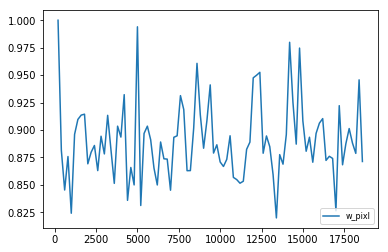

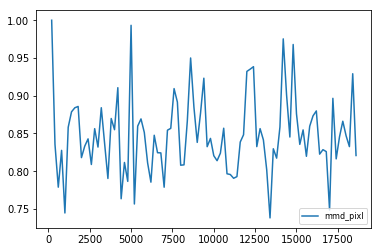

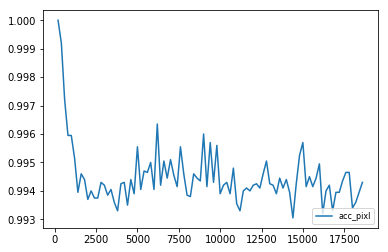

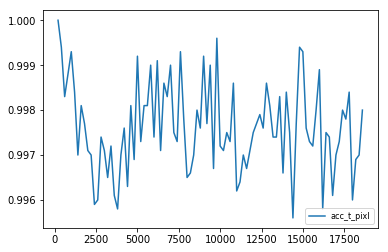

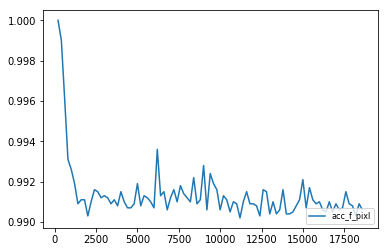

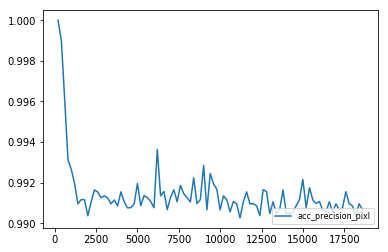

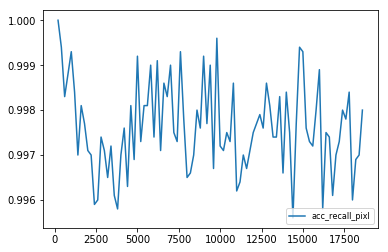

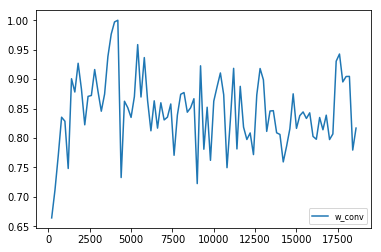

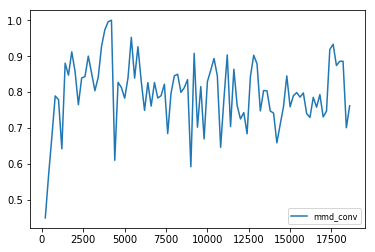

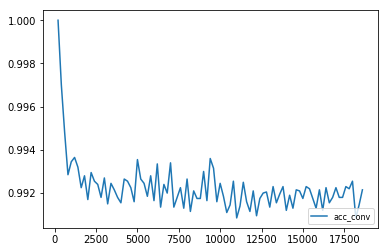

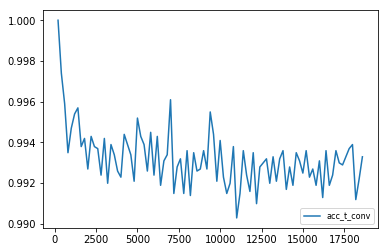

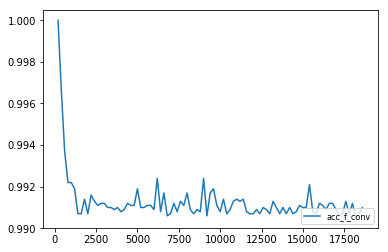

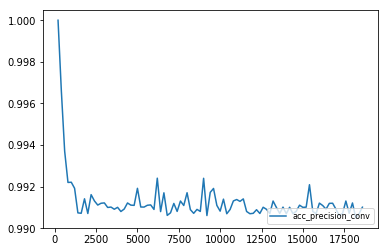

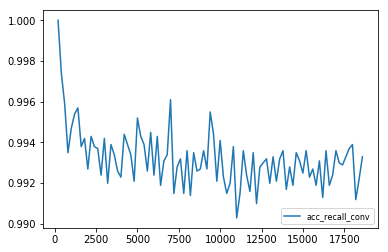

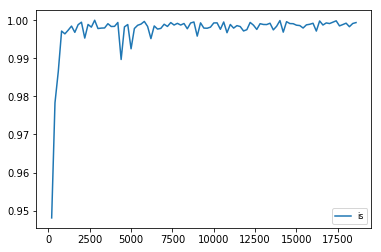

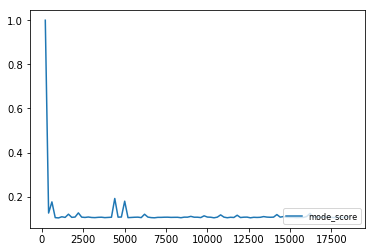

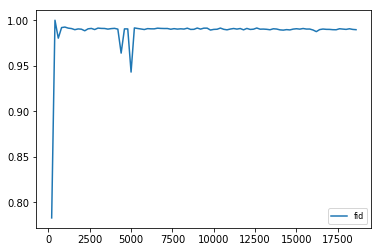

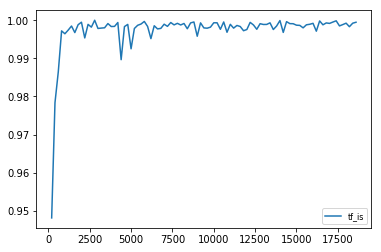

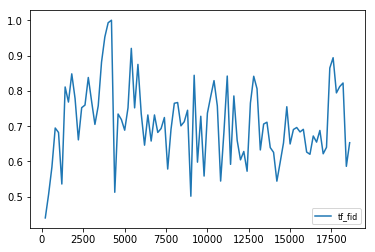

In [2]:

import torch.utils.data as Data

from keras.datasets import fashion_mnist,mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np
import os
class CGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100
        self.x = []
        self.y = np.zeros((31, 1), dtype=np.int)
        self.y = list(self.y)
        for i in range(31):
            self.y[i] = []

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(512 * 7 * 7, input_dim=self.latent_dim))
        model.add(Reshape((7,7, 512)))
        model.add(Activation("relu"))

        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(256, kernel_size=3, padding="same"))
        model.add(Activation("relu"))

        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3,strides=1,padding="same"))
        model.add(Activation("relu"))

        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3,strides=1, padding="same"))
        model.add(Activation("relu"))

        model.add(Conv2D(self.channels, strides=2,kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)
    def build_discriminator(self):
        model = Sequential()
        model.add(Dense(self.img_rows*self.img_cols*self.channels, input_dim=np.prod(self.img_shape)))
        model.add(Reshape((self.img_rows,self.img_cols,self.channels)))

        model.add(Conv2D(64, kernel_size=3, strides=2,padding="same"))
        model.add(LeakyReLU(alpha=0.2))

        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))

        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))

        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()
        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (X_test, _) = mnist.load_data()

        # Configure input
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        X_test = (X_test.astype(np.float32) - 127.5) / 127.5
        # X_test = X_test / 127.5 - 1.
        X_test = np.expand_dims(X_test, axis=3)

        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        nb_batches = int(X_train.shape[0] / batch_size)
        global_step = 0

        for epoch in range(epochs):

            for index in range(nb_batches):
                global_step += 1
                imgs = X_train[index * batch_size:(index + 1) * batch_size]
                labels = y_train[index * batch_size:(index + 1) * batch_size]

                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, 100))

                # Generate a half batch of new images
                gen_imgs = self.generator.predict([noise, labels])

                # Train the discriminator
                d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
                d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # ---------------------
                #  Train Generator
                # ---------------------

                # Condition on labels
                sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

                # Train the generator
                g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

                # Plot the progress
                print("epoch:%d step:%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch,global_step, d_loss[0], 100 * d_loss[1], g_loss))

                # If at save interval => save generated image samples
                sampleSize = 10000
                # If at save interval => save generated image samples
                if global_step % sample_interval == 0:
                    s = self.metrics(global_step, X_test, sampleSize)
        for i in range(len(s)):
            self.y[i] = [float(j) / max(self.y[i]) for j in self.y[i]]#对值进行归一化处理

        for i in range(len(s)):
            font1={'size':8}

            plt.plot(self.x, self.y[i], label=labels_name[i])
            plt.legend(loc='lower right',prop=font1)
            plt.savefig('saved_models_cgan/{}.png'.format(labels_name[i]))
            plt.show()
            plt.close()
    def metrics(self, epoch, X_test, sampleSize):
        self.x.append(epoch)
        r, c = 10, sampleSize//10
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.array([num for _ in range(r) for num in range(c)])
        gen_imgs = self.generator.predict([noise, sampled_labels])
        x_dataset = MyDataset(X_test[:sampleSize])
        # print(x_dataset[0].shape)
        x_real_loader = Data.DataLoader(dataset=x_dataset, batch_size=2000, shuffle=True)
        x_fake_dataset = MyDataset(gen_imgs)
        x_fake_loader = Data.DataLoader(dataset=x_fake_dataset, batch_size=2000, shuffle=True)
        s = compute_score_raw(x_real_loader, x_fake_loader, 256, '/real/', './fake', conv_model='tfgan',
                              workers=int(1))
        real_images = tf.convert_to_tensor(X_test)  # real images
        # MNIST_CLASSIFIER_FROZEN_GRAPH = '.\classify_mnist_graph_def.pb'
        gen_imgs = np.array(gen_imgs)
        eval_images = tf.convert_to_tensor(gen_imgs)
        eval_score = utils.mnist_score(eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH)  # IS score
        frechet_distance = utils.mnist_frechet_distance(real_images, eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH)
        mnist_score, f_distance = sess.run([eval_score, frechet_distance])
        # print(mnist_score)
        # print(f_distance)
        # s[14]=mnist_score
        # s[16]=f_distance
        s[17]=mnist_score
        s[18]=f_distance
        print('IS socre: %f' % mnist_score)
        print('FID: %f' % f_distance)

        for i in range(len(s)):
            print(i, "=", s[i])
        for i in range(len(s)):
            self.y[i].append(s[i])
        f.writelines('\n')
        f.writelines('epoch:' + str(epoch))
        f.writelines('\n')
        f.writelines('%.8f'%(i) for i in s)
        f.writelines('\n')
        return s


    def sample_images(self, epoch,global_step):
        r, c = 10, 10
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.array([num for _ in range(r) for num in range(c)])
        gen_imgs = self.generator.predict([noise, sampled_labels])
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        if not os.path.isdir('images_cgan'):
            os.mkdir('images_cgan')
        fig.savefig("images_cgan/epoch_%d_step_%d.png" % (epoch,global_step))
        plt.close()


if __name__ == '__main__':
    cgan = CGAN()
    cgan.train(epochs=20, batch_size=64, sample_interval=200)
